In [1]:
!pip install neurobench

import copy
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset

from neurobench.benchmarks import Benchmark
from neurobench.datasets import MSWC
from neurobench.datasets.MSWC_IncrementalLoader import IncrementalFewShot
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 39.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 80.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 85.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.41.1
    Uninstalling llvmlite-0.41

2024-04-12 08:07:03.334686: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 08:07:03.334786: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 08:07:03.491126: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
%load_ext tensorboard
# train and collect logs then call tensorboard
%tensorboard --logdir runs/

In [3]:
# data in repo root dir
ROOT = "./data/"

NUM_WORKERS = 4
BATCH_SIZE = 256

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "gpu p100")

if device == torch.device("cuda"):
    PIN_MEMORY = True
else:
    PIN_MEMORY = False
device

device(type='cuda')

In [5]:
SPIKING = False

In [6]:
from neurobench.preprocessing import MFCCPreProcessor, S2SPreProcessor

n_fft = 512
win_length = None
hop_length = 240
n_mels = 20
n_mfcc = 20

if SPIKING:
    encode = S2SPreProcessor(device, transpose=True)
    config_change = {"sample_rate": 48000,
                     "hop_length": 240}
    encode.configure(threshold=1.0, **config_change)
else:
    encode = MFCCPreProcessor(
        sample_rate=48000,
        n_mfcc=n_mfcc,
        melkwargs={
            "n_fft": n_fft,
            "n_mels": n_mels,
            "hop_length": hop_length,
            "mel_scale": "htk",
            "f_min": 20,
            "f_max": 4000,
        },
        device = device
    )

In [7]:
base_train_set = MSWC(root=ROOT, subset="base", procedure="training")

train_loader = DataLoader(base_train_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, shuffle=True)

base_validation_set = MSWC(root=ROOT, subset="base", procedure="validation")

validation_loader = DataLoader(base_validation_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, shuffle=True)

downloading ....


100%|██████████| 651349274/651349274 [00:15<00:00, 42990718.00it/s]


Unzipping file...


Extracting files: 100%|██████████| 90244/90244 [00:17<00:00, 5231.13file/s]


In [8]:
!pip install git+https://github.com/V0XNIHILI/TCN-library.git
!pip install torchsummary

from tcn_lib import TCN
from torchsummary import summary

!pip install -U numpy

  Cloning https://github.com/V0XNIHILI/TCN-library.git to /tmp/pip-req-build-6s2m479a
  Running command git clone --filter=blob:none --quiet https://github.com/V0XNIHILI/TCN-library.git /tmp/pip-req-build-6s2m479a
  Resolved https://github.com/V0XNIHILI/TCN-library.git to commit 64f40f382933dfc95e7d4bc50c1a68c6bef526c4
  Preparing metadata (setup.py) ... done
  Created wheel for tcn-library: filename=tcn_library-0.0.1-py3-none-any.whl size=12581 sha256=fd8ef1374329b620e1790e1f1faaf4df52c657d95515078a3198c950680edc7f
  Stored in directory: /tmp/pip-ephem-wheel-cache-9zw66sv_/wheels/0c/56/1c/31842b9b5052d6df41c630521df68b0b12ddf10a0214d6766e
Successfully built tcn-library
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 70.4 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 74.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled num

In [9]:
import torch.optim as optim

# Create a writer to write to Tensorboard
writer = SummaryWriter()

epochs = 20
train_accs = torch.zeros((7, 25))
train_losses = torch.zeros((7, 25))
val_accs = torch.zeros((7, 25))
val_losses = torch.zeros((7, 25))

for i in range(1, 7, 1):
    print("##########################################################")
    print("model with ", i, "layers : ")
    model = TCN(20, 200, [(32, 64)]*i + [(64, 256)], [9] * (i+1), batch_norm=True, weight_norm=True, residual = False, bottleneck=True, groups=8).to(device)
    # Create loss function and optimizer and learning rate scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    for epoch in tqdm(range(epochs)):

        train_avg_loss = 0
        train_correct = 0
        train_total = 0
    
        validation_avg_loss = 0
        validation_correct = 0
        validation_total = 0

        for data, target in train_loader:
            data, target = encode((data.to(device), target.to(device)))
            data = data.squeeze()

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_avg_loss += loss.item()
            _, predicted = output.max(1)
            train_total += target.size(0)
            train_correct += predicted.eq(target).sum().item()
        
        with torch.no_grad():
            for data, target in validation_loader:
                data, target = encode((data.to(device), target.to(device)))
                data = data.squeeze()

                output = model(data)
                loss = criterion(output, target)

                validation_avg_loss += loss.item()
                _, predicted = output.max(1)
                validation_total += target.size(0)
                validation_correct += predicted.eq(target).sum().item()

        train_loss, train_acc = train_avg_loss/len(train_loader), 100 * train_correct / train_total
        validation_loss, validation_acc = validation_avg_loss/len(validation_loader), 100 * validation_correct / validation_total

        print(f"Epoch {epoch} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}")
        print(f"Epoch {epoch} - Validation Loss: {validation_loss:.4f} - Validation Acc: {validation_acc:.2f}")
        
        train_losses[i, epoch] = train_loss
        train_accs[i, epoch] = train_acc
        val_losses[i, epoch] = validation_loss
        val_accs[i, epoch] = validation_acc

        writer.add_scalars("Loss", {'Train': train_loss, 'Validation':validation_loss}, epoch)
        writer.add_scalars('Accuracy', {'Train': train_acc,'Validation':validation_acc} , epoch)
    
    

##########################################################
model with  1 layers : 


/opt/conda/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
  5%|▌         | 1/20 [01:18<24:58, 78.86s/it]

Epoch 0 - Train Loss: 4.5022 - Train Acc: 2.47
Epoch 0 - Validation Loss: 4.4238 - Validation Acc: 3.31


 10%|█         | 2/20 [02:35<23:14, 77.46s/it]

Epoch 1 - Train Loss: 4.4123 - Train Acc: 3.37
Epoch 1 - Validation Loss: 4.3934 - Validation Acc: 3.75


 15%|█▌        | 3/20 [03:51<21:50, 77.08s/it]

Epoch 2 - Train Loss: 4.3813 - Train Acc: 3.74
Epoch 2 - Validation Loss: 4.3735 - Validation Acc: 3.86


 20%|██        | 4/20 [05:07<20:24, 76.52s/it]

Epoch 3 - Train Loss: 4.3610 - Train Acc: 3.92
Epoch 3 - Validation Loss: 4.3643 - Validation Acc: 4.15


 25%|██▌       | 5/20 [06:24<19:10, 76.72s/it]

Epoch 4 - Train Loss: 4.3503 - Train Acc: 4.15
Epoch 4 - Validation Loss: 4.3654 - Validation Acc: 3.99


 30%|███       | 6/20 [07:41<17:52, 76.60s/it]

Epoch 5 - Train Loss: 4.3420 - Train Acc: 4.12
Epoch 5 - Validation Loss: 4.3625 - Validation Acc: 4.00


 35%|███▌      | 7/20 [08:56<16:32, 76.33s/it]

Epoch 6 - Train Loss: 4.3330 - Train Acc: 4.22
Epoch 6 - Validation Loss: 4.3576 - Validation Acc: 4.27


 40%|████      | 8/20 [10:14<15:21, 76.81s/it]

Epoch 7 - Train Loss: 4.3261 - Train Acc: 4.39
Epoch 7 - Validation Loss: 4.3626 - Validation Acc: 4.05


 45%|████▌     | 9/20 [11:30<14:03, 76.64s/it]

Epoch 8 - Train Loss: 4.3183 - Train Acc: 4.47
Epoch 8 - Validation Loss: 4.3519 - Validation Acc: 4.12


 50%|█████     | 10/20 [12:47<12:46, 76.70s/it]

Epoch 9 - Train Loss: 4.3104 - Train Acc: 4.64
Epoch 9 - Validation Loss: 4.3539 - Validation Acc: 4.30


 55%|█████▌    | 11/20 [14:03<11:26, 76.27s/it]

Epoch 10 - Train Loss: 4.3026 - Train Acc: 4.62
Epoch 10 - Validation Loss: 4.3634 - Validation Acc: 4.17


 60%|██████    | 12/20 [15:18<10:08, 76.09s/it]

Epoch 11 - Train Loss: 4.2955 - Train Acc: 4.79
Epoch 11 - Validation Loss: 4.3535 - Validation Acc: 4.23


 65%|██████▌   | 13/20 [16:34<08:51, 75.91s/it]

Epoch 12 - Train Loss: 4.2896 - Train Acc: 4.90
Epoch 12 - Validation Loss: 4.3631 - Validation Acc: 4.28


 70%|███████   | 14/20 [17:50<07:35, 75.93s/it]

Epoch 13 - Train Loss: 4.2804 - Train Acc: 5.00
Epoch 13 - Validation Loss: 4.3619 - Validation Acc: 4.28


 75%|███████▌  | 15/20 [19:06<06:20, 76.06s/it]

Epoch 14 - Train Loss: 4.2722 - Train Acc: 5.07
Epoch 14 - Validation Loss: 4.3520 - Validation Acc: 4.21


 80%|████████  | 16/20 [20:22<05:04, 76.11s/it]

Epoch 15 - Train Loss: 4.2667 - Train Acc: 5.24
Epoch 15 - Validation Loss: 4.3645 - Validation Acc: 4.28


 85%|████████▌ | 17/20 [21:39<03:48, 76.33s/it]

Epoch 16 - Train Loss: 4.2578 - Train Acc: 5.24
Epoch 16 - Validation Loss: 4.3728 - Validation Acc: 3.82


 90%|█████████ | 18/20 [22:55<02:32, 76.08s/it]

Epoch 17 - Train Loss: 4.2458 - Train Acc: 5.51
Epoch 17 - Validation Loss: 4.3755 - Validation Acc: 4.35


 95%|█████████▌| 19/20 [24:11<01:16, 76.20s/it]

Epoch 18 - Train Loss: 4.2386 - Train Acc: 5.57
Epoch 18 - Validation Loss: 4.3969 - Validation Acc: 4.06


100%|██████████| 20/20 [25:27<00:00, 76.35s/it]
/opt/conda/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Epoch 19 - Train Loss: 4.2274 - Train Acc: 5.65
Epoch 19 - Validation Loss: 4.3932 - Validation Acc: 4.06
##########################################################
model with  2 layers : 


  5%|▌         | 1/20 [01:16<24:14, 76.54s/it]

Epoch 0 - Train Loss: 3.8417 - Train Acc: 9.19
Epoch 0 - Validation Loss: 3.5352 - Validation Acc: 12.97


 10%|█         | 2/20 [02:33<23:00, 76.68s/it]

Epoch 1 - Train Loss: 3.4292 - Train Acc: 14.54
Epoch 1 - Validation Loss: 3.3754 - Validation Acc: 15.46


 15%|█▌        | 3/20 [03:48<21:33, 76.06s/it]

Epoch 2 - Train Loss: 3.2865 - Train Acc: 16.95
Epoch 2 - Validation Loss: 3.2910 - Validation Acc: 16.56


 20%|██        | 4/20 [05:05<20:20, 76.25s/it]

Epoch 3 - Train Loss: 3.1956 - Train Acc: 18.77
Epoch 3 - Validation Loss: 3.2640 - Validation Acc: 18.01


 25%|██▌       | 5/20 [06:23<19:15, 77.00s/it]

Epoch 4 - Train Loss: 3.1292 - Train Acc: 20.00
Epoch 4 - Validation Loss: 3.2242 - Validation Acc: 18.13


 30%|███       | 6/20 [07:42<18:06, 77.59s/it]

Epoch 5 - Train Loss: 3.0648 - Train Acc: 21.52
Epoch 5 - Validation Loss: 3.1808 - Validation Acc: 19.30


 35%|███▌      | 7/20 [08:59<16:45, 77.34s/it]

Epoch 6 - Train Loss: 3.0186 - Train Acc: 22.50
Epoch 6 - Validation Loss: 3.1652 - Validation Acc: 20.05


 40%|████      | 8/20 [10:15<15:25, 77.12s/it]

Epoch 7 - Train Loss: 2.9745 - Train Acc: 23.36
Epoch 7 - Validation Loss: 3.1575 - Validation Acc: 20.43


 45%|████▌     | 9/20 [11:32<14:07, 77.01s/it]

Epoch 8 - Train Loss: 2.9305 - Train Acc: 24.07
Epoch 8 - Validation Loss: 3.1535 - Validation Acc: 19.91


 50%|█████     | 10/20 [12:48<12:47, 76.71s/it]

Epoch 9 - Train Loss: 2.8947 - Train Acc: 24.86
Epoch 9 - Validation Loss: 3.1816 - Validation Acc: 19.89


 55%|█████▌    | 11/20 [14:06<11:33, 77.08s/it]

Epoch 10 - Train Loss: 2.8565 - Train Acc: 25.46
Epoch 10 - Validation Loss: 3.1601 - Validation Acc: 20.52


 60%|██████    | 12/20 [15:23<10:16, 77.10s/it]

Epoch 11 - Train Loss: 2.8304 - Train Acc: 25.99
Epoch 11 - Validation Loss: 3.1404 - Validation Acc: 20.94


 65%|██████▌   | 13/20 [16:40<08:59, 77.09s/it]

Epoch 12 - Train Loss: 2.7939 - Train Acc: 26.86
Epoch 12 - Validation Loss: 3.1736 - Validation Acc: 20.80


 70%|███████   | 14/20 [17:57<07:41, 76.97s/it]

Epoch 13 - Train Loss: 2.7691 - Train Acc: 27.31
Epoch 13 - Validation Loss: 3.1618 - Validation Acc: 20.70


 75%|███████▌  | 15/20 [19:14<06:25, 77.01s/it]

Epoch 14 - Train Loss: 2.7285 - Train Acc: 28.44
Epoch 14 - Validation Loss: 3.1685 - Validation Acc: 20.52


 80%|████████  | 16/20 [20:34<05:11, 77.89s/it]

Epoch 15 - Train Loss: 2.7139 - Train Acc: 28.77
Epoch 15 - Validation Loss: 3.2294 - Validation Acc: 20.93


 85%|████████▌ | 17/20 [21:55<03:56, 78.73s/it]

Epoch 16 - Train Loss: 2.6869 - Train Acc: 28.99
Epoch 16 - Validation Loss: 3.2099 - Validation Acc: 20.62


 90%|█████████ | 18/20 [23:13<02:36, 78.50s/it]

Epoch 17 - Train Loss: 2.6645 - Train Acc: 29.62
Epoch 17 - Validation Loss: 3.2288 - Validation Acc: 20.57


 95%|█████████▌| 19/20 [24:31<01:18, 78.56s/it]

Epoch 18 - Train Loss: 2.6321 - Train Acc: 30.30
Epoch 18 - Validation Loss: 3.2665 - Validation Acc: 20.16


100%|██████████| 20/20 [25:49<00:00, 77.49s/it]


Epoch 19 - Train Loss: 2.6133 - Train Acc: 30.83
Epoch 19 - Validation Loss: 3.3198 - Validation Acc: 20.33
##########################################################
model with  3 layers : 


  5%|▌         | 1/20 [01:17<24:37, 77.74s/it]

Epoch 0 - Train Loss: 2.2402 - Train Acc: 42.80
Epoch 0 - Validation Loss: 1.2402 - Validation Acc: 65.47


 10%|█         | 2/20 [02:35<23:16, 77.57s/it]

Epoch 1 - Train Loss: 1.0217 - Train Acc: 71.71
Epoch 1 - Validation Loss: 0.9097 - Validation Acc: 74.50


 15%|█▌        | 3/20 [03:52<21:57, 77.48s/it]

Epoch 2 - Train Loss: 0.7500 - Train Acc: 78.54
Epoch 2 - Validation Loss: 0.7591 - Validation Acc: 79.01


 20%|██        | 4/20 [05:10<20:42, 77.68s/it]

Epoch 3 - Train Loss: 0.6133 - Train Acc: 82.19
Epoch 3 - Validation Loss: 0.7004 - Validation Acc: 81.13


 25%|██▌       | 5/20 [06:28<19:25, 77.70s/it]

Epoch 4 - Train Loss: 0.5253 - Train Acc: 84.69
Epoch 4 - Validation Loss: 0.6745 - Validation Acc: 81.87


 30%|███       | 6/20 [07:46<18:09, 77.85s/it]

Epoch 5 - Train Loss: 0.4737 - Train Acc: 85.94
Epoch 5 - Validation Loss: 0.6650 - Validation Acc: 82.23


 35%|███▌      | 7/20 [09:05<16:56, 78.21s/it]

Epoch 6 - Train Loss: 0.4303 - Train Acc: 87.30
Epoch 6 - Validation Loss: 0.5824 - Validation Acc: 83.99


 40%|████      | 8/20 [10:24<15:42, 78.57s/it]

Epoch 7 - Train Loss: 0.3899 - Train Acc: 88.05
Epoch 7 - Validation Loss: 0.5852 - Validation Acc: 84.62


 45%|████▌     | 9/20 [11:43<14:23, 78.54s/it]

Epoch 8 - Train Loss: 0.3540 - Train Acc: 89.22
Epoch 8 - Validation Loss: 0.5742 - Validation Acc: 84.43


 50%|█████     | 10/20 [13:01<13:04, 78.49s/it]

Epoch 9 - Train Loss: 0.3339 - Train Acc: 89.55
Epoch 9 - Validation Loss: 0.5643 - Validation Acc: 85.18


 55%|█████▌    | 11/20 [14:21<11:49, 78.80s/it]

Epoch 10 - Train Loss: 0.3155 - Train Acc: 90.23
Epoch 10 - Validation Loss: 0.5935 - Validation Acc: 84.44


 60%|██████    | 12/20 [15:38<10:27, 78.45s/it]

Epoch 11 - Train Loss: 0.2961 - Train Acc: 90.61
Epoch 11 - Validation Loss: 0.5818 - Validation Acc: 85.14


 65%|██████▌   | 13/20 [16:57<09:10, 78.60s/it]

Epoch 12 - Train Loss: 0.2721 - Train Acc: 91.34
Epoch 12 - Validation Loss: 0.6080 - Validation Acc: 84.82


 70%|███████   | 14/20 [18:16<07:51, 78.58s/it]

Epoch 13 - Train Loss: 0.2558 - Train Acc: 91.74
Epoch 13 - Validation Loss: 0.6018 - Validation Acc: 85.25


 75%|███████▌  | 15/20 [19:35<06:33, 78.67s/it]

Epoch 14 - Train Loss: 0.2488 - Train Acc: 91.83
Epoch 14 - Validation Loss: 0.5990 - Validation Acc: 85.31


 80%|████████  | 16/20 [20:53<05:14, 78.55s/it]

Epoch 15 - Train Loss: 0.2235 - Train Acc: 92.64
Epoch 15 - Validation Loss: 0.6024 - Validation Acc: 85.46


 85%|████████▌ | 17/20 [22:11<03:55, 78.47s/it]

Epoch 16 - Train Loss: 0.2103 - Train Acc: 93.01
Epoch 16 - Validation Loss: 0.6469 - Validation Acc: 84.58


 90%|█████████ | 18/20 [23:30<02:37, 78.69s/it]

Epoch 17 - Train Loss: 0.2076 - Train Acc: 93.01
Epoch 17 - Validation Loss: 0.6362 - Validation Acc: 85.66


 95%|█████████▌| 19/20 [24:49<01:18, 78.74s/it]

Epoch 18 - Train Loss: 0.1928 - Train Acc: 93.56
Epoch 18 - Validation Loss: 0.6319 - Validation Acc: 85.50


100%|██████████| 20/20 [26:07<00:00, 78.39s/it]


Epoch 19 - Train Loss: 0.1873 - Train Acc: 93.78
Epoch 19 - Validation Loss: 0.6305 - Validation Acc: 85.70
##########################################################
model with  4 layers : 


  5%|▌         | 1/20 [01:18<24:54, 78.68s/it]

Epoch 0 - Train Loss: 1.9012 - Train Acc: 51.20
Epoch 0 - Validation Loss: 0.9471 - Validation Acc: 73.71


 10%|█         | 2/20 [02:37<23:33, 78.55s/it]

Epoch 1 - Train Loss: 0.7020 - Train Acc: 80.20
Epoch 1 - Validation Loss: 0.6352 - Validation Acc: 82.42


 15%|█▌        | 3/20 [03:57<22:31, 79.52s/it]

Epoch 2 - Train Loss: 0.4817 - Train Acc: 86.44
Epoch 2 - Validation Loss: 0.4573 - Validation Acc: 87.42


 20%|██        | 4/20 [05:16<21:05, 79.07s/it]

Epoch 3 - Train Loss: 0.3724 - Train Acc: 89.42
Epoch 3 - Validation Loss: 0.4135 - Validation Acc: 88.80


 25%|██▌       | 5/20 [06:34<19:44, 78.96s/it]

Epoch 4 - Train Loss: 0.3082 - Train Acc: 91.12
Epoch 4 - Validation Loss: 0.3785 - Validation Acc: 90.09


 30%|███       | 6/20 [07:51<18:14, 78.16s/it]

Epoch 5 - Train Loss: 0.2638 - Train Acc: 92.28
Epoch 5 - Validation Loss: 0.3497 - Validation Acc: 91.08


 35%|███▌      | 7/20 [09:08<16:49, 77.66s/it]

Epoch 6 - Train Loss: 0.2247 - Train Acc: 93.43
Epoch 6 - Validation Loss: 0.3540 - Validation Acc: 90.95


 40%|████      | 8/20 [10:25<15:29, 77.46s/it]

Epoch 7 - Train Loss: 0.2080 - Train Acc: 93.70
Epoch 7 - Validation Loss: 0.3346 - Validation Acc: 91.09


 45%|████▌     | 9/20 [11:42<14:12, 77.53s/it]

Epoch 8 - Train Loss: 0.1927 - Train Acc: 94.15
Epoch 8 - Validation Loss: 0.3548 - Validation Acc: 91.16


 50%|█████     | 10/20 [13:01<12:58, 77.80s/it]

Epoch 9 - Train Loss: 0.1784 - Train Acc: 94.46
Epoch 9 - Validation Loss: 0.3208 - Validation Acc: 91.71


 55%|█████▌    | 11/20 [14:19<11:40, 77.82s/it]

Epoch 10 - Train Loss: 0.1505 - Train Acc: 95.33
Epoch 10 - Validation Loss: 0.3301 - Validation Acc: 91.80


 60%|██████    | 12/20 [15:39<10:27, 78.49s/it]

Epoch 11 - Train Loss: 0.1425 - Train Acc: 95.46
Epoch 11 - Validation Loss: 0.3474 - Validation Acc: 91.70


 65%|██████▌   | 13/20 [16:57<09:09, 78.47s/it]

Epoch 12 - Train Loss: 0.1382 - Train Acc: 95.63
Epoch 12 - Validation Loss: 0.3499 - Validation Acc: 91.82


 70%|███████   | 14/20 [18:16<07:52, 78.67s/it]

Epoch 13 - Train Loss: 0.1257 - Train Acc: 96.01
Epoch 13 - Validation Loss: 0.3185 - Validation Acc: 92.31


 75%|███████▌  | 15/20 [19:36<06:35, 79.11s/it]

Epoch 14 - Train Loss: 0.1179 - Train Acc: 96.22
Epoch 14 - Validation Loss: 0.3136 - Validation Acc: 92.17


 80%|████████  | 16/20 [20:56<05:17, 79.41s/it]

Epoch 15 - Train Loss: 0.1134 - Train Acc: 96.32
Epoch 15 - Validation Loss: 0.3672 - Validation Acc: 91.52


 85%|████████▌ | 17/20 [22:16<03:58, 79.34s/it]

Epoch 16 - Train Loss: 0.1110 - Train Acc: 96.42
Epoch 16 - Validation Loss: 0.3197 - Validation Acc: 92.06


 90%|█████████ | 18/20 [23:35<02:38, 79.19s/it]

Epoch 17 - Train Loss: 0.1060 - Train Acc: 96.54
Epoch 17 - Validation Loss: 0.3407 - Validation Acc: 91.79


 95%|█████████▌| 19/20 [24:54<01:19, 79.33s/it]

Epoch 18 - Train Loss: 0.0989 - Train Acc: 96.74
Epoch 18 - Validation Loss: 0.3403 - Validation Acc: 91.99


100%|██████████| 20/20 [26:13<00:00, 78.68s/it]


Epoch 19 - Train Loss: 0.0927 - Train Acc: 97.00
Epoch 19 - Validation Loss: 0.3270 - Validation Acc: 92.97
##########################################################
model with  5 layers : 


  5%|▌         | 1/20 [01:20<25:20, 80.01s/it]

Epoch 0 - Train Loss: 2.6134 - Train Acc: 34.53
Epoch 0 - Validation Loss: 1.2465 - Validation Acc: 66.02


 10%|█         | 2/20 [02:39<23:54, 79.71s/it]

Epoch 1 - Train Loss: 0.8793 - Train Acc: 75.35
Epoch 1 - Validation Loss: 0.7087 - Validation Acc: 80.14


 15%|█▌        | 3/20 [03:57<22:25, 79.14s/it]

Epoch 2 - Train Loss: 0.5658 - Train Acc: 84.08
Epoch 2 - Validation Loss: 0.5763 - Validation Acc: 84.85


 20%|██        | 4/20 [05:17<21:07, 79.22s/it]

Epoch 3 - Train Loss: 0.4421 - Train Acc: 87.40
Epoch 3 - Validation Loss: 0.4805 - Validation Acc: 87.04


 25%|██▌       | 5/20 [06:37<19:52, 79.52s/it]

Epoch 4 - Train Loss: 0.3666 - Train Acc: 89.38
Epoch 4 - Validation Loss: 0.4204 - Validation Acc: 88.78


 30%|███       | 6/20 [07:57<18:34, 79.60s/it]

Epoch 5 - Train Loss: 0.3206 - Train Acc: 90.58
Epoch 5 - Validation Loss: 0.4339 - Validation Acc: 88.68


 35%|███▌      | 7/20 [09:17<17:16, 79.76s/it]

Epoch 6 - Train Loss: 0.2849 - Train Acc: 91.70
Epoch 6 - Validation Loss: 0.3604 - Validation Acc: 90.25


 40%|████      | 8/20 [10:36<15:54, 79.50s/it]

Epoch 7 - Train Loss: 0.2613 - Train Acc: 92.29
Epoch 7 - Validation Loss: 0.3548 - Validation Acc: 90.34


 45%|████▌     | 9/20 [11:54<14:31, 79.23s/it]

Epoch 8 - Train Loss: 0.2346 - Train Acc: 92.90
Epoch 8 - Validation Loss: 0.3623 - Validation Acc: 89.90


 50%|█████     | 10/20 [13:12<13:07, 78.76s/it]

Epoch 9 - Train Loss: 0.2127 - Train Acc: 93.59
Epoch 9 - Validation Loss: 0.3598 - Validation Acc: 90.40


 55%|█████▌    | 11/20 [14:30<11:46, 78.45s/it]

Epoch 10 - Train Loss: 0.2043 - Train Acc: 93.78
Epoch 10 - Validation Loss: 0.3260 - Validation Acc: 91.27


 60%|██████    | 12/20 [15:48<10:26, 78.28s/it]

Epoch 11 - Train Loss: 0.1854 - Train Acc: 94.31
Epoch 11 - Validation Loss: 0.3434 - Validation Acc: 91.21


 65%|██████▌   | 13/20 [17:07<09:09, 78.49s/it]

Epoch 12 - Train Loss: 0.1686 - Train Acc: 94.81
Epoch 12 - Validation Loss: 0.3104 - Validation Acc: 92.14


 70%|███████   | 14/20 [18:25<07:50, 78.45s/it]

Epoch 13 - Train Loss: 0.1698 - Train Acc: 94.73
Epoch 13 - Validation Loss: 0.3557 - Validation Acc: 90.76


 75%|███████▌  | 15/20 [19:44<06:32, 78.48s/it]

Epoch 14 - Train Loss: 0.1593 - Train Acc: 94.90
Epoch 14 - Validation Loss: 0.3600 - Validation Acc: 90.70


 80%|████████  | 16/20 [21:02<05:14, 78.52s/it]

Epoch 15 - Train Loss: 0.1441 - Train Acc: 95.45
Epoch 15 - Validation Loss: 0.3247 - Validation Acc: 91.79


 85%|████████▌ | 17/20 [22:19<03:54, 78.08s/it]

Epoch 16 - Train Loss: 0.1376 - Train Acc: 95.67
Epoch 16 - Validation Loss: 0.3469 - Validation Acc: 91.80


 90%|█████████ | 18/20 [23:37<02:35, 77.91s/it]

Epoch 17 - Train Loss: 0.1379 - Train Acc: 95.60
Epoch 17 - Validation Loss: 0.3167 - Validation Acc: 91.82


 95%|█████████▌| 19/20 [24:55<01:18, 78.08s/it]

Epoch 18 - Train Loss: 0.1241 - Train Acc: 95.93
Epoch 18 - Validation Loss: 0.3567 - Validation Acc: 91.60


100%|██████████| 20/20 [26:12<00:00, 78.65s/it]


Epoch 19 - Train Loss: 0.1206 - Train Acc: 96.09
Epoch 19 - Validation Loss: 0.3307 - Validation Acc: 91.75
##########################################################
model with  6 layers : 


  5%|▌         | 1/20 [01:18<24:46, 78.24s/it]

Epoch 0 - Train Loss: 3.1057 - Train Acc: 23.08
Epoch 0 - Validation Loss: 1.7211 - Validation Acc: 51.29


 10%|█         | 2/20 [02:36<23:28, 78.26s/it]

Epoch 1 - Train Loss: 1.2902 - Train Acc: 63.22
Epoch 1 - Validation Loss: 1.0716 - Validation Acc: 69.55


 15%|█▌        | 3/20 [03:53<22:04, 77.89s/it]

Epoch 2 - Train Loss: 0.8625 - Train Acc: 75.66
Epoch 2 - Validation Loss: 0.8124 - Validation Acc: 76.76


 20%|██        | 4/20 [05:11<20:45, 77.83s/it]

Epoch 3 - Train Loss: 0.6762 - Train Acc: 80.70
Epoch 3 - Validation Loss: 0.6190 - Validation Acc: 82.37


 25%|██▌       | 5/20 [06:29<19:27, 77.80s/it]

Epoch 4 - Train Loss: 0.5586 - Train Acc: 84.09
Epoch 4 - Validation Loss: 0.5942 - Validation Acc: 83.44


 30%|███       | 6/20 [07:48<18:13, 78.14s/it]

Epoch 5 - Train Loss: 0.4789 - Train Acc: 86.19
Epoch 5 - Validation Loss: 0.5466 - Validation Acc: 85.05


 35%|███▌      | 7/20 [09:06<16:56, 78.18s/it]

Epoch 6 - Train Loss: 0.4272 - Train Acc: 87.76
Epoch 6 - Validation Loss: 0.5103 - Validation Acc: 85.89


 40%|████      | 8/20 [10:24<15:38, 78.20s/it]

Epoch 7 - Train Loss: 0.3892 - Train Acc: 88.51
Epoch 7 - Validation Loss: 0.4743 - Validation Acc: 86.92


 45%|████▌     | 9/20 [11:42<14:16, 77.91s/it]

Epoch 8 - Train Loss: 0.3532 - Train Acc: 89.83
Epoch 8 - Validation Loss: 0.4895 - Validation Acc: 87.05


 50%|█████     | 10/20 [13:00<12:59, 77.97s/it]

Epoch 9 - Train Loss: 0.3211 - Train Acc: 90.50
Epoch 9 - Validation Loss: 0.4151 - Validation Acc: 88.76


 55%|█████▌    | 11/20 [14:18<11:42, 78.08s/it]

Epoch 10 - Train Loss: 0.3073 - Train Acc: 90.97
Epoch 10 - Validation Loss: 0.4502 - Validation Acc: 88.30


 60%|██████    | 12/20 [15:36<10:25, 78.15s/it]

Epoch 11 - Train Loss: 0.2843 - Train Acc: 91.40
Epoch 11 - Validation Loss: 0.4412 - Validation Acc: 88.63


 65%|██████▌   | 13/20 [16:55<09:07, 78.22s/it]

Epoch 12 - Train Loss: 0.2623 - Train Acc: 92.08
Epoch 12 - Validation Loss: 0.4004 - Validation Acc: 89.61


 70%|███████   | 14/20 [18:14<07:52, 78.67s/it]

Epoch 13 - Train Loss: 0.2528 - Train Acc: 92.35
Epoch 13 - Validation Loss: 0.4272 - Validation Acc: 89.37


 75%|███████▌  | 15/20 [19:35<06:36, 79.32s/it]

Epoch 14 - Train Loss: 0.2370 - Train Acc: 92.83
Epoch 14 - Validation Loss: 0.3860 - Validation Acc: 89.67


 80%|████████  | 16/20 [20:55<05:17, 79.43s/it]

Epoch 15 - Train Loss: 0.2274 - Train Acc: 93.10
Epoch 15 - Validation Loss: 0.3859 - Validation Acc: 90.30


 85%|████████▌ | 17/20 [22:14<03:57, 79.31s/it]

Epoch 16 - Train Loss: 0.2127 - Train Acc: 93.49
Epoch 16 - Validation Loss: 0.4215 - Validation Acc: 89.33


 90%|█████████ | 18/20 [23:33<02:38, 79.38s/it]

Epoch 17 - Train Loss: 0.1998 - Train Acc: 93.80
Epoch 17 - Validation Loss: 0.3971 - Validation Acc: 90.29


 95%|█████████▌| 19/20 [24:52<01:19, 79.24s/it]

Epoch 18 - Train Loss: 0.2010 - Train Acc: 93.79
Epoch 18 - Validation Loss: 0.3967 - Validation Acc: 90.22


100%|██████████| 20/20 [26:14<00:00, 78.73s/it]

Epoch 19 - Train Loss: 0.1875 - Train Acc: 94.15
Epoch 19 - Validation Loss: 0.3723 - Validation Acc: 90.36


In [60]:
train_accs_np = train_accs[1:, :20].numpy()
val_accs_np = val_accs[1:, :20].numpy()
train_losses_np = train_losses[1:, :20].numpy()
val_losses_np = val_losses[1:, :20].numpy()
#print(train_accs_np)
np.savetxt("train_accs.csv", train_accs_np, delimiter = ',')
np.savetxt("val_accs.csv", val_accs_np, delimiter = ',')
np.savetxt("train_losses.csv", train_losses_np, delimiter = ',')
np.savetxt("val_losses.csv", val_losses_np, delimiter = ',')

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np
import matplotlib as mpl
sns.set_style("whitegrid")

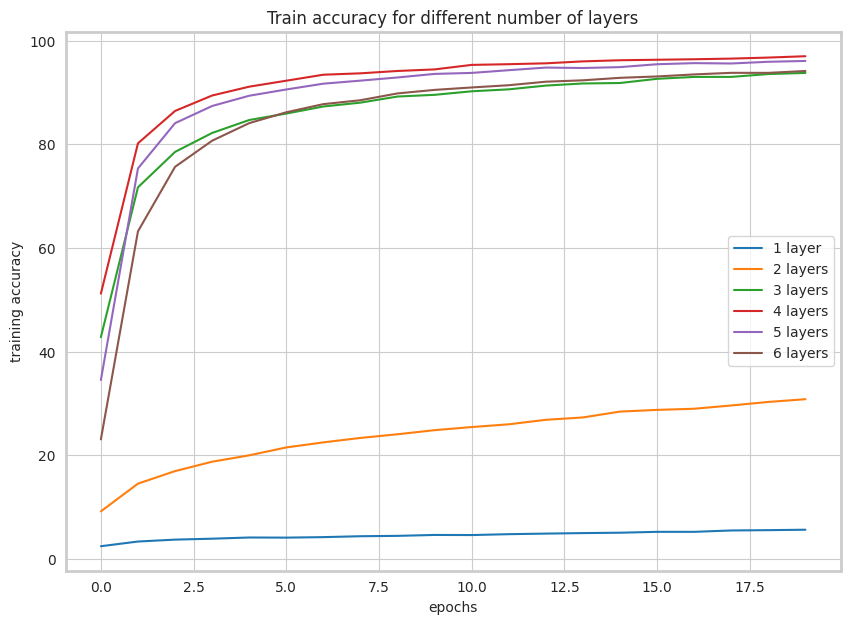

In [40]:
plt.figure(figsize = (10, 7))

#sns.set_style("whitegrid")
plt.plot(train_accs[1, :20], label = "1 layer")
plt.plot(train_accs[2, :20], label = "2 layers")
plt.plot(train_accs[3, :20], label = "3 layers")
plt.plot(train_accs[4, :20], label = "4 layers")
plt.plot(train_accs[5, :20], label = "5 layers")
plt.plot(train_accs[6, :20], label = "6 layers")
plt.xlabel("epochs")
plt.ylabel("training accuracy")
plt.title("Train accuracy for different number of layers")
plt.legend()
plt.show()

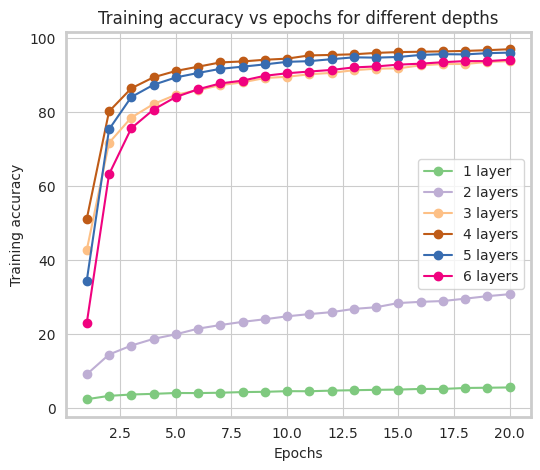

In [45]:
fig, ax = plt.subplots(figsize = (6, 5))
mpl.rcParams['axes.linewidth'] = 2
epochs = np.arange(1, 21, 1)
labels = ["1 layer", "2 layers", "3 layers", "4 layers", "5 layers", "6 layers" ]
colors = ["#7fc97f", "#beaed4", "#fdc086", "#bf5b17", "#386cb0", "#f0027f"]

for i, label in enumerate(labels):
    ax.plot(epochs, train_accs[i+1, :20], "-o", label = label, color = colors[i], linewidth = 1.5)
    
ax.set_xlabel("Epochs")
ax.set_ylabel("Training accuracy")
ax.set_title("Training accuracy vs epochs for different depths")
ax.legend()

plt.savefig("Training accuracy vs epochs for different depths", dpi = 300)
plt.show()

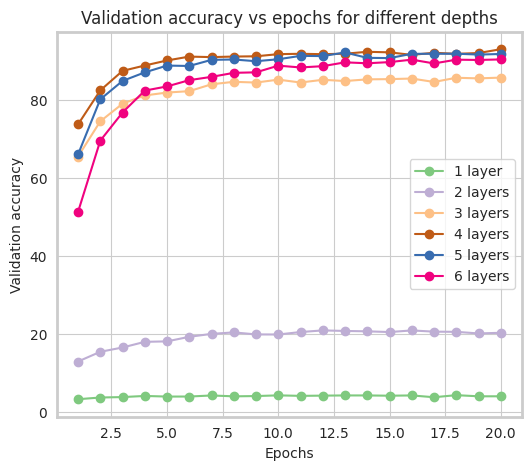

In [47]:
fig, ax = plt.subplots(figsize = (6, 5))
mpl.rcParams['axes.linewidth'] = 2
epochs = np.arange(1, 21, 1)
labels = ["1 layer", "2 layers", "3 layers", "4 layers", "5 layers", "6 layers" ]
colors = ["#7fc97f", "#beaed4", "#fdc086", "#bf5b17", "#386cb0", "#f0027f"]

for i, label in enumerate(labels):
    ax.plot(epochs, val_accs[i+1, :20], "-o", label = label, color = colors[i], linewidth = 1.5)
    
ax.set_xlabel("Epochs")
ax.set_ylabel("Validation accuracy")
ax.set_title("Validation accuracy vs epochs for different depths")
ax.legend()

plt.savefig("Validation accuracy vs epochs for different depths", dpi = 300)
plt.show()

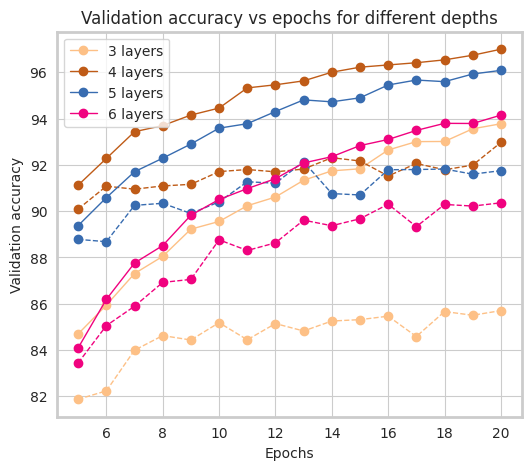

In [51]:
fig, ax = plt.subplots(figsize = (6, 5))
mpl.rcParams['axes.linewidth'] = 2
epochs = np.arange(5, 21, 1)
labels = ["3 layers", "4 layers", "5 layers", "6 layers" ]
colors = ["#fdc086", "#bf5b17", "#386cb0", "#f0027f"]

for i, label in enumerate(labels):
    ax.plot(epochs, train_accs[i+3, 4:20], "-o", label = label, color = colors[i], linewidth = 1)
    ax.plot(epochs, val_accs[i+3, 4:20], "--o", color = colors[i], linewidth = 1)
    
ax.set_xlabel("Epochs")
ax.set_ylabel("Validation accuracy")
ax.set_title("Validation accuracy vs epochs for different depths")
ax.legend()

plt.savefig("Validation accuracy vs epochs for different depths", dpi = 300)
plt.show()

Graphs of the influences of group and batch normalisation

In [63]:
import torch.optim as optim

# Create a writer to write to Tensorboard
writer = SummaryWriter()

epochs = 20
train_accs = torch.zeros((3, 4, 20))
train_losses = torch.zeros((3, 4, 20))
val_accs = torch.zeros((3, 4, 20))
val_losses = torch.zeros((3, 4, 20))

bn_state = [True, True, False, False]
wn_state = [True, False, True, False]

for i in range(2):
    for j in range(4):
        print("##########################################################")
        print("model with ", i, "layers : ")
        model = TCN(20, 200, [(32, 64)]*(i+4) + [(64, 256)], [9] * (i+5), batch_norm=bn_state[j], weight_norm=wn_state[j], residual = False, bottleneck=True, groups=8).to(device)
        # Create loss function and optimizer and learning rate scheduler
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-2)
        for epoch in tqdm(range(epochs)):
    
            train_avg_loss = 0
            train_correct = 0
            train_total = 0
        
            validation_avg_loss = 0
            validation_correct = 0
            validation_total = 0
    
            for data, target in train_loader:
                data, target = encode((data.to(device), target.to(device)))
                data = data.squeeze()
    
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
    
                train_avg_loss += loss.item()
                _, predicted = output.max(1)
                train_total += target.size(0)
                train_correct += predicted.eq(target).sum().item()
            
            with torch.no_grad():
                for data, target in validation_loader:
                    data, target = encode((data.to(device), target.to(device)))
                    data = data.squeeze()
    
                    output = model(data)
                    loss = criterion(output, target)
    
                    validation_avg_loss += loss.item()
                    _, predicted = output.max(1)
                    validation_total += target.size(0)
                    validation_correct += predicted.eq(target).sum().item()

            train_loss, train_acc = train_avg_loss/len(train_loader), 100 * train_correct / train_total
            validation_loss, validation_acc = validation_avg_loss/len(validation_loader), 100 * validation_correct / validation_total

            print(f"Epoch {epoch} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}")
            print(f"Epoch {epoch} - Validation Loss: {validation_loss:.4f} - Validation Acc: {validation_acc:.2f}")
        
            train_losses[i, j, epoch] = train_loss
            train_accs[i, j, epoch] = train_acc
            val_losses[i, j, epoch] = validation_loss
            val_accs[i, j, epoch] = validation_acc

            writer.add_scalars("Loss", {'Train': train_loss, 'Validation':validation_loss}, epoch)
            writer.add_scalars('Accuracy', {'Train': train_acc,'Validation':validation_acc} , epoch)
    
    

##########################################################
model with  0 layers : 


  5%|▌         | 1/20 [01:21<25:46, 81.37s/it]

Epoch 0 - Train Loss: 1.8713 - Train Acc: 52.12
Epoch 0 - Validation Loss: 0.9407 - Validation Acc: 74.27


 10%|█         | 2/20 [02:43<24:36, 82.05s/it]

Epoch 1 - Train Loss: 0.6564 - Train Acc: 81.79
Epoch 1 - Validation Loss: 0.5742 - Validation Acc: 84.51


 15%|█▌        | 3/20 [04:05<23:14, 82.04s/it]

Epoch 2 - Train Loss: 0.4452 - Train Acc: 87.38
Epoch 2 - Validation Loss: 0.4687 - Validation Acc: 87.87


 20%|██        | 4/20 [05:27<21:49, 81.87s/it]

Epoch 3 - Train Loss: 0.3490 - Train Acc: 90.03
Epoch 3 - Validation Loss: 0.4054 - Validation Acc: 88.68


 25%|██▌       | 5/20 [06:49<20:27, 81.86s/it]

Epoch 4 - Train Loss: 0.2812 - Train Acc: 91.72
Epoch 4 - Validation Loss: 0.3660 - Validation Acc: 90.46


 30%|███       | 6/20 [08:09<18:58, 81.30s/it]

Epoch 5 - Train Loss: 0.2515 - Train Acc: 92.62
Epoch 5 - Validation Loss: 0.3652 - Validation Acc: 90.27


 35%|███▌      | 7/20 [09:30<17:36, 81.27s/it]

Epoch 6 - Train Loss: 0.2309 - Train Acc: 93.19
Epoch 6 - Validation Loss: 0.3428 - Validation Acc: 90.63


 40%|████      | 8/20 [10:51<16:11, 80.98s/it]

Epoch 7 - Train Loss: 0.1953 - Train Acc: 94.15
Epoch 7 - Validation Loss: 0.3512 - Validation Acc: 90.84


 45%|████▌     | 9/20 [12:13<14:54, 81.33s/it]

Epoch 8 - Train Loss: 0.1731 - Train Acc: 94.67
Epoch 8 - Validation Loss: 0.3155 - Validation Acc: 91.68


 50%|█████     | 10/20 [13:33<13:30, 81.08s/it]

Epoch 9 - Train Loss: 0.1597 - Train Acc: 95.06
Epoch 9 - Validation Loss: 0.3412 - Validation Acc: 91.76


 55%|█████▌    | 11/20 [14:54<12:08, 80.97s/it]

Epoch 10 - Train Loss: 0.1535 - Train Acc: 95.23
Epoch 10 - Validation Loss: 0.3258 - Validation Acc: 91.62


 60%|██████    | 12/20 [16:14<10:46, 80.78s/it]

Epoch 11 - Train Loss: 0.1419 - Train Acc: 95.46
Epoch 11 - Validation Loss: 0.3281 - Validation Acc: 91.75


 65%|██████▌   | 13/20 [17:34<09:23, 80.56s/it]

Epoch 12 - Train Loss: 0.1340 - Train Acc: 95.73
Epoch 12 - Validation Loss: 0.3401 - Validation Acc: 92.29


 70%|███████   | 14/20 [18:54<08:01, 80.29s/it]

Epoch 13 - Train Loss: 0.1212 - Train Acc: 96.14
Epoch 13 - Validation Loss: 0.3399 - Validation Acc: 91.86


 75%|███████▌  | 15/20 [20:14<06:40, 80.18s/it]

Epoch 14 - Train Loss: 0.1184 - Train Acc: 96.21
Epoch 14 - Validation Loss: 0.3329 - Validation Acc: 92.42


 80%|████████  | 16/20 [21:33<05:19, 79.84s/it]

Epoch 15 - Train Loss: 0.1081 - Train Acc: 96.33
Epoch 15 - Validation Loss: 0.3343 - Validation Acc: 92.10


 85%|████████▌ | 17/20 [22:53<03:59, 79.91s/it]

Epoch 16 - Train Loss: 0.0950 - Train Acc: 96.93
Epoch 16 - Validation Loss: 0.3770 - Validation Acc: 91.87


 90%|█████████ | 18/20 [24:12<02:39, 79.61s/it]

Epoch 17 - Train Loss: 0.1035 - Train Acc: 96.64
Epoch 17 - Validation Loss: 0.3611 - Validation Acc: 91.65


 95%|█████████▌| 19/20 [25:32<01:19, 79.71s/it]

Epoch 18 - Train Loss: 0.0989 - Train Acc: 96.75
Epoch 18 - Validation Loss: 0.3473 - Validation Acc: 92.30


100%|██████████| 20/20 [26:51<00:00, 80.56s/it]


Epoch 19 - Train Loss: 0.0900 - Train Acc: 97.02
Epoch 19 - Validation Loss: 0.3609 - Validation Acc: 92.32
##########################################################
model with  0 layers : 


  5%|▌         | 1/20 [01:20<25:28, 80.47s/it]

Epoch 0 - Train Loss: 1.9597 - Train Acc: 50.90
Epoch 0 - Validation Loss: 0.8822 - Validation Acc: 75.43


 10%|█         | 2/20 [02:40<24:04, 80.23s/it]

Epoch 1 - Train Loss: 0.6532 - Train Acc: 82.00
Epoch 1 - Validation Loss: 0.5609 - Validation Acc: 84.64


 15%|█▌        | 3/20 [04:01<22:48, 80.49s/it]

Epoch 2 - Train Loss: 0.4280 - Train Acc: 88.09
Epoch 2 - Validation Loss: 0.4495 - Validation Acc: 87.50


 20%|██        | 4/20 [05:20<21:20, 80.06s/it]

Epoch 3 - Train Loss: 0.3368 - Train Acc: 90.53
Epoch 3 - Validation Loss: 0.3932 - Validation Acc: 89.44


 25%|██▌       | 5/20 [06:40<19:56, 79.79s/it]

Epoch 4 - Train Loss: 0.2753 - Train Acc: 92.11
Epoch 4 - Validation Loss: 0.3648 - Validation Acc: 90.30


 30%|███       | 6/20 [07:57<18:28, 79.16s/it]

Epoch 5 - Train Loss: 0.2409 - Train Acc: 92.91
Epoch 5 - Validation Loss: 0.3487 - Validation Acc: 90.84


 35%|███▌      | 7/20 [09:17<17:11, 79.37s/it]

Epoch 6 - Train Loss: 0.2083 - Train Acc: 93.77
Epoch 6 - Validation Loss: 0.3294 - Validation Acc: 91.19


 40%|████      | 8/20 [10:37<15:53, 79.47s/it]

Epoch 7 - Train Loss: 0.1865 - Train Acc: 94.27
Epoch 7 - Validation Loss: 0.3323 - Validation Acc: 91.42


 45%|████▌     | 9/20 [11:57<14:34, 79.52s/it]

Epoch 8 - Train Loss: 0.1715 - Train Acc: 94.82
Epoch 8 - Validation Loss: 0.3675 - Validation Acc: 90.90


 50%|█████     | 10/20 [13:16<13:15, 79.57s/it]

Epoch 9 - Train Loss: 0.1560 - Train Acc: 95.07
Epoch 9 - Validation Loss: 0.3190 - Validation Acc: 91.73


 55%|█████▌    | 11/20 [14:36<11:56, 79.59s/it]

Epoch 10 - Train Loss: 0.1387 - Train Acc: 95.61
Epoch 10 - Validation Loss: 0.3454 - Validation Acc: 91.78


 60%|██████    | 12/20 [15:55<10:36, 79.56s/it]

Epoch 11 - Train Loss: 0.1315 - Train Acc: 95.87
Epoch 11 - Validation Loss: 0.3589 - Validation Acc: 91.56


 65%|██████▌   | 13/20 [17:15<09:16, 79.57s/it]

Epoch 12 - Train Loss: 0.1301 - Train Acc: 95.92
Epoch 12 - Validation Loss: 0.3448 - Validation Acc: 91.90


 70%|███████   | 14/20 [18:35<07:58, 79.81s/it]

Epoch 13 - Train Loss: 0.1146 - Train Acc: 96.38
Epoch 13 - Validation Loss: 0.3424 - Validation Acc: 91.75


 75%|███████▌  | 15/20 [19:54<06:36, 79.32s/it]

Epoch 14 - Train Loss: 0.1182 - Train Acc: 96.25
Epoch 14 - Validation Loss: 0.3369 - Validation Acc: 92.33


 80%|████████  | 16/20 [21:14<05:19, 79.77s/it]

Epoch 15 - Train Loss: 0.0963 - Train Acc: 96.83
Epoch 15 - Validation Loss: 0.3228 - Validation Acc: 92.40


 85%|████████▌ | 17/20 [22:33<03:58, 79.41s/it]

Epoch 16 - Train Loss: 0.0972 - Train Acc: 96.84
Epoch 16 - Validation Loss: 0.3365 - Validation Acc: 92.39


 90%|█████████ | 18/20 [23:52<02:38, 79.43s/it]

Epoch 17 - Train Loss: 0.0986 - Train Acc: 96.87
Epoch 17 - Validation Loss: 0.3386 - Validation Acc: 92.54


 95%|█████████▌| 19/20 [25:12<01:19, 79.49s/it]

Epoch 18 - Train Loss: 0.0940 - Train Acc: 96.80
Epoch 18 - Validation Loss: 0.3427 - Validation Acc: 92.27


100%|██████████| 20/20 [26:33<00:00, 79.67s/it]


Epoch 19 - Train Loss: 0.0842 - Train Acc: 97.24
Epoch 19 - Validation Loss: 0.3345 - Validation Acc: 92.64
##########################################################
model with  0 layers : 


  5%|▌         | 1/20 [01:18<24:56, 78.78s/it]

Epoch 0 - Train Loss: 4.6467 - Train Acc: 0.96
Epoch 0 - Validation Loss: 4.6219 - Validation Acc: 1.00


 10%|█         | 2/20 [02:37<23:42, 79.01s/it]

Epoch 1 - Train Loss: 4.6169 - Train Acc: 0.97
Epoch 1 - Validation Loss: 4.6102 - Validation Acc: 1.00


 15%|█▌        | 3/20 [03:56<22:20, 78.83s/it]

Epoch 2 - Train Loss: 4.6112 - Train Acc: 1.05
Epoch 2 - Validation Loss: 4.6092 - Validation Acc: 1.00


 20%|██        | 4/20 [05:15<21:04, 79.03s/it]

Epoch 3 - Train Loss: 4.6100 - Train Acc: 0.89
Epoch 3 - Validation Loss: 4.6082 - Validation Acc: 1.00


 25%|██▌       | 5/20 [06:34<19:40, 78.72s/it]

Epoch 4 - Train Loss: 4.6095 - Train Acc: 1.00
Epoch 4 - Validation Loss: 4.6079 - Validation Acc: 1.00


 30%|███       | 6/20 [07:52<18:20, 78.61s/it]

Epoch 5 - Train Loss: 4.6091 - Train Acc: 0.90
Epoch 5 - Validation Loss: 4.6068 - Validation Acc: 1.00


 35%|███▌      | 7/20 [09:12<17:05, 78.92s/it]

Epoch 6 - Train Loss: 4.6091 - Train Acc: 0.94
Epoch 6 - Validation Loss: 4.6076 - Validation Acc: 1.00


 40%|████      | 8/20 [10:31<15:48, 79.08s/it]

Epoch 7 - Train Loss: 4.6088 - Train Acc: 0.89
Epoch 7 - Validation Loss: 4.6072 - Validation Acc: 1.00


 45%|████▌     | 9/20 [11:50<14:29, 79.02s/it]

Epoch 8 - Train Loss: 4.6090 - Train Acc: 0.94
Epoch 8 - Validation Loss: 4.6071 - Validation Acc: 1.00


 50%|█████     | 10/20 [13:09<13:11, 79.14s/it]

Epoch 9 - Train Loss: 4.6085 - Train Acc: 0.87
Epoch 9 - Validation Loss: 4.6066 - Validation Acc: 1.00


 55%|█████▌    | 11/20 [14:28<11:50, 78.98s/it]

Epoch 10 - Train Loss: 4.6085 - Train Acc: 0.94
Epoch 10 - Validation Loss: 4.6066 - Validation Acc: 1.00


 60%|██████    | 12/20 [15:47<10:32, 79.11s/it]

Epoch 11 - Train Loss: 4.6086 - Train Acc: 0.94
Epoch 11 - Validation Loss: 4.6071 - Validation Acc: 1.00


 65%|██████▌   | 13/20 [17:06<09:12, 78.97s/it]

Epoch 12 - Train Loss: 4.6084 - Train Acc: 0.92
Epoch 12 - Validation Loss: 4.6069 - Validation Acc: 1.00


 70%|███████   | 14/20 [18:25<07:54, 79.04s/it]

Epoch 13 - Train Loss: 4.6084 - Train Acc: 0.85
Epoch 13 - Validation Loss: 4.6065 - Validation Acc: 1.00


 75%|███████▌  | 15/20 [19:46<06:37, 79.44s/it]

Epoch 14 - Train Loss: 4.6081 - Train Acc: 0.94
Epoch 14 - Validation Loss: 4.6065 - Validation Acc: 1.00


 80%|████████  | 16/20 [21:05<05:17, 79.40s/it]

Epoch 15 - Train Loss: 4.6082 - Train Acc: 0.93
Epoch 15 - Validation Loss: 4.6064 - Validation Acc: 1.00


 85%|████████▌ | 17/20 [22:24<03:57, 79.27s/it]

Epoch 16 - Train Loss: 4.6081 - Train Acc: 0.98
Epoch 16 - Validation Loss: 4.6071 - Validation Acc: 1.00


 90%|█████████ | 18/20 [23:42<02:38, 79.04s/it]

Epoch 17 - Train Loss: 4.6083 - Train Acc: 0.90
Epoch 17 - Validation Loss: 4.6062 - Validation Acc: 1.00


 95%|█████████▌| 19/20 [25:01<01:18, 78.88s/it]

Epoch 18 - Train Loss: 4.6082 - Train Acc: 0.93
Epoch 18 - Validation Loss: 4.6064 - Validation Acc: 1.00


100%|██████████| 20/20 [26:21<00:00, 79.07s/it]


Epoch 19 - Train Loss: 4.6079 - Train Acc: 0.91
Epoch 19 - Validation Loss: 4.6066 - Validation Acc: 1.00
##########################################################
model with  0 layers : 


  5%|▌         | 1/20 [01:19<25:02, 79.08s/it]

Epoch 0 - Train Loss: 3.2625 - Train Acc: 24.60
Epoch 0 - Validation Loss: 1.8164 - Validation Acc: 51.07


 10%|█         | 2/20 [02:37<23:38, 78.78s/it]

Epoch 1 - Train Loss: 1.4054 - Train Acc: 60.81
Epoch 1 - Validation Loss: 1.2491 - Validation Acc: 65.54


 15%|█▌        | 3/20 [03:56<22:20, 78.86s/it]

Epoch 2 - Train Loss: 1.0683 - Train Acc: 69.87
Epoch 2 - Validation Loss: 1.0129 - Validation Acc: 72.12


 20%|██        | 4/20 [05:15<21:01, 78.83s/it]

Epoch 3 - Train Loss: 0.8537 - Train Acc: 75.97
Epoch 3 - Validation Loss: 0.8431 - Validation Acc: 76.34


 25%|██▌       | 5/20 [06:35<19:47, 79.17s/it]

Epoch 4 - Train Loss: 0.7284 - Train Acc: 79.15
Epoch 4 - Validation Loss: 0.7952 - Validation Acc: 78.24


 30%|███       | 6/20 [07:54<18:28, 79.16s/it]

Epoch 5 - Train Loss: 0.6637 - Train Acc: 81.02
Epoch 5 - Validation Loss: 0.7106 - Validation Acc: 80.37


 35%|███▌      | 7/20 [09:13<17:09, 79.17s/it]

Epoch 6 - Train Loss: 0.6131 - Train Acc: 82.47
Epoch 6 - Validation Loss: 0.6505 - Validation Acc: 82.19


 40%|████      | 8/20 [10:32<15:50, 79.22s/it]

Epoch 7 - Train Loss: 0.5738 - Train Acc: 83.42
Epoch 7 - Validation Loss: 0.6705 - Validation Acc: 81.33


 45%|████▌     | 9/20 [11:52<14:31, 79.25s/it]

Epoch 8 - Train Loss: 0.6267 - Train Acc: 82.16
Epoch 8 - Validation Loss: 1.0675 - Validation Acc: 70.89


 50%|█████     | 10/20 [13:11<13:11, 79.19s/it]

Epoch 9 - Train Loss: 0.5981 - Train Acc: 82.88
Epoch 9 - Validation Loss: 0.5796 - Validation Acc: 83.96


 55%|█████▌    | 11/20 [14:30<11:51, 79.09s/it]

Epoch 10 - Train Loss: 0.5124 - Train Acc: 85.29
Epoch 10 - Validation Loss: 0.6346 - Validation Acc: 82.51


 60%|██████    | 12/20 [15:49<10:33, 79.23s/it]

Epoch 11 - Train Loss: 0.4901 - Train Acc: 85.70
Epoch 11 - Validation Loss: 0.6475 - Validation Acc: 82.92


 65%|██████▌   | 13/20 [17:09<09:16, 79.53s/it]

Epoch 12 - Train Loss: 0.4755 - Train Acc: 86.05
Epoch 12 - Validation Loss: 0.5985 - Validation Acc: 84.07


 70%|███████   | 14/20 [18:30<07:58, 79.77s/it]

Epoch 13 - Train Loss: 0.4562 - Train Acc: 86.75
Epoch 13 - Validation Loss: 0.6617 - Validation Acc: 82.93


 75%|███████▌  | 15/20 [19:46<06:34, 78.80s/it]

Epoch 14 - Train Loss: 0.5171 - Train Acc: 84.96
Epoch 14 - Validation Loss: 0.6139 - Validation Acc: 84.11


 80%|████████  | 16/20 [21:04<05:13, 78.39s/it]

Epoch 15 - Train Loss: 0.4628 - Train Acc: 86.57
Epoch 15 - Validation Loss: 0.5529 - Validation Acc: 85.76


 85%|████████▌ | 17/20 [22:20<03:52, 77.63s/it]

Epoch 16 - Train Loss: 0.4331 - Train Acc: 87.39
Epoch 16 - Validation Loss: 0.6207 - Validation Acc: 83.39


 90%|█████████ | 18/20 [23:36<02:34, 77.36s/it]

Epoch 17 - Train Loss: 0.4194 - Train Acc: 87.70
Epoch 17 - Validation Loss: 0.6928 - Validation Acc: 82.41


 95%|█████████▌| 19/20 [24:56<01:18, 78.12s/it]

Epoch 18 - Train Loss: 0.4431 - Train Acc: 87.13
Epoch 18 - Validation Loss: 0.6802 - Validation Acc: 83.06


100%|██████████| 20/20 [26:16<00:00, 78.81s/it]


Epoch 19 - Train Loss: 0.4280 - Train Acc: 87.49
Epoch 19 - Validation Loss: 0.6143 - Validation Acc: 83.43
##########################################################
model with  1 layers : 


  5%|▌         | 1/20 [01:18<24:47, 78.31s/it]

Epoch 0 - Train Loss: 2.6214 - Train Acc: 34.33
Epoch 0 - Validation Loss: 1.2237 - Validation Acc: 65.13


 10%|█         | 2/20 [02:37<23:40, 78.93s/it]

Epoch 1 - Train Loss: 0.9237 - Train Acc: 73.99
Epoch 1 - Validation Loss: 0.7466 - Validation Acc: 78.99


 15%|█▌        | 3/20 [03:56<22:20, 78.88s/it]

Epoch 2 - Train Loss: 0.6423 - Train Acc: 81.84
Epoch 2 - Validation Loss: 0.6295 - Validation Acc: 82.62


 20%|██        | 4/20 [05:12<20:44, 77.76s/it]

Epoch 3 - Train Loss: 0.5044 - Train Acc: 85.70
Epoch 3 - Validation Loss: 0.5242 - Validation Acc: 86.27


 25%|██▌       | 5/20 [06:31<19:32, 78.18s/it]

Epoch 4 - Train Loss: 0.4090 - Train Acc: 88.19
Epoch 4 - Validation Loss: 0.4618 - Validation Acc: 87.61


 30%|███       | 6/20 [07:50<18:19, 78.52s/it]

Epoch 5 - Train Loss: 0.3603 - Train Acc: 89.55
Epoch 5 - Validation Loss: 0.3984 - Validation Acc: 88.85


 35%|███▌      | 7/20 [09:08<16:59, 78.41s/it]

Epoch 6 - Train Loss: 0.3086 - Train Acc: 90.95
Epoch 6 - Validation Loss: 0.4225 - Validation Acc: 88.40


 40%|████      | 8/20 [10:27<15:43, 78.62s/it]

Epoch 7 - Train Loss: 0.2741 - Train Acc: 91.88
Epoch 7 - Validation Loss: 0.3954 - Validation Acc: 89.34


 45%|████▌     | 9/20 [11:46<14:23, 78.50s/it]

Epoch 8 - Train Loss: 0.2528 - Train Acc: 92.43
Epoch 8 - Validation Loss: 0.3637 - Validation Acc: 89.88


 50%|█████     | 10/20 [13:03<13:02, 78.20s/it]

Epoch 9 - Train Loss: 0.2366 - Train Acc: 92.78
Epoch 9 - Validation Loss: 0.3647 - Validation Acc: 89.98


 55%|█████▌    | 11/20 [14:21<11:43, 78.17s/it]

Epoch 10 - Train Loss: 0.2173 - Train Acc: 93.35
Epoch 10 - Validation Loss: 0.3342 - Validation Acc: 90.86


 60%|██████    | 12/20 [15:40<10:26, 78.25s/it]

Epoch 11 - Train Loss: 0.2033 - Train Acc: 93.67
Epoch 11 - Validation Loss: 0.3478 - Validation Acc: 90.48


 65%|██████▌   | 13/20 [16:58<09:08, 78.35s/it]

Epoch 12 - Train Loss: 0.1839 - Train Acc: 94.32
Epoch 12 - Validation Loss: 0.3670 - Validation Acc: 90.89


 70%|███████   | 14/20 [18:17<07:50, 78.43s/it]

Epoch 13 - Train Loss: 0.1717 - Train Acc: 94.53
Epoch 13 - Validation Loss: 0.3353 - Validation Acc: 91.11


 75%|███████▌  | 15/20 [19:36<06:33, 78.63s/it]

Epoch 14 - Train Loss: 0.1652 - Train Acc: 94.74
Epoch 14 - Validation Loss: 0.3741 - Validation Acc: 90.97


 80%|████████  | 16/20 [20:56<05:16, 79.00s/it]

Epoch 15 - Train Loss: 0.1575 - Train Acc: 94.91
Epoch 15 - Validation Loss: 0.3531 - Validation Acc: 91.28


 85%|████████▌ | 17/20 [22:13<03:55, 78.46s/it]

Epoch 16 - Train Loss: 0.1494 - Train Acc: 95.28
Epoch 16 - Validation Loss: 0.3507 - Validation Acc: 91.36


 90%|█████████ | 18/20 [23:32<02:37, 78.62s/it]

Epoch 17 - Train Loss: 0.1352 - Train Acc: 95.59
Epoch 17 - Validation Loss: 0.3574 - Validation Acc: 91.22


 95%|█████████▌| 19/20 [24:51<01:18, 78.58s/it]

Epoch 18 - Train Loss: 0.1465 - Train Acc: 95.36
Epoch 18 - Validation Loss: 0.3418 - Validation Acc: 91.40


100%|██████████| 20/20 [26:12<00:00, 78.62s/it]


Epoch 19 - Train Loss: 0.1258 - Train Acc: 95.91
Epoch 19 - Validation Loss: 0.3230 - Validation Acc: 91.85
##########################################################
model with  1 layers : 


  5%|▌         | 1/20 [01:19<25:14, 79.69s/it]

Epoch 0 - Train Loss: 2.9195 - Train Acc: 28.13
Epoch 0 - Validation Loss: 1.4309 - Validation Acc: 59.78


 10%|█         | 2/20 [02:39<23:54, 79.72s/it]

Epoch 1 - Train Loss: 1.0350 - Train Acc: 70.52
Epoch 1 - Validation Loss: 0.7888 - Validation Acc: 77.80


 15%|█▌        | 3/20 [03:56<22:18, 78.71s/it]

Epoch 2 - Train Loss: 0.6665 - Train Acc: 81.04
Epoch 2 - Validation Loss: 0.6274 - Validation Acc: 82.46


 20%|██        | 4/20 [05:16<21:04, 79.05s/it]

Epoch 3 - Train Loss: 0.5134 - Train Acc: 85.35
Epoch 3 - Validation Loss: 0.5127 - Validation Acc: 85.71


 25%|██▌       | 5/20 [06:33<19:34, 78.33s/it]

Epoch 4 - Train Loss: 0.4208 - Train Acc: 88.04
Epoch 4 - Validation Loss: 0.4736 - Validation Acc: 86.89


 30%|███       | 6/20 [07:49<18:06, 77.64s/it]

Epoch 5 - Train Loss: 0.3606 - Train Acc: 89.48
Epoch 5 - Validation Loss: 0.4674 - Validation Acc: 87.66


 35%|███▌      | 7/20 [09:07<16:47, 77.51s/it]

Epoch 6 - Train Loss: 0.3222 - Train Acc: 90.63
Epoch 6 - Validation Loss: 0.4104 - Validation Acc: 88.64


 40%|████      | 8/20 [10:25<15:32, 77.67s/it]

Epoch 7 - Train Loss: 0.2811 - Train Acc: 91.81
Epoch 7 - Validation Loss: 0.3950 - Validation Acc: 89.35


 45%|████▌     | 9/20 [11:43<14:15, 77.76s/it]

Epoch 8 - Train Loss: 0.2674 - Train Acc: 92.06
Epoch 8 - Validation Loss: 0.3809 - Validation Acc: 89.79


 50%|█████     | 10/20 [13:00<12:57, 77.76s/it]

Epoch 9 - Train Loss: 0.2346 - Train Acc: 92.92
Epoch 9 - Validation Loss: 0.3730 - Validation Acc: 89.86


 55%|█████▌    | 11/20 [14:18<11:38, 77.59s/it]

Epoch 10 - Train Loss: 0.2233 - Train Acc: 93.14
Epoch 10 - Validation Loss: 0.3494 - Validation Acc: 90.59


 60%|██████    | 12/20 [15:36<10:22, 77.84s/it]

Epoch 11 - Train Loss: 0.1966 - Train Acc: 93.96
Epoch 11 - Validation Loss: 0.3609 - Validation Acc: 90.82


 65%|██████▌   | 13/20 [16:55<09:07, 78.15s/it]

Epoch 12 - Train Loss: 0.1931 - Train Acc: 94.09
Epoch 12 - Validation Loss: 0.3609 - Validation Acc: 90.86


 70%|███████   | 14/20 [18:16<07:54, 79.05s/it]

Epoch 13 - Train Loss: 0.1734 - Train Acc: 94.66
Epoch 13 - Validation Loss: 0.3405 - Validation Acc: 91.09


 75%|███████▌  | 15/20 [19:37<06:38, 79.74s/it]

Epoch 14 - Train Loss: 0.1692 - Train Acc: 94.66
Epoch 14 - Validation Loss: 0.3612 - Validation Acc: 91.11


 80%|████████  | 16/20 [20:57<05:18, 79.73s/it]

Epoch 15 - Train Loss: 0.1605 - Train Acc: 95.02
Epoch 15 - Validation Loss: 0.3717 - Validation Acc: 90.98


 85%|████████▌ | 17/20 [22:17<03:59, 79.70s/it]

Epoch 16 - Train Loss: 0.1556 - Train Acc: 95.10
Epoch 16 - Validation Loss: 0.3553 - Validation Acc: 91.79


 90%|█████████ | 18/20 [23:38<02:40, 80.28s/it]

Epoch 17 - Train Loss: 0.1339 - Train Acc: 95.73
Epoch 17 - Validation Loss: 0.3522 - Validation Acc: 91.24


 95%|█████████▌| 19/20 [25:01<01:20, 80.99s/it]

Epoch 18 - Train Loss: 0.1378 - Train Acc: 95.55
Epoch 18 - Validation Loss: 0.3824 - Validation Acc: 91.39


100%|██████████| 20/20 [26:23<00:00, 79.20s/it]


Epoch 19 - Train Loss: 0.1344 - Train Acc: 95.69
Epoch 19 - Validation Loss: 0.3430 - Validation Acc: 91.81
##########################################################
model with  1 layers : 


  5%|▌         | 1/20 [01:21<25:42, 81.20s/it]

Epoch 0 - Train Loss: 4.6478 - Train Acc: 0.94
Epoch 0 - Validation Loss: 4.6267 - Validation Acc: 1.00


 10%|█         | 2/20 [02:42<24:19, 81.06s/it]

Epoch 1 - Train Loss: 4.6209 - Train Acc: 0.98
Epoch 1 - Validation Loss: 4.6145 - Validation Acc: 1.00


 15%|█▌        | 3/20 [04:03<22:59, 81.15s/it]

Epoch 2 - Train Loss: 4.6160 - Train Acc: 0.96
Epoch 2 - Validation Loss: 4.6126 - Validation Acc: 1.00


 20%|██        | 4/20 [05:24<21:38, 81.18s/it]

Epoch 3 - Train Loss: 4.6127 - Train Acc: 0.96
Epoch 3 - Validation Loss: 4.6110 - Validation Acc: 1.00


 25%|██▌       | 5/20 [06:45<20:17, 81.19s/it]

Epoch 4 - Train Loss: 4.6113 - Train Acc: 0.94
Epoch 4 - Validation Loss: 4.6088 - Validation Acc: 1.00


 30%|███       | 6/20 [08:07<19:00, 81.47s/it]

Epoch 5 - Train Loss: 4.6100 - Train Acc: 0.97
Epoch 5 - Validation Loss: 4.6087 - Validation Acc: 1.00


 35%|███▌      | 7/20 [09:29<17:41, 81.65s/it]

Epoch 6 - Train Loss: 4.6098 - Train Acc: 0.98
Epoch 6 - Validation Loss: 4.6073 - Validation Acc: 1.00


 40%|████      | 8/20 [10:52<16:21, 81.81s/it]

Epoch 7 - Train Loss: 4.6092 - Train Acc: 1.02
Epoch 7 - Validation Loss: 4.6094 - Validation Acc: 1.00


 45%|████▌     | 9/20 [12:14<15:02, 82.06s/it]

Epoch 8 - Train Loss: 4.6097 - Train Acc: 0.88
Epoch 8 - Validation Loss: 4.6075 - Validation Acc: 1.00


 50%|█████     | 10/20 [13:36<13:40, 82.05s/it]

Epoch 9 - Train Loss: 4.6089 - Train Acc: 0.93
Epoch 9 - Validation Loss: 4.6080 - Validation Acc: 1.00


 55%|█████▌    | 11/20 [14:55<12:10, 81.20s/it]

Epoch 10 - Train Loss: 4.6092 - Train Acc: 0.90
Epoch 10 - Validation Loss: 4.6077 - Validation Acc: 1.00


 60%|██████    | 12/20 [16:13<10:39, 79.96s/it]

Epoch 11 - Train Loss: 4.6088 - Train Acc: 0.94
Epoch 11 - Validation Loss: 4.6071 - Validation Acc: 1.00


 65%|██████▌   | 13/20 [17:30<09:14, 79.26s/it]

Epoch 12 - Train Loss: 4.6085 - Train Acc: 0.89
Epoch 12 - Validation Loss: 4.6067 - Validation Acc: 1.00


 70%|███████   | 14/20 [18:48<07:53, 78.88s/it]

Epoch 13 - Train Loss: 4.6086 - Train Acc: 0.98
Epoch 13 - Validation Loss: 4.6069 - Validation Acc: 1.00


 75%|███████▌  | 15/20 [20:07<06:33, 78.72s/it]

Epoch 14 - Train Loss: 4.6084 - Train Acc: 0.96
Epoch 14 - Validation Loss: 4.6070 - Validation Acc: 1.00


 80%|████████  | 16/20 [21:26<05:15, 78.80s/it]

Epoch 15 - Train Loss: 4.6086 - Train Acc: 0.97
Epoch 15 - Validation Loss: 4.6065 - Validation Acc: 1.00


 85%|████████▌ | 17/20 [22:43<03:55, 78.54s/it]

Epoch 16 - Train Loss: 4.6084 - Train Acc: 0.90
Epoch 16 - Validation Loss: 4.6069 - Validation Acc: 1.00


 90%|█████████ | 18/20 [24:00<02:35, 77.96s/it]

Epoch 17 - Train Loss: 4.6084 - Train Acc: 0.90
Epoch 17 - Validation Loss: 4.6063 - Validation Acc: 1.00


 95%|█████████▌| 19/20 [25:19<01:18, 78.20s/it]

Epoch 18 - Train Loss: 4.6082 - Train Acc: 0.91
Epoch 18 - Validation Loss: 4.6070 - Validation Acc: 1.00


100%|██████████| 20/20 [26:40<00:00, 80.04s/it]


Epoch 19 - Train Loss: 4.6083 - Train Acc: 0.89
Epoch 19 - Validation Loss: 4.6061 - Validation Acc: 1.00
##########################################################
model with  1 layers : 


  5%|▌         | 1/20 [01:19<25:14, 79.73s/it]

Epoch 0 - Train Loss: 3.5097 - Train Acc: 14.99
Epoch 0 - Validation Loss: 2.5664 - Validation Acc: 32.13


 10%|█         | 2/20 [02:37<23:32, 78.49s/it]

Epoch 1 - Train Loss: 1.9585 - Train Acc: 46.20
Epoch 1 - Validation Loss: 1.6344 - Validation Acc: 54.31


 15%|█▌        | 3/20 [03:54<22:06, 78.02s/it]

Epoch 2 - Train Loss: 1.3637 - Train Acc: 61.42
Epoch 2 - Validation Loss: 1.2667 - Validation Acc: 64.62


 20%|██        | 4/20 [05:14<20:58, 78.63s/it]

Epoch 3 - Train Loss: 1.0967 - Train Acc: 68.58
Epoch 3 - Validation Loss: 1.1764 - Validation Acc: 66.98


 25%|██▌       | 5/20 [06:32<19:38, 78.57s/it]

Epoch 4 - Train Loss: 0.9694 - Train Acc: 72.18
Epoch 4 - Validation Loss: 0.9891 - Validation Acc: 72.13


 30%|███       | 6/20 [07:51<18:19, 78.51s/it]

Epoch 5 - Train Loss: 0.9608 - Train Acc: 72.34
Epoch 5 - Validation Loss: 0.9147 - Validation Acc: 74.39


 35%|███▌      | 7/20 [09:09<16:58, 78.34s/it]

Epoch 6 - Train Loss: 0.8561 - Train Acc: 75.47
Epoch 6 - Validation Loss: 0.9184 - Validation Acc: 74.50


 40%|████      | 8/20 [10:27<15:39, 78.30s/it]

Epoch 7 - Train Loss: 0.7865 - Train Acc: 77.22
Epoch 7 - Validation Loss: 0.8764 - Validation Acc: 75.52


 45%|████▌     | 9/20 [11:45<14:20, 78.24s/it]

Epoch 8 - Train Loss: 0.7136 - Train Acc: 79.39
Epoch 8 - Validation Loss: 0.8560 - Validation Acc: 76.53


 50%|█████     | 10/20 [13:04<13:05, 78.54s/it]

Epoch 9 - Train Loss: 0.6856 - Train Acc: 80.20
Epoch 9 - Validation Loss: 0.8130 - Validation Acc: 77.40


 55%|█████▌    | 11/20 [14:21<11:42, 78.04s/it]

Epoch 10 - Train Loss: 0.6558 - Train Acc: 81.05
Epoch 10 - Validation Loss: 0.7184 - Validation Acc: 79.84


 60%|██████    | 12/20 [15:40<10:26, 78.28s/it]

Epoch 11 - Train Loss: 0.6287 - Train Acc: 81.70
Epoch 11 - Validation Loss: 0.7184 - Validation Acc: 80.17


 65%|██████▌   | 13/20 [17:01<09:12, 78.96s/it]

Epoch 12 - Train Loss: 0.6059 - Train Acc: 82.30
Epoch 12 - Validation Loss: 0.7538 - Validation Acc: 79.07


 70%|███████   | 14/20 [18:22<07:58, 79.73s/it]

Epoch 13 - Train Loss: 0.6043 - Train Acc: 82.39
Epoch 13 - Validation Loss: 0.7092 - Validation Acc: 80.16


 75%|███████▌  | 15/20 [19:41<06:37, 79.46s/it]

Epoch 14 - Train Loss: 0.5717 - Train Acc: 83.12
Epoch 14 - Validation Loss: 0.7572 - Validation Acc: 79.42


 80%|████████  | 16/20 [21:02<05:19, 79.93s/it]

Epoch 15 - Train Loss: 0.5688 - Train Acc: 83.38
Epoch 15 - Validation Loss: 0.6758 - Validation Acc: 81.24


 85%|████████▌ | 17/20 [22:20<03:57, 79.27s/it]

Epoch 16 - Train Loss: 0.5774 - Train Acc: 82.99
Epoch 16 - Validation Loss: 0.7217 - Validation Acc: 80.07


 90%|█████████ | 18/20 [23:38<02:37, 78.89s/it]

Epoch 17 - Train Loss: 0.5489 - Train Acc: 83.81
Epoch 17 - Validation Loss: 0.7417 - Validation Acc: 79.50


 95%|█████████▌| 19/20 [24:54<01:18, 78.06s/it]

Epoch 18 - Train Loss: 0.5512 - Train Acc: 83.63
Epoch 18 - Validation Loss: 0.7025 - Validation Acc: 80.55


100%|██████████| 20/20 [26:11<00:00, 78.57s/it]

Epoch 19 - Train Loss: 0.5150 - Train Acc: 84.77
Epoch 19 - Validation Loss: 0.6182 - Validation Acc: 82.84


In [70]:
train_accs_avg = (train_accs[0]+train_accs[1])/2
val_accs_avg = (val_accs[0]+val_accs[1])/2
train_losses_avg = (train_losses[0]+train_losses[1])/2
val_losses_avg = (val_losses[0]+val_losses[1])/2


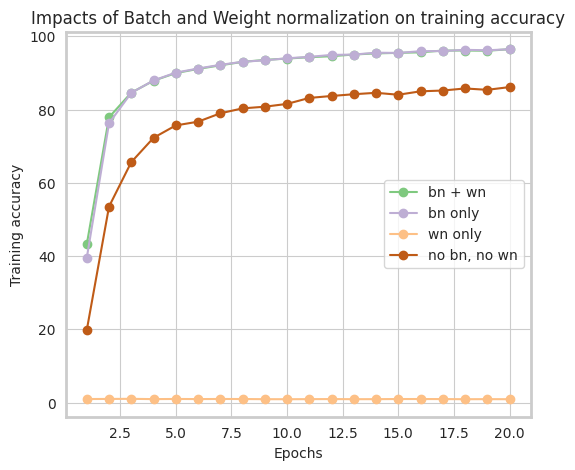

In [85]:
fig, ax = plt.subplots(figsize = (6, 5))
mpl.rcParams['axes.linewidth'] = 2
epochs = np.arange(1, 21, 1)
labels = ["bn + wn", "bn only", "wn only", "no bn, no wn" ]
colors = ["#7fc97f", "#beaed4", "#fdc086", "#bf5b17", "#386cb0", "#f0027f"]

for i, label in enumerate(labels):
    ax.plot(epochs, train_accs_avg[i], "-o", label = label, color = colors[i], linewidth = 1.5)
    
ax.set_xlabel("Epochs")
ax.set_ylabel("Training accuracy")
ax.set_title("Impacts of Batch and Weight normalization on training accuracy")
ax.legend()

plt.savefig("Training accuracy vs epochs wn, bn", dpi = 300)
plt.show()

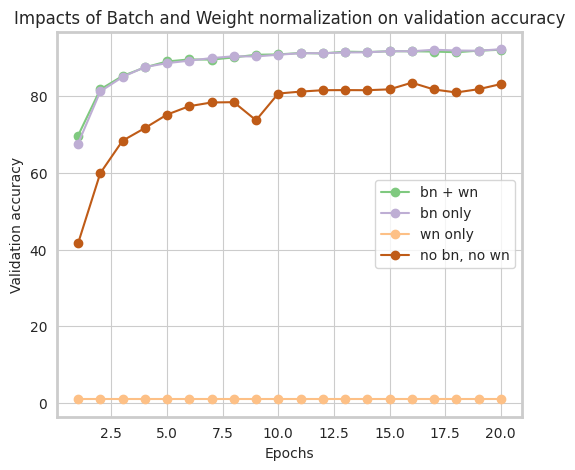

In [84]:
fig, ax = plt.subplots(figsize = (6, 5))
mpl.rcParams['axes.linewidth'] = 2
epochs = np.arange(1, 21, 1)
labels = ["bn + wn", "bn only", "wn only", "no bn, no wn" ]
colors = ["#7fc97f", "#beaed4", "#fdc086", "#bf5b17", "#386cb0", "#f0027f"]

for i, label in enumerate(labels):
    ax.plot(epochs, val_accs_avg[i], "-o", label = label, color = colors[i], linewidth = 1.5)
    
ax.set_xlabel("Epochs")
ax.set_ylabel("Validation accuracy")
ax.set_title("Impacts of Batch and Weight normalization on validation accuracy")
ax.legend()

plt.savefig("Validation accuracy vs epochs wn, bn", dpi = 300)
plt.show()

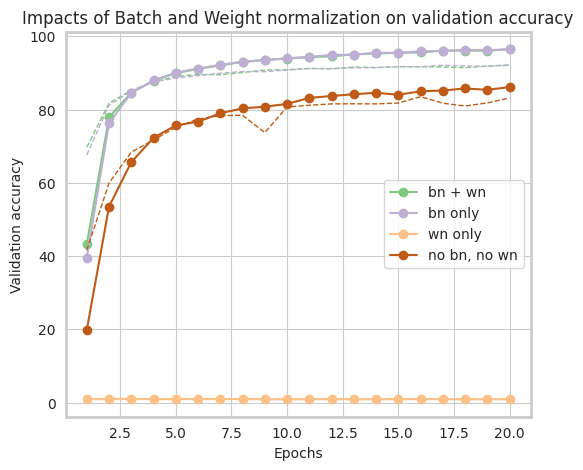

In [86]:
fig, ax = plt.subplots(figsize = (6, 5))
mpl.rcParams['axes.linewidth'] = 2
epochs = np.arange(1, 21, 1)
labels = ["bn + wn", "bn only", "wn only", "no bn, no wn" ]
colors = ["#7fc97f", "#beaed4", "#fdc086", "#bf5b17", "#386cb0", "#f0027f"]

for i, label in enumerate(labels):
    ax.plot(epochs, train_accs_avg[i], "-o", label = label, color = colors[i], linewidth = 1.5)
    ax.plot(epochs, val_accs_avg[i], "--", color = colors[i], linewidth = 1)
    
ax.set_xlabel("Epochs")
ax.set_ylabel("Validation accuracy")
ax.set_title("Impacts of Batch and Weight normalization on validation accuracy")
ax.legend()

plt.savefig("Validation and Training accuracy vs epochs wn, bn", dpi = 300)
plt.show()

In [71]:
train_accs_np = train_accs_avg[:2].numpy()
val_accs_np = val_accs_avg[:2].numpy()
train_losses_np = train_losses_avg[:2].numpy()
val_losses_np = val_losses_avg[:2].numpy()
#print(train_accs_np)
np.savetxt("norm_train_accs.csv", train_accs_np, delimiter = ',')
np.savetxt("norm_val_accs.csv", val_accs_np, delimiter = ',')
np.savetxt("norm_train_losses.csv", train_losses_np, delimiter = ',')
np.savetxt("norm_val_losses.csv", val_losses_np, delimiter = ',')

In [90]:
import torch.optim as optim

# Create a writer to write to Tensorboard
writer = SummaryWriter()

epochs = 20
train_accs = torch.zeros((5, 20))
train_losses = torch.zeros((5, 20))
val_accs = torch.zeros((5, 20))
val_losses = torch.zeros((5, 20))

for i in range(5):
    print("##########################################################")
    print("model with layers :", 32*(2**i))
    model = TCN(20, 200, [(32, 32*(2**i))]*4 + [(64, 256)], [9] * 5, batch_norm=True, weight_norm=True, residual = False, bottleneck=True, groups=8).to(device)
    # Create loss function and optimizer and learning rate scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    for epoch in tqdm(range(epochs)):

        train_avg_loss = 0
        train_correct = 0
        train_total = 0
    
        validation_avg_loss = 0
        validation_correct = 0
        validation_total = 0

        for data, target in train_loader:
            data, target = encode((data.to(device), target.to(device)))
            data = data.squeeze()

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_avg_loss += loss.item()
            _, predicted = output.max(1)
            train_total += target.size(0)
            train_correct += predicted.eq(target).sum().item()
        
        with torch.no_grad():
            for data, target in validation_loader:
                data, target = encode((data.to(device), target.to(device)))
                data = data.squeeze()

                output = model(data)
                loss = criterion(output, target)

                validation_avg_loss += loss.item()
                _, predicted = output.max(1)
                validation_total += target.size(0)
                validation_correct += predicted.eq(target).sum().item()

        train_loss, train_acc = train_avg_loss/len(train_loader), 100 * train_correct / train_total
        validation_loss, validation_acc = validation_avg_loss/len(validation_loader), 100 * validation_correct / validation_total

        print(f"Epoch {epoch} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}")
        print(f"Epoch {epoch} - Validation Loss: {validation_loss:.4f} - Validation Acc: {validation_acc:.2f}")
        
        train_losses[i, epoch] = train_loss
        train_accs[i, epoch] = train_acc
        val_losses[i, epoch] = validation_loss
        val_accs[i, epoch] = validation_acc

        writer.add_scalars("Loss", {'Train': train_loss, 'Validation':validation_loss}, epoch)
        writer.add_scalars('Accuracy', {'Train': train_acc,'Validation':validation_acc} , epoch)

##########################################################
model with layers : 32


  5%|▌         | 1/20 [01:17<24:34, 77.60s/it]

Epoch 0 - Train Loss: 1.9821 - Train Acc: 49.91
Epoch 0 - Validation Loss: 0.8632 - Validation Acc: 76.01


 10%|█         | 2/20 [02:35<23:24, 78.02s/it]

Epoch 1 - Train Loss: 0.6595 - Train Acc: 81.61
Epoch 1 - Validation Loss: 0.5616 - Validation Acc: 84.96


 15%|█▌        | 3/20 [03:54<22:09, 78.21s/it]

Epoch 2 - Train Loss: 0.4524 - Train Acc: 87.16
Epoch 2 - Validation Loss: 0.4671 - Validation Acc: 87.24


 20%|██        | 4/20 [05:12<20:51, 78.20s/it]

Epoch 3 - Train Loss: 0.3465 - Train Acc: 90.19
Epoch 3 - Validation Loss: 0.4184 - Validation Acc: 89.06


 25%|██▌       | 5/20 [06:32<19:40, 78.71s/it]

Epoch 4 - Train Loss: 0.2998 - Train Acc: 91.38
Epoch 4 - Validation Loss: 0.3801 - Validation Acc: 89.66


 30%|███       | 6/20 [07:50<18:18, 78.48s/it]

Epoch 5 - Train Loss: 0.2543 - Train Acc: 92.54
Epoch 5 - Validation Loss: 0.3751 - Validation Acc: 90.08


 35%|███▌      | 7/20 [09:08<17:00, 78.54s/it]

Epoch 6 - Train Loss: 0.2302 - Train Acc: 93.18
Epoch 6 - Validation Loss: 0.3789 - Validation Acc: 90.08


 40%|████      | 8/20 [10:27<15:42, 78.51s/it]

Epoch 7 - Train Loss: 0.2064 - Train Acc: 93.82
Epoch 7 - Validation Loss: 0.3811 - Validation Acc: 90.15


 45%|████▌     | 9/20 [11:45<14:23, 78.51s/it]

Epoch 8 - Train Loss: 0.1875 - Train Acc: 94.33
Epoch 8 - Validation Loss: 0.3344 - Validation Acc: 91.28


 50%|█████     | 10/20 [13:05<13:09, 78.96s/it]

Epoch 9 - Train Loss: 0.1743 - Train Acc: 94.57
Epoch 9 - Validation Loss: 0.3655 - Validation Acc: 90.92


 55%|█████▌    | 11/20 [14:23<11:47, 78.65s/it]

Epoch 10 - Train Loss: 0.1628 - Train Acc: 94.93
Epoch 10 - Validation Loss: 0.3512 - Validation Acc: 91.30


 60%|██████    | 12/20 [15:43<10:31, 79.00s/it]

Epoch 11 - Train Loss: 0.1526 - Train Acc: 95.06
Epoch 11 - Validation Loss: 0.2994 - Validation Acc: 92.26


 65%|██████▌   | 13/20 [17:01<09:11, 78.76s/it]

Epoch 12 - Train Loss: 0.1322 - Train Acc: 95.80
Epoch 12 - Validation Loss: 0.3161 - Validation Acc: 91.65


 70%|███████   | 14/20 [18:19<07:51, 78.60s/it]

Epoch 13 - Train Loss: 0.1283 - Train Acc: 95.88
Epoch 13 - Validation Loss: 0.3255 - Validation Acc: 91.80


 75%|███████▌  | 15/20 [19:36<06:30, 78.05s/it]

Epoch 14 - Train Loss: 0.1287 - Train Acc: 95.86
Epoch 14 - Validation Loss: 0.3635 - Validation Acc: 91.37


 80%|████████  | 16/20 [20:55<05:12, 78.20s/it]

Epoch 15 - Train Loss: 0.1142 - Train Acc: 96.35
Epoch 15 - Validation Loss: 0.3623 - Validation Acc: 91.95


 85%|████████▌ | 17/20 [22:13<03:55, 78.34s/it]

Epoch 16 - Train Loss: 0.1078 - Train Acc: 96.48
Epoch 16 - Validation Loss: 0.3221 - Validation Acc: 92.31


 90%|█████████ | 18/20 [23:33<02:37, 78.81s/it]

Epoch 17 - Train Loss: 0.1011 - Train Acc: 96.70
Epoch 17 - Validation Loss: 0.3144 - Validation Acc: 92.33


 95%|█████████▌| 19/20 [24:53<01:19, 79.18s/it]

Epoch 18 - Train Loss: 0.0964 - Train Acc: 96.86
Epoch 18 - Validation Loss: 0.3538 - Validation Acc: 91.95


100%|██████████| 20/20 [26:13<00:00, 78.66s/it]


Epoch 19 - Train Loss: 0.0981 - Train Acc: 96.76
Epoch 19 - Validation Loss: 0.3373 - Validation Acc: 92.25
##########################################################
model with layers : 64


  5%|▌         | 1/20 [01:18<24:52, 78.55s/it]

Epoch 0 - Train Loss: 1.8366 - Train Acc: 53.38
Epoch 0 - Validation Loss: 0.8603 - Validation Acc: 76.60


 10%|█         | 2/20 [02:35<23:16, 77.58s/it]

Epoch 1 - Train Loss: 0.6486 - Train Acc: 81.89
Epoch 1 - Validation Loss: 0.5588 - Validation Acc: 84.33


 15%|█▌        | 3/20 [03:53<21:59, 77.61s/it]

Epoch 2 - Train Loss: 0.4573 - Train Acc: 87.16
Epoch 2 - Validation Loss: 0.4694 - Validation Acc: 87.69


 20%|██        | 4/20 [05:10<20:41, 77.57s/it]

Epoch 3 - Train Loss: 0.3510 - Train Acc: 90.07
Epoch 3 - Validation Loss: 0.4137 - Validation Acc: 88.82


 25%|██▌       | 5/20 [06:27<19:20, 77.36s/it]

Epoch 4 - Train Loss: 0.2897 - Train Acc: 91.71
Epoch 4 - Validation Loss: 0.3801 - Validation Acc: 89.51


 30%|███       | 6/20 [07:44<18:01, 77.22s/it]

Epoch 5 - Train Loss: 0.2539 - Train Acc: 92.58
Epoch 5 - Validation Loss: 0.3350 - Validation Acc: 91.11


 35%|███▌      | 7/20 [09:00<16:38, 76.84s/it]

Epoch 6 - Train Loss: 0.2169 - Train Acc: 93.56
Epoch 6 - Validation Loss: 0.3310 - Validation Acc: 90.80


 40%|████      | 8/20 [10:18<15:24, 77.04s/it]

Epoch 7 - Train Loss: 0.2083 - Train Acc: 93.67
Epoch 7 - Validation Loss: 0.3647 - Validation Acc: 90.32


 45%|████▌     | 9/20 [11:34<14:04, 76.79s/it]

Epoch 8 - Train Loss: 0.1877 - Train Acc: 94.20
Epoch 8 - Validation Loss: 0.3181 - Validation Acc: 91.62


 50%|█████     | 10/20 [12:50<12:47, 76.70s/it]

Epoch 9 - Train Loss: 0.1591 - Train Acc: 95.03
Epoch 9 - Validation Loss: 0.3109 - Validation Acc: 91.72


 55%|█████▌    | 11/20 [14:07<11:30, 76.76s/it]

Epoch 10 - Train Loss: 0.1535 - Train Acc: 95.16
Epoch 10 - Validation Loss: 0.3005 - Validation Acc: 92.13


 60%|██████    | 12/20 [15:24<10:13, 76.63s/it]

Epoch 11 - Train Loss: 0.1343 - Train Acc: 95.69
Epoch 11 - Validation Loss: 0.3183 - Validation Acc: 92.07


 65%|██████▌   | 13/20 [16:41<08:57, 76.74s/it]

Epoch 12 - Train Loss: 0.1341 - Train Acc: 95.79
Epoch 12 - Validation Loss: 0.3551 - Validation Acc: 90.75


 70%|███████   | 14/20 [17:58<07:41, 76.92s/it]

Epoch 13 - Train Loss: 0.1235 - Train Acc: 96.09
Epoch 13 - Validation Loss: 0.3513 - Validation Acc: 91.82


 75%|███████▌  | 15/20 [19:15<06:25, 77.02s/it]

Epoch 14 - Train Loss: 0.1132 - Train Acc: 96.30
Epoch 14 - Validation Loss: 0.3290 - Validation Acc: 92.34


 80%|████████  | 16/20 [20:32<05:07, 76.94s/it]

Epoch 15 - Train Loss: 0.1030 - Train Acc: 96.67
Epoch 15 - Validation Loss: 0.2943 - Validation Acc: 92.72


 85%|████████▌ | 17/20 [21:48<03:49, 76.56s/it]

Epoch 16 - Train Loss: 0.1109 - Train Acc: 96.44
Epoch 16 - Validation Loss: 0.3074 - Validation Acc: 92.36


 90%|█████████ | 18/20 [23:03<02:32, 76.37s/it]

Epoch 17 - Train Loss: 0.0985 - Train Acc: 96.81
Epoch 17 - Validation Loss: 0.3628 - Validation Acc: 92.00


 95%|█████████▌| 19/20 [24:21<01:16, 76.68s/it]

Epoch 18 - Train Loss: 0.0945 - Train Acc: 96.89
Epoch 18 - Validation Loss: 0.3210 - Validation Acc: 92.37


100%|██████████| 20/20 [25:38<00:00, 76.90s/it]


Epoch 19 - Train Loss: 0.0959 - Train Acc: 96.90
Epoch 19 - Validation Loss: 0.3200 - Validation Acc: 92.81
##########################################################
model with layers : 128


  5%|▌         | 1/20 [01:16<24:07, 76.16s/it]

Epoch 0 - Train Loss: 1.6698 - Train Acc: 57.57
Epoch 0 - Validation Loss: 0.7654 - Validation Acc: 79.46


 10%|█         | 2/20 [02:33<23:02, 76.79s/it]

Epoch 1 - Train Loss: 0.5571 - Train Acc: 84.47
Epoch 1 - Validation Loss: 0.5060 - Validation Acc: 85.82


 15%|█▌        | 3/20 [03:50<21:50, 77.06s/it]

Epoch 2 - Train Loss: 0.3929 - Train Acc: 88.82
Epoch 2 - Validation Loss: 0.4148 - Validation Acc: 88.64


 20%|██        | 4/20 [05:07<20:32, 77.02s/it]

Epoch 3 - Train Loss: 0.3000 - Train Acc: 91.39
Epoch 3 - Validation Loss: 0.3658 - Validation Acc: 90.03


 25%|██▌       | 5/20 [06:23<19:08, 76.55s/it]

Epoch 4 - Train Loss: 0.2590 - Train Acc: 92.41
Epoch 4 - Validation Loss: 0.3911 - Validation Acc: 89.68


 30%|███       | 6/20 [07:38<17:46, 76.21s/it]

Epoch 5 - Train Loss: 0.2243 - Train Acc: 93.34
Epoch 5 - Validation Loss: 0.3313 - Validation Acc: 91.04


 35%|███▌      | 7/20 [08:56<16:35, 76.58s/it]

Epoch 6 - Train Loss: 0.1971 - Train Acc: 94.00
Epoch 6 - Validation Loss: 0.3447 - Validation Acc: 91.02


 40%|████      | 8/20 [10:13<15:19, 76.66s/it]

Epoch 7 - Train Loss: 0.1823 - Train Acc: 94.47
Epoch 7 - Validation Loss: 0.3737 - Validation Acc: 90.56


 45%|████▌     | 9/20 [11:29<14:03, 76.66s/it]

Epoch 8 - Train Loss: 0.1631 - Train Acc: 94.99
Epoch 8 - Validation Loss: 0.3002 - Validation Acc: 91.89


 50%|█████     | 10/20 [12:46<12:45, 76.54s/it]

Epoch 9 - Train Loss: 0.1422 - Train Acc: 95.55
Epoch 9 - Validation Loss: 0.3321 - Validation Acc: 91.64


 55%|█████▌    | 11/20 [14:03<11:32, 76.93s/it]

Epoch 10 - Train Loss: 0.1339 - Train Acc: 95.75
Epoch 10 - Validation Loss: 0.3213 - Validation Acc: 91.49


 60%|██████    | 12/20 [15:21<10:16, 77.07s/it]

Epoch 11 - Train Loss: 0.1288 - Train Acc: 95.88
Epoch 11 - Validation Loss: 0.3293 - Validation Acc: 91.95


 65%|██████▌   | 13/20 [16:39<09:01, 77.34s/it]

Epoch 12 - Train Loss: 0.1137 - Train Acc: 96.44
Epoch 12 - Validation Loss: 0.3147 - Validation Acc: 92.13


 70%|███████   | 14/20 [17:57<07:44, 77.48s/it]

Epoch 13 - Train Loss: 0.1179 - Train Acc: 96.20
Epoch 13 - Validation Loss: 0.3023 - Validation Acc: 92.68


 75%|███████▌  | 15/20 [19:15<06:28, 77.71s/it]

Epoch 14 - Train Loss: 0.1038 - Train Acc: 96.69
Epoch 14 - Validation Loss: 0.3458 - Validation Acc: 92.05


 80%|████████  | 16/20 [20:32<05:10, 77.60s/it]

Epoch 15 - Train Loss: 0.1037 - Train Acc: 96.59
Epoch 15 - Validation Loss: 0.3343 - Validation Acc: 92.42


 85%|████████▌ | 17/20 [21:53<03:55, 78.58s/it]

Epoch 16 - Train Loss: 0.0967 - Train Acc: 96.81
Epoch 16 - Validation Loss: 0.3089 - Validation Acc: 92.77


 90%|█████████ | 18/20 [23:17<02:40, 80.07s/it]

Epoch 17 - Train Loss: 0.0886 - Train Acc: 97.00
Epoch 17 - Validation Loss: 0.3384 - Validation Acc: 92.27


 95%|█████████▌| 19/20 [24:37<01:20, 80.30s/it]

Epoch 18 - Train Loss: 0.0954 - Train Acc: 96.88
Epoch 18 - Validation Loss: 0.3261 - Validation Acc: 93.10


100%|██████████| 20/20 [25:56<00:00, 77.84s/it]


Epoch 19 - Train Loss: 0.0820 - Train Acc: 97.30
Epoch 19 - Validation Loss: 0.3307 - Validation Acc: 92.79
##########################################################
model with layers : 256


  5%|▌         | 1/20 [01:22<26:03, 82.28s/it]

Epoch 0 - Train Loss: 1.8312 - Train Acc: 54.13
Epoch 0 - Validation Loss: 0.7673 - Validation Acc: 79.29


 10%|█         | 2/20 [02:46<25:00, 83.35s/it]

Epoch 1 - Train Loss: 0.5543 - Train Acc: 84.68
Epoch 1 - Validation Loss: 0.5145 - Validation Acc: 86.12


 15%|█▌        | 3/20 [04:09<23:37, 83.40s/it]

Epoch 2 - Train Loss: 0.3931 - Train Acc: 88.85
Epoch 2 - Validation Loss: 0.4082 - Validation Acc: 88.96


 20%|██        | 4/20 [05:31<22:05, 82.85s/it]

Epoch 3 - Train Loss: 0.3023 - Train Acc: 91.30
Epoch 3 - Validation Loss: 0.4032 - Validation Acc: 89.26


 25%|██▌       | 5/20 [06:52<20:30, 82.02s/it]

Epoch 4 - Train Loss: 0.2595 - Train Acc: 92.48
Epoch 4 - Validation Loss: 0.3434 - Validation Acc: 90.59


 30%|███       | 6/20 [08:12<19:01, 81.53s/it]

Epoch 5 - Train Loss: 0.2127 - Train Acc: 93.63
Epoch 5 - Validation Loss: 0.3457 - Validation Acc: 91.21


 35%|███▌      | 7/20 [09:31<17:27, 80.61s/it]

Epoch 6 - Train Loss: 0.1920 - Train Acc: 94.22
Epoch 6 - Validation Loss: 0.3264 - Validation Acc: 91.49


 40%|████      | 8/20 [10:50<16:01, 80.16s/it]

Epoch 7 - Train Loss: 0.1762 - Train Acc: 94.57
Epoch 7 - Validation Loss: 0.3381 - Validation Acc: 91.46


 45%|████▌     | 9/20 [12:11<14:43, 80.29s/it]

Epoch 8 - Train Loss: 0.1565 - Train Acc: 95.15
Epoch 8 - Validation Loss: 0.3189 - Validation Acc: 91.90


 50%|█████     | 10/20 [13:32<13:24, 80.46s/it]

Epoch 9 - Train Loss: 0.1357 - Train Acc: 95.79
Epoch 9 - Validation Loss: 0.2969 - Validation Acc: 92.53


 55%|█████▌    | 11/20 [14:54<12:08, 80.94s/it]

Epoch 10 - Train Loss: 0.1231 - Train Acc: 96.12
Epoch 10 - Validation Loss: 0.3510 - Validation Acc: 91.99


 60%|██████    | 12/20 [16:14<10:45, 80.71s/it]

Epoch 11 - Train Loss: 0.1253 - Train Acc: 96.16
Epoch 11 - Validation Loss: 0.2978 - Validation Acc: 92.53


 65%|██████▌   | 13/20 [17:34<09:24, 80.58s/it]

Epoch 12 - Train Loss: 0.1087 - Train Acc: 96.55
Epoch 12 - Validation Loss: 0.3474 - Validation Acc: 91.84


 70%|███████   | 14/20 [18:55<08:02, 80.49s/it]

Epoch 13 - Train Loss: 0.1030 - Train Acc: 96.75
Epoch 13 - Validation Loss: 0.3179 - Validation Acc: 93.11


 75%|███████▌  | 15/20 [20:15<06:42, 80.48s/it]

Epoch 14 - Train Loss: 0.1006 - Train Acc: 96.76
Epoch 14 - Validation Loss: 0.3043 - Validation Acc: 92.78


 80%|████████  | 16/20 [21:35<05:21, 80.28s/it]

Epoch 15 - Train Loss: 0.0881 - Train Acc: 97.17
Epoch 15 - Validation Loss: 0.2957 - Validation Acc: 92.84


 85%|████████▌ | 17/20 [22:55<04:00, 80.31s/it]

Epoch 16 - Train Loss: 0.0915 - Train Acc: 97.02
Epoch 16 - Validation Loss: 0.3309 - Validation Acc: 92.67


 90%|█████████ | 18/20 [24:15<02:40, 80.11s/it]

Epoch 17 - Train Loss: 0.0853 - Train Acc: 97.22
Epoch 17 - Validation Loss: 0.3365 - Validation Acc: 92.84


 95%|█████████▌| 19/20 [25:35<01:20, 80.21s/it]

Epoch 18 - Train Loss: 0.0758 - Train Acc: 97.55
Epoch 18 - Validation Loss: 0.3100 - Validation Acc: 92.86


100%|██████████| 20/20 [26:55<00:00, 80.80s/it]


Epoch 19 - Train Loss: 0.0669 - Train Acc: 97.82
Epoch 19 - Validation Loss: 0.3210 - Validation Acc: 92.82
##########################################################
model with layers : 512


  5%|▌         | 1/20 [01:21<25:46, 81.41s/it]

Epoch 0 - Train Loss: 1.6520 - Train Acc: 58.37
Epoch 0 - Validation Loss: 0.6627 - Validation Acc: 81.40


 10%|█         | 2/20 [02:40<24:04, 80.23s/it]

Epoch 1 - Train Loss: 0.5158 - Train Acc: 85.32
Epoch 1 - Validation Loss: 0.4708 - Validation Acc: 86.80


 15%|█▌        | 3/20 [03:59<22:35, 79.72s/it]

Epoch 2 - Train Loss: 0.3575 - Train Acc: 89.88
Epoch 2 - Validation Loss: 0.4060 - Validation Acc: 89.21


 20%|██        | 4/20 [05:21<21:27, 80.44s/it]

Epoch 3 - Train Loss: 0.2909 - Train Acc: 91.58
Epoch 3 - Validation Loss: 0.3711 - Validation Acc: 89.80


 25%|██▌       | 5/20 [06:42<20:11, 80.79s/it]

Epoch 4 - Train Loss: 0.2368 - Train Acc: 93.20
Epoch 4 - Validation Loss: 0.3191 - Validation Acc: 91.17


 30%|███       | 6/20 [08:02<18:44, 80.31s/it]

Epoch 5 - Train Loss: 0.1996 - Train Acc: 94.07
Epoch 5 - Validation Loss: 0.3143 - Validation Acc: 91.52


 35%|███▌      | 7/20 [09:23<17:28, 80.63s/it]

Epoch 6 - Train Loss: 0.1778 - Train Acc: 94.59
Epoch 6 - Validation Loss: 0.2997 - Validation Acc: 91.84


 40%|████      | 8/20 [10:43<16:05, 80.45s/it]

Epoch 7 - Train Loss: 0.1552 - Train Acc: 95.22
Epoch 7 - Validation Loss: 0.3251 - Validation Acc: 91.83


 45%|████▌     | 9/20 [12:04<14:45, 80.51s/it]

Epoch 8 - Train Loss: 0.1498 - Train Acc: 95.32
Epoch 8 - Validation Loss: 0.3097 - Validation Acc: 92.11


 50%|█████     | 10/20 [13:26<13:28, 80.89s/it]

Epoch 9 - Train Loss: 0.1391 - Train Acc: 95.64
Epoch 9 - Validation Loss: 0.3295 - Validation Acc: 91.91


 55%|█████▌    | 11/20 [14:46<12:07, 80.84s/it]

Epoch 10 - Train Loss: 0.1245 - Train Acc: 96.06
Epoch 10 - Validation Loss: 0.3026 - Validation Acc: 92.47


 60%|██████    | 12/20 [16:06<10:44, 80.61s/it]

Epoch 11 - Train Loss: 0.1078 - Train Acc: 96.60
Epoch 11 - Validation Loss: 0.3303 - Validation Acc: 91.94


 65%|██████▌   | 13/20 [17:26<09:23, 80.48s/it]

Epoch 12 - Train Loss: 0.1114 - Train Acc: 96.47
Epoch 12 - Validation Loss: 0.3216 - Validation Acc: 91.98


 70%|███████   | 14/20 [18:48<08:04, 80.70s/it]

Epoch 13 - Train Loss: 0.0983 - Train Acc: 96.86
Epoch 13 - Validation Loss: 0.2905 - Validation Acc: 92.96


 75%|███████▌  | 15/20 [20:08<06:43, 80.67s/it]

Epoch 14 - Train Loss: 0.0930 - Train Acc: 96.97
Epoch 14 - Validation Loss: 0.3432 - Validation Acc: 92.84


 80%|████████  | 16/20 [21:30<05:23, 80.91s/it]

Epoch 15 - Train Loss: 0.0910 - Train Acc: 97.14
Epoch 15 - Validation Loss: 0.3213 - Validation Acc: 92.43


 85%|████████▌ | 17/20 [22:52<04:03, 81.17s/it]

Epoch 16 - Train Loss: 0.0868 - Train Acc: 97.13
Epoch 16 - Validation Loss: 0.3055 - Validation Acc: 93.06


 90%|█████████ | 18/20 [24:11<02:41, 80.56s/it]

Epoch 17 - Train Loss: 0.0834 - Train Acc: 97.37
Epoch 17 - Validation Loss: 0.3378 - Validation Acc: 93.16


 95%|█████████▌| 19/20 [25:31<01:20, 80.54s/it]

Epoch 18 - Train Loss: 0.0700 - Train Acc: 97.72
Epoch 18 - Validation Loss: 0.3361 - Validation Acc: 92.76


100%|██████████| 20/20 [26:52<00:00, 80.62s/it]

Epoch 19 - Train Loss: 0.0862 - Train Acc: 97.23
Epoch 19 - Validation Loss: 0.3587 - Validation Acc: 92.46


In [91]:
train_accs_np = train_accs.numpy()
val_accs_np = val_accs.numpy()
train_losses_np = train_losses.numpy()
val_losses_np = val_losses.numpy()
#print(train_accs_np)
np.savetxt("width_train_accs.csv", train_accs_np, delimiter = ', ')
np.savetxt("width_val_accs.csv", val_accs_np, delimiter = ', ')
np.savetxt("width_train_losses.csv", train_losses_np, delimiter = ', ')
np.savetxt("width_val_losses.csv", val_losses_np, delimiter = ', ')

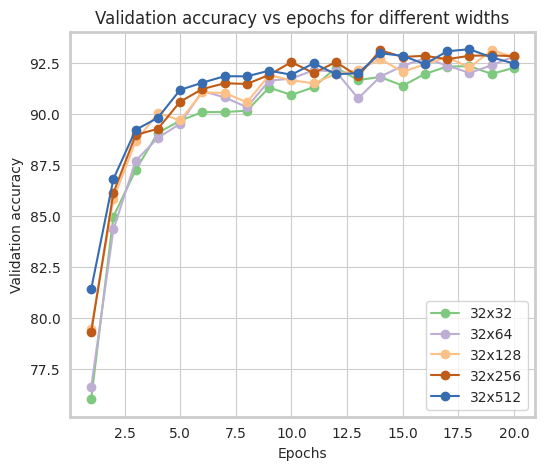

In [97]:
fig, ax = plt.subplots(figsize = (6, 5))
mpl.rcParams['axes.linewidth'] = 2
epochs = np.arange(1, 21, 1)
labels = ["32x32", "32x64", "32x128", "32x256", "32x512"] 
colors = ["#7fc97f", "#beaed4", "#fdc086", "#bf5b17", "#386cb0", "#f0027f"]

for i, label in enumerate(labels):
    ax.plot(epochs, val_accs[i], "-o", label = label, color = colors[i], linewidth = 1.5)
    
ax.set_xlabel("Epochs")
ax.set_ylabel("Validation accuracy")
ax.set_title("Validation accuracy vs epochs for different widths")
ax.legend()

plt.savefig("Validation accuracy vs epochs for different widths", dpi = 300)
plt.show()

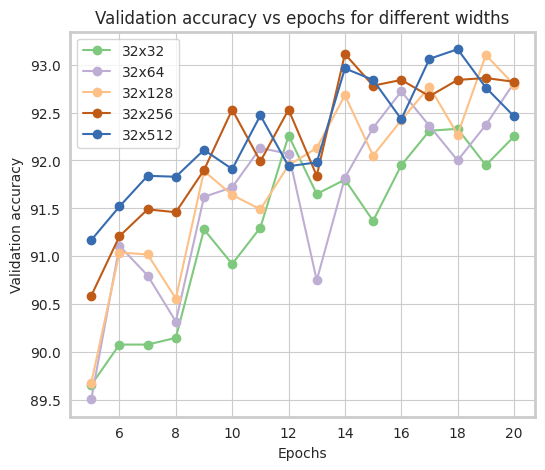

In [98]:
fig, ax = plt.subplots(figsize = (6, 5))
mpl.rcParams['axes.linewidth'] = 2
epochs = np.arange(5, 21, 1)
labels = ["32x32", "32x64", "32x128", "32x256", "32x512"] 
colors = ["#7fc97f", "#beaed4", "#fdc086", "#bf5b17", "#386cb0", "#f0027f"]

for i, label in enumerate(labels):
    ax.plot(epochs, val_accs[i, 4:], "-o", label = label, color = colors[i], linewidth = 1.5)
    
ax.set_xlabel("Epochs")
ax.set_ylabel("Validation accuracy")
ax.set_title("Validation accuracy vs epochs for different widths")
ax.legend()

#plt.savefig("Validation accuracy vs epochs for different widths", dpi = 300)
plt.show()

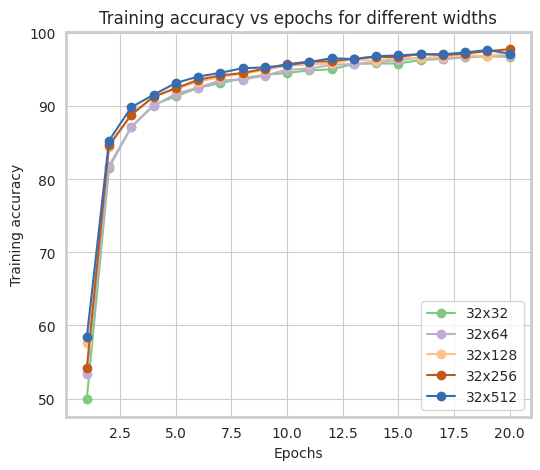

In [99]:
fig, ax = plt.subplots(figsize = (6, 5))
mpl.rcParams['axes.linewidth'] = 2
epochs = np.arange(1, 21, 1)
labels = ["32x32", "32x64", "32x128", "32x256", "32x512"] 
colors = ["#7fc97f", "#beaed4", "#fdc086", "#bf5b17", "#386cb0", "#f0027f"]

for i, label in enumerate(labels):
    ax.plot(epochs, train_accs[i], "-o", label = label, color = colors[i], linewidth = 1.5)
    
ax.set_xlabel("Epochs")
ax.set_ylabel("Training accuracy")
ax.set_title("Training accuracy vs epochs for different widths")
ax.legend()

plt.savefig("Training accuracy vs epochs for different widths", dpi = 300)
plt.show()

In [10]:
sns.set_style("whitegrid")

In [12]:
import torch.optim as optim

# Create a writer to write to Tensorboard
writer = SummaryWriter()

epochs = 20
train_accs = torch.zeros((6, 20))
train_losses = torch.zeros((6, 20))
val_accs = torch.zeros((6, 20))
val_losses = torch.zeros((6, 20))

for i in range(6):
    print("##########################################################")
    print("model with layers : (", 16*(2**i), ", 128)")
    model = TCN(20, 200, [(16*(2**i), 128)]*4 + [(64, 256)], [9] * 5, batch_norm=True, weight_norm=True, residual = False, bottleneck=True, groups=8).to(device)
    # Create loss function and optimizer and learning rate scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    for epoch in tqdm(range(epochs)):

        train_avg_loss = 0
        train_correct = 0
        train_total = 0
    
        validation_avg_loss = 0
        validation_correct = 0
        validation_total = 0

        for data, target in train_loader:
            data, target = encode((data.to(device), target.to(device)))
            data = data.squeeze()

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_avg_loss += loss.item()
            _, predicted = output.max(1)
            train_total += target.size(0)
            train_correct += predicted.eq(target).sum().item()
        
        with torch.no_grad():
            for data, target in validation_loader:
                data, target = encode((data.to(device), target.to(device)))
                data = data.squeeze()

                output = model(data)
                loss = criterion(output, target)

                validation_avg_loss += loss.item()
                _, predicted = output.max(1)
                validation_total += target.size(0)
                validation_correct += predicted.eq(target).sum().item()

        train_loss, train_acc = train_avg_loss/len(train_loader), 100 * train_correct / train_total
        validation_loss, validation_acc = validation_avg_loss/len(validation_loader), 100 * validation_correct / validation_total

        print(f"Epoch {epoch} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}")
        print(f"Epoch {epoch} - Validation Loss: {validation_loss:.4f} - Validation Acc: {validation_acc:.2f}")
        
        train_losses[i, epoch] = train_loss
        train_accs[i, epoch] = train_acc
        val_losses[i, epoch] = validation_loss
        val_accs[i, epoch] = validation_acc

        writer.add_scalars("Loss", {'Train': train_loss, 'Validation':validation_loss}, epoch)
        writer.add_scalars('Accuracy', {'Train': train_acc,'Validation':validation_acc} , epoch)

/opt/conda/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


##########################################################
model with layers : ( 16 , 128)


  5%|▌         | 1/20 [01:19<25:09, 79.43s/it]

Epoch 0 - Train Loss: 2.1551 - Train Acc: 46.45
Epoch 0 - Validation Loss: 0.8309 - Validation Acc: 76.46


 10%|█         | 2/20 [02:38<23:51, 79.50s/it]

Epoch 1 - Train Loss: 0.6386 - Train Acc: 82.37
Epoch 1 - Validation Loss: 0.5104 - Validation Acc: 85.82


 15%|█▌        | 3/20 [03:58<22:34, 79.66s/it]

Epoch 2 - Train Loss: 0.4455 - Train Acc: 87.32
Epoch 2 - Validation Loss: 0.4989 - Validation Acc: 86.17


 20%|██        | 4/20 [05:18<21:16, 79.78s/it]

Epoch 3 - Train Loss: 0.3537 - Train Acc: 89.89
Epoch 3 - Validation Loss: 0.3905 - Validation Acc: 89.17


 25%|██▌       | 5/20 [06:38<19:53, 79.58s/it]

Epoch 4 - Train Loss: 0.3012 - Train Acc: 91.25
Epoch 4 - Validation Loss: 0.3954 - Validation Acc: 89.26


 30%|███       | 6/20 [07:56<18:27, 79.07s/it]

Epoch 5 - Train Loss: 0.2575 - Train Acc: 92.45
Epoch 5 - Validation Loss: 0.3802 - Validation Acc: 89.67


 35%|███▌      | 7/20 [09:15<17:07, 79.07s/it]

Epoch 6 - Train Loss: 0.2293 - Train Acc: 93.13
Epoch 6 - Validation Loss: 0.3495 - Validation Acc: 90.64


 40%|████      | 8/20 [10:35<15:53, 79.43s/it]

Epoch 7 - Train Loss: 0.2083 - Train Acc: 93.71
Epoch 7 - Validation Loss: 0.3435 - Validation Acc: 91.10


 45%|████▌     | 9/20 [11:55<14:37, 79.76s/it]

Epoch 8 - Train Loss: 0.1886 - Train Acc: 94.31
Epoch 8 - Validation Loss: 0.3540 - Validation Acc: 90.82


 50%|█████     | 10/20 [13:16<13:19, 79.99s/it]

Epoch 9 - Train Loss: 0.1821 - Train Acc: 94.32
Epoch 9 - Validation Loss: 0.3514 - Validation Acc: 90.80


 55%|█████▌    | 11/20 [14:36<12:00, 80.07s/it]

Epoch 10 - Train Loss: 0.1638 - Train Acc: 94.92
Epoch 10 - Validation Loss: 0.3600 - Validation Acc: 91.10


 60%|██████    | 12/20 [15:56<10:39, 79.93s/it]

Epoch 11 - Train Loss: 0.1532 - Train Acc: 95.11
Epoch 11 - Validation Loss: 0.3621 - Validation Acc: 90.81


 65%|██████▌   | 13/20 [17:17<09:21, 80.23s/it]

Epoch 12 - Train Loss: 0.1397 - Train Acc: 95.62
Epoch 12 - Validation Loss: 0.3360 - Validation Acc: 91.13


 70%|███████   | 14/20 [18:39<08:04, 80.80s/it]

Epoch 13 - Train Loss: 0.1258 - Train Acc: 96.07
Epoch 13 - Validation Loss: 0.3547 - Validation Acc: 91.26


 75%|███████▌  | 15/20 [20:02<06:47, 81.40s/it]

Epoch 14 - Train Loss: 0.1218 - Train Acc: 96.09
Epoch 14 - Validation Loss: 0.3397 - Validation Acc: 91.40


 80%|████████  | 16/20 [21:22<05:24, 81.24s/it]

Epoch 15 - Train Loss: 0.1123 - Train Acc: 96.34
Epoch 15 - Validation Loss: 0.3724 - Validation Acc: 91.13


 85%|████████▌ | 17/20 [22:43<04:03, 81.17s/it]

Epoch 16 - Train Loss: 0.1155 - Train Acc: 96.28
Epoch 16 - Validation Loss: 0.3426 - Validation Acc: 92.11


 90%|█████████ | 18/20 [24:02<02:40, 80.28s/it]

Epoch 17 - Train Loss: 0.1068 - Train Acc: 96.42
Epoch 17 - Validation Loss: 0.3518 - Validation Acc: 91.66


 95%|█████████▌| 19/20 [25:20<01:19, 79.75s/it]

Epoch 18 - Train Loss: 0.0947 - Train Acc: 96.83
Epoch 18 - Validation Loss: 0.3803 - Validation Acc: 92.10


100%|██████████| 20/20 [26:40<00:00, 80.02s/it]


Epoch 19 - Train Loss: 0.0960 - Train Acc: 96.82
Epoch 19 - Validation Loss: 0.3896 - Validation Acc: 91.67
##########################################################
model with layers : ( 32 , 128)


  5%|▌         | 1/20 [01:21<25:52, 81.71s/it]

Epoch 0 - Train Loss: 1.7466 - Train Acc: 55.68
Epoch 0 - Validation Loss: 0.7974 - Validation Acc: 77.03


 10%|█         | 2/20 [02:42<24:16, 80.92s/it]

Epoch 1 - Train Loss: 0.5985 - Train Acc: 83.37
Epoch 1 - Validation Loss: 0.4984 - Validation Acc: 86.42


 15%|█▌        | 3/20 [04:03<23:00, 81.19s/it]

Epoch 2 - Train Loss: 0.4155 - Train Acc: 88.28
Epoch 2 - Validation Loss: 0.4690 - Validation Acc: 86.80


 20%|██        | 4/20 [05:24<21:38, 81.15s/it]

Epoch 3 - Train Loss: 0.3183 - Train Acc: 91.02
Epoch 3 - Validation Loss: 0.3381 - Validation Acc: 90.33


 25%|██▌       | 5/20 [06:46<20:18, 81.25s/it]

Epoch 4 - Train Loss: 0.2635 - Train Acc: 92.37
Epoch 4 - Validation Loss: 0.3207 - Validation Acc: 91.61


 30%|███       | 6/20 [08:07<18:55, 81.13s/it]

Epoch 5 - Train Loss: 0.2290 - Train Acc: 93.20
Epoch 5 - Validation Loss: 0.3423 - Validation Acc: 91.04


 35%|███▌      | 7/20 [09:28<17:34, 81.12s/it]

Epoch 6 - Train Loss: 0.1998 - Train Acc: 94.00
Epoch 6 - Validation Loss: 0.3338 - Validation Acc: 91.43


 40%|████      | 8/20 [10:48<16:11, 80.93s/it]

Epoch 7 - Train Loss: 0.1779 - Train Acc: 94.58
Epoch 7 - Validation Loss: 0.2988 - Validation Acc: 91.99


 45%|████▌     | 9/20 [12:09<14:51, 81.03s/it]

Epoch 8 - Train Loss: 0.1652 - Train Acc: 95.02
Epoch 8 - Validation Loss: 0.3210 - Validation Acc: 91.89


 50%|█████     | 10/20 [13:30<13:27, 80.78s/it]

Epoch 9 - Train Loss: 0.1508 - Train Acc: 95.45
Epoch 9 - Validation Loss: 0.3450 - Validation Acc: 91.51


 55%|█████▌    | 11/20 [14:50<12:06, 80.76s/it]

Epoch 10 - Train Loss: 0.1386 - Train Acc: 95.68
Epoch 10 - Validation Loss: 0.3336 - Validation Acc: 91.87


 60%|██████    | 12/20 [16:13<10:51, 81.42s/it]

Epoch 11 - Train Loss: 0.1326 - Train Acc: 95.79
Epoch 11 - Validation Loss: 0.3367 - Validation Acc: 91.84


 65%|██████▌   | 13/20 [17:37<09:35, 82.15s/it]

Epoch 12 - Train Loss: 0.1205 - Train Acc: 96.18
Epoch 12 - Validation Loss: 0.3651 - Validation Acc: 91.25


 70%|███████   | 14/20 [18:59<08:12, 82.13s/it]

Epoch 13 - Train Loss: 0.1156 - Train Acc: 96.26
Epoch 13 - Validation Loss: 0.3388 - Validation Acc: 92.04


 75%|███████▌  | 15/20 [20:21<06:50, 82.16s/it]

Epoch 14 - Train Loss: 0.1051 - Train Acc: 96.66
Epoch 14 - Validation Loss: 0.3494 - Validation Acc: 92.55


 80%|████████  | 16/20 [21:44<05:28, 82.20s/it]

Epoch 15 - Train Loss: 0.1068 - Train Acc: 96.46
Epoch 15 - Validation Loss: 0.3131 - Validation Acc: 92.85


 85%|████████▌ | 17/20 [23:07<04:07, 82.43s/it]

Epoch 16 - Train Loss: 0.0982 - Train Acc: 96.77
Epoch 16 - Validation Loss: 0.3481 - Validation Acc: 91.88


 90%|█████████ | 18/20 [24:29<02:44, 82.40s/it]

Epoch 17 - Train Loss: 0.0923 - Train Acc: 96.93
Epoch 17 - Validation Loss: 0.3331 - Validation Acc: 92.38


 95%|█████████▌| 19/20 [25:52<01:22, 82.47s/it]

Epoch 18 - Train Loss: 0.0827 - Train Acc: 97.28
Epoch 18 - Validation Loss: 0.3346 - Validation Acc: 92.49


100%|██████████| 20/20 [27:16<00:00, 81.82s/it]


Epoch 19 - Train Loss: 0.0830 - Train Acc: 97.30
Epoch 19 - Validation Loss: 0.3327 - Validation Acc: 92.48
##########################################################
model with layers : ( 64 , 128)


  5%|▌         | 1/20 [01:27<27:34, 87.06s/it]

Epoch 0 - Train Loss: 1.5734 - Train Acc: 59.92
Epoch 0 - Validation Loss: 0.6637 - Validation Acc: 82.05


 10%|█         | 2/20 [02:53<26:05, 86.95s/it]

Epoch 1 - Train Loss: 0.5242 - Train Acc: 85.38
Epoch 1 - Validation Loss: 0.4621 - Validation Acc: 86.81


 15%|█▌        | 3/20 [04:22<24:47, 87.49s/it]

Epoch 2 - Train Loss: 0.3570 - Train Acc: 89.87
Epoch 2 - Validation Loss: 0.3805 - Validation Acc: 89.95


 20%|██        | 4/20 [05:49<23:18, 87.38s/it]

Epoch 3 - Train Loss: 0.2795 - Train Acc: 91.98
Epoch 3 - Validation Loss: 0.3508 - Validation Acc: 90.44


 25%|██▌       | 5/20 [07:17<21:56, 87.78s/it]

Epoch 4 - Train Loss: 0.2335 - Train Acc: 93.19
Epoch 4 - Validation Loss: 0.3194 - Validation Acc: 91.21


 30%|███       | 6/20 [08:46<20:33, 88.13s/it]

Epoch 5 - Train Loss: 0.2035 - Train Acc: 93.99
Epoch 5 - Validation Loss: 0.3100 - Validation Acc: 91.84


 35%|███▌      | 7/20 [10:14<19:05, 88.10s/it]

Epoch 6 - Train Loss: 0.1737 - Train Acc: 94.78
Epoch 6 - Validation Loss: 0.2988 - Validation Acc: 92.43


 40%|████      | 8/20 [11:42<17:37, 88.15s/it]

Epoch 7 - Train Loss: 0.1604 - Train Acc: 95.07
Epoch 7 - Validation Loss: 0.2979 - Validation Acc: 91.86


 45%|████▌     | 9/20 [13:11<16:11, 88.29s/it]

Epoch 8 - Train Loss: 0.1444 - Train Acc: 95.59
Epoch 8 - Validation Loss: 0.2862 - Validation Acc: 92.64


 50%|█████     | 10/20 [14:39<14:42, 88.30s/it]

Epoch 9 - Train Loss: 0.1279 - Train Acc: 95.97
Epoch 9 - Validation Loss: 0.2814 - Validation Acc: 92.87


 55%|█████▌    | 11/20 [16:08<13:15, 88.43s/it]

Epoch 10 - Train Loss: 0.1207 - Train Acc: 96.29
Epoch 10 - Validation Loss: 0.2851 - Validation Acc: 92.71


 60%|██████    | 12/20 [17:36<11:47, 88.44s/it]

Epoch 11 - Train Loss: 0.1084 - Train Acc: 96.51
Epoch 11 - Validation Loss: 0.2962 - Validation Acc: 92.46


 65%|██████▌   | 13/20 [19:05<10:19, 88.51s/it]

Epoch 12 - Train Loss: 0.1041 - Train Acc: 96.62
Epoch 12 - Validation Loss: 0.2819 - Validation Acc: 93.36


 70%|███████   | 14/20 [20:34<08:51, 88.61s/it]

Epoch 13 - Train Loss: 0.0973 - Train Acc: 96.83
Epoch 13 - Validation Loss: 0.2971 - Validation Acc: 93.09


 75%|███████▌  | 15/20 [22:02<07:22, 88.43s/it]

Epoch 14 - Train Loss: 0.0963 - Train Acc: 97.00
Epoch 14 - Validation Loss: 0.2984 - Validation Acc: 93.20


 80%|████████  | 16/20 [23:30<05:53, 88.32s/it]

Epoch 15 - Train Loss: 0.0858 - Train Acc: 97.20
Epoch 15 - Validation Loss: 0.2935 - Validation Acc: 93.21


 85%|████████▌ | 17/20 [25:00<04:26, 88.79s/it]

Epoch 16 - Train Loss: 0.0811 - Train Acc: 97.31
Epoch 16 - Validation Loss: 0.2849 - Validation Acc: 93.34


 90%|█████████ | 18/20 [26:28<02:57, 88.62s/it]

Epoch 17 - Train Loss: 0.0794 - Train Acc: 97.44
Epoch 17 - Validation Loss: 0.2866 - Validation Acc: 93.86


 95%|█████████▌| 19/20 [27:53<01:27, 87.48s/it]

Epoch 18 - Train Loss: 0.0754 - Train Acc: 97.55
Epoch 18 - Validation Loss: 0.3076 - Validation Acc: 93.11


100%|██████████| 20/20 [29:19<00:00, 87.98s/it]


Epoch 19 - Train Loss: 0.0784 - Train Acc: 97.41
Epoch 19 - Validation Loss: 0.2954 - Validation Acc: 93.49
##########################################################
model with layers : ( 128 , 128)


  5%|▌         | 1/20 [01:24<26:49, 84.71s/it]

Epoch 0 - Train Loss: 1.5585 - Train Acc: 60.45
Epoch 0 - Validation Loss: 0.6574 - Validation Acc: 81.34


 10%|█         | 2/20 [02:48<25:10, 83.92s/it]

Epoch 1 - Train Loss: 0.5074 - Train Acc: 86.03
Epoch 1 - Validation Loss: 0.4539 - Validation Acc: 87.28


 15%|█▌        | 3/20 [04:10<23:34, 83.22s/it]

Epoch 2 - Train Loss: 0.3562 - Train Acc: 90.01
Epoch 2 - Validation Loss: 0.3464 - Validation Acc: 90.28


 20%|██        | 4/20 [05:33<22:07, 82.97s/it]

Epoch 3 - Train Loss: 0.2719 - Train Acc: 92.16
Epoch 3 - Validation Loss: 0.3439 - Validation Acc: 90.88


 25%|██▌       | 5/20 [06:55<20:43, 82.91s/it]

Epoch 4 - Train Loss: 0.2235 - Train Acc: 93.44
Epoch 4 - Validation Loss: 0.3131 - Validation Acc: 91.69


 30%|███       | 6/20 [08:18<19:20, 82.92s/it]

Epoch 5 - Train Loss: 0.1914 - Train Acc: 94.37
Epoch 5 - Validation Loss: 0.3037 - Validation Acc: 91.78


 35%|███▌      | 7/20 [09:41<17:56, 82.83s/it]

Epoch 6 - Train Loss: 0.1724 - Train Acc: 94.70
Epoch 6 - Validation Loss: 0.3193 - Validation Acc: 91.54


 40%|████      | 8/20 [11:04<16:32, 82.75s/it]

Epoch 7 - Train Loss: 0.1503 - Train Acc: 95.37
Epoch 7 - Validation Loss: 0.2880 - Validation Acc: 92.46


 45%|████▌     | 9/20 [12:27<15:11, 82.91s/it]

Epoch 8 - Train Loss: 0.1390 - Train Acc: 95.75
Epoch 8 - Validation Loss: 0.2909 - Validation Acc: 92.62


 50%|█████     | 10/20 [13:49<13:47, 82.74s/it]

Epoch 9 - Train Loss: 0.1274 - Train Acc: 96.06
Epoch 9 - Validation Loss: 0.2764 - Validation Acc: 93.03


 55%|█████▌    | 11/20 [15:13<12:26, 82.97s/it]

Epoch 10 - Train Loss: 0.1079 - Train Acc: 96.60
Epoch 10 - Validation Loss: 0.2933 - Validation Acc: 92.46


 60%|██████    | 12/20 [16:36<11:04, 83.03s/it]

Epoch 11 - Train Loss: 0.1023 - Train Acc: 96.73
Epoch 11 - Validation Loss: 0.2770 - Validation Acc: 92.93


 65%|██████▌   | 13/20 [17:59<09:41, 83.05s/it]

Epoch 12 - Train Loss: 0.0999 - Train Acc: 96.78
Epoch 12 - Validation Loss: 0.2841 - Validation Acc: 93.77


 70%|███████   | 14/20 [19:22<08:18, 83.13s/it]

Epoch 13 - Train Loss: 0.0953 - Train Acc: 96.96
Epoch 13 - Validation Loss: 0.3042 - Validation Acc: 93.00


 75%|███████▌  | 15/20 [20:45<06:55, 83.13s/it]

Epoch 14 - Train Loss: 0.0847 - Train Acc: 97.28
Epoch 14 - Validation Loss: 0.2819 - Validation Acc: 93.77


 80%|████████  | 16/20 [22:08<05:32, 83.14s/it]

Epoch 15 - Train Loss: 0.0872 - Train Acc: 97.20
Epoch 15 - Validation Loss: 0.2970 - Validation Acc: 93.19


 85%|████████▌ | 17/20 [23:31<04:08, 82.93s/it]

Epoch 16 - Train Loss: 0.0729 - Train Acc: 97.67
Epoch 16 - Validation Loss: 0.2723 - Validation Acc: 93.76


 90%|█████████ | 18/20 [24:54<02:46, 83.09s/it]

Epoch 17 - Train Loss: 0.0773 - Train Acc: 97.53
Epoch 17 - Validation Loss: 0.2969 - Validation Acc: 93.39


 95%|█████████▌| 19/20 [26:18<01:23, 83.22s/it]

Epoch 18 - Train Loss: 0.0728 - Train Acc: 97.60
Epoch 18 - Validation Loss: 0.3289 - Validation Acc: 92.99


100%|██████████| 20/20 [27:40<00:00, 83.04s/it]


Epoch 19 - Train Loss: 0.0661 - Train Acc: 97.86
Epoch 19 - Validation Loss: 0.2901 - Validation Acc: 93.66
##########################################################
model with layers : ( 256 , 128)


  5%|▌         | 1/20 [01:22<25:59, 82.08s/it]

Epoch 0 - Train Loss: 1.4631 - Train Acc: 62.60
Epoch 0 - Validation Loss: 0.6521 - Validation Acc: 82.13


 10%|█         | 2/20 [02:44<24:41, 82.30s/it]

Epoch 1 - Train Loss: 0.4853 - Train Acc: 86.44
Epoch 1 - Validation Loss: 0.4241 - Validation Acc: 87.96


 15%|█▌        | 3/20 [04:09<23:42, 83.66s/it]

Epoch 2 - Train Loss: 0.3326 - Train Acc: 90.50
Epoch 2 - Validation Loss: 0.3851 - Validation Acc: 89.26


 20%|██        | 4/20 [05:32<22:15, 83.47s/it]

Epoch 3 - Train Loss: 0.2643 - Train Acc: 92.52
Epoch 3 - Validation Loss: 0.3288 - Validation Acc: 91.05


 25%|██▌       | 5/20 [06:57<20:56, 83.78s/it]

Epoch 4 - Train Loss: 0.2162 - Train Acc: 93.72
Epoch 4 - Validation Loss: 0.2869 - Validation Acc: 92.39


 30%|███       | 6/20 [08:21<19:33, 83.86s/it]

Epoch 5 - Train Loss: 0.1896 - Train Acc: 94.43
Epoch 5 - Validation Loss: 0.3146 - Validation Acc: 91.75


 35%|███▌      | 7/20 [09:46<18:17, 84.44s/it]

Epoch 6 - Train Loss: 0.1627 - Train Acc: 95.03
Epoch 6 - Validation Loss: 0.2830 - Validation Acc: 92.93


 40%|████      | 8/20 [11:10<16:51, 84.28s/it]

Epoch 7 - Train Loss: 0.1380 - Train Acc: 95.73
Epoch 7 - Validation Loss: 0.2909 - Validation Acc: 92.79


 45%|████▌     | 9/20 [12:35<15:26, 84.25s/it]

Epoch 8 - Train Loss: 0.1330 - Train Acc: 95.84
Epoch 8 - Validation Loss: 0.2926 - Validation Acc: 92.38


 50%|█████     | 10/20 [14:00<14:05, 84.50s/it]

Epoch 9 - Train Loss: 0.1223 - Train Acc: 96.12
Epoch 9 - Validation Loss: 0.2765 - Validation Acc: 92.81


 55%|█████▌    | 11/20 [15:24<12:38, 84.32s/it]

Epoch 10 - Train Loss: 0.1104 - Train Acc: 96.56
Epoch 10 - Validation Loss: 0.2969 - Validation Acc: 92.55


 60%|██████    | 12/20 [16:48<11:14, 84.35s/it]

Epoch 11 - Train Loss: 0.0920 - Train Acc: 97.19
Epoch 11 - Validation Loss: 0.2736 - Validation Acc: 93.32


 65%|██████▌   | 13/20 [18:14<09:53, 84.82s/it]

Epoch 12 - Train Loss: 0.0876 - Train Acc: 97.24
Epoch 12 - Validation Loss: 0.2675 - Validation Acc: 93.50


 70%|███████   | 14/20 [19:38<08:27, 84.66s/it]

Epoch 13 - Train Loss: 0.0923 - Train Acc: 97.04
Epoch 13 - Validation Loss: 0.3155 - Validation Acc: 92.88


 75%|███████▌  | 15/20 [21:02<07:02, 84.52s/it]

Epoch 14 - Train Loss: 0.0867 - Train Acc: 97.22
Epoch 14 - Validation Loss: 0.3346 - Validation Acc: 92.78


 80%|████████  | 16/20 [22:25<05:35, 83.94s/it]

Epoch 15 - Train Loss: 0.0800 - Train Acc: 97.39
Epoch 15 - Validation Loss: 0.2775 - Validation Acc: 93.50


 85%|████████▌ | 17/20 [23:49<04:12, 84.06s/it]

Epoch 16 - Train Loss: 0.0651 - Train Acc: 97.89
Epoch 16 - Validation Loss: 0.2854 - Validation Acc: 93.63


 90%|█████████ | 18/20 [25:12<02:47, 83.58s/it]

Epoch 17 - Train Loss: 0.0768 - Train Acc: 97.58
Epoch 17 - Validation Loss: 0.2932 - Validation Acc: 93.26


 95%|█████████▌| 19/20 [26:34<01:23, 83.06s/it]

Epoch 18 - Train Loss: 0.0687 - Train Acc: 97.70
Epoch 18 - Validation Loss: 0.2892 - Validation Acc: 93.36


100%|██████████| 20/20 [27:56<00:00, 83.84s/it]


Epoch 19 - Train Loss: 0.0561 - Train Acc: 98.16
Epoch 19 - Validation Loss: 0.3040 - Validation Acc: 93.94
##########################################################
model with layers : ( 512 , 128)


  5%|▌         | 1/20 [01:26<27:17, 86.16s/it]

Epoch 0 - Train Loss: 1.5194 - Train Acc: 61.10
Epoch 0 - Validation Loss: 0.6370 - Validation Acc: 82.68


 10%|█         | 2/20 [02:52<25:54, 86.38s/it]

Epoch 1 - Train Loss: 0.5120 - Train Acc: 85.86
Epoch 1 - Validation Loss: 0.4751 - Validation Acc: 86.59


 15%|█▌        | 3/20 [04:19<24:33, 86.67s/it]

Epoch 2 - Train Loss: 0.3462 - Train Acc: 90.22
Epoch 2 - Validation Loss: 0.3832 - Validation Acc: 89.83


 20%|██        | 4/20 [05:45<23:02, 86.38s/it]

Epoch 3 - Train Loss: 0.2622 - Train Acc: 92.47
Epoch 3 - Validation Loss: 0.3530 - Validation Acc: 90.21


 25%|██▌       | 5/20 [07:12<21:37, 86.53s/it]

Epoch 4 - Train Loss: 0.2201 - Train Acc: 93.52
Epoch 4 - Validation Loss: 0.3154 - Validation Acc: 91.67


 30%|███       | 6/20 [08:38<20:10, 86.46s/it]

Epoch 5 - Train Loss: 0.1860 - Train Acc: 94.41
Epoch 5 - Validation Loss: 0.2877 - Validation Acc: 92.17


 35%|███▌      | 7/20 [10:05<18:43, 86.45s/it]

Epoch 6 - Train Loss: 0.1520 - Train Acc: 95.39
Epoch 6 - Validation Loss: 0.3022 - Validation Acc: 92.32


 40%|████      | 8/20 [11:31<17:15, 86.28s/it]

Epoch 7 - Train Loss: 0.1492 - Train Acc: 95.41
Epoch 7 - Validation Loss: 0.2587 - Validation Acc: 93.16


 45%|████▌     | 9/20 [12:57<15:49, 86.33s/it]

Epoch 8 - Train Loss: 0.1163 - Train Acc: 96.42
Epoch 8 - Validation Loss: 0.2962 - Validation Acc: 93.04


 50%|█████     | 10/20 [14:22<14:20, 86.05s/it]

Epoch 9 - Train Loss: 0.1120 - Train Acc: 96.46
Epoch 9 - Validation Loss: 0.2767 - Validation Acc: 93.03


 55%|█████▌    | 11/20 [15:49<12:55, 86.20s/it]

Epoch 10 - Train Loss: 0.1051 - Train Acc: 96.70
Epoch 10 - Validation Loss: 0.2744 - Validation Acc: 93.39


 60%|██████    | 12/20 [17:16<11:31, 86.45s/it]

Epoch 11 - Train Loss: 0.0912 - Train Acc: 97.09
Epoch 11 - Validation Loss: 0.2935 - Validation Acc: 93.16


 65%|██████▌   | 13/20 [18:43<10:05, 86.48s/it]

Epoch 12 - Train Loss: 0.0841 - Train Acc: 97.31
Epoch 12 - Validation Loss: 0.2901 - Validation Acc: 92.84


 70%|███████   | 14/20 [20:09<08:39, 86.54s/it]

Epoch 13 - Train Loss: 0.0872 - Train Acc: 97.20
Epoch 13 - Validation Loss: 0.2899 - Validation Acc: 92.98


 75%|███████▌  | 15/20 [21:34<07:10, 86.10s/it]

Epoch 14 - Train Loss: 0.0684 - Train Acc: 97.81
Epoch 14 - Validation Loss: 0.3104 - Validation Acc: 93.12


 80%|████████  | 16/20 [23:00<05:43, 85.89s/it]

Epoch 15 - Train Loss: 0.0804 - Train Acc: 97.42
Epoch 15 - Validation Loss: 0.2901 - Validation Acc: 93.23


 85%|████████▌ | 17/20 [24:26<04:18, 86.03s/it]

Epoch 16 - Train Loss: 0.0666 - Train Acc: 97.82
Epoch 16 - Validation Loss: 0.2843 - Validation Acc: 93.95


 90%|█████████ | 18/20 [25:53<02:52, 86.21s/it]

Epoch 17 - Train Loss: 0.0582 - Train Acc: 98.19
Epoch 17 - Validation Loss: 0.2956 - Validation Acc: 93.34


 95%|█████████▌| 19/20 [27:19<01:26, 86.25s/it]

Epoch 18 - Train Loss: 0.0657 - Train Acc: 97.83
Epoch 18 - Validation Loss: 0.3071 - Validation Acc: 93.64


100%|██████████| 20/20 [28:45<00:00, 86.28s/it]

Epoch 19 - Train Loss: 0.0622 - Train Acc: 98.00
Epoch 19 - Validation Loss: 0.2959 - Validation Acc: 93.39


In [13]:
train_accs_np = train_accs.numpy()
val_accs_np = val_accs.numpy()
train_losses_np = train_losses.numpy()
val_losses_np = val_losses.numpy()
#print(train_accs_np)
np.savetxt("width2_train_accs.csv", train_accs_np, delimiter = ', ')
np.savetxt("width2_val_accs.csv", val_accs_np, delimiter = ', ')
np.savetxt("width2_train_losses.csv", train_losses_np, delimiter = ', ')
np.savetxt("width2_val_losses.csv", val_losses_np, delimiter = ', ')

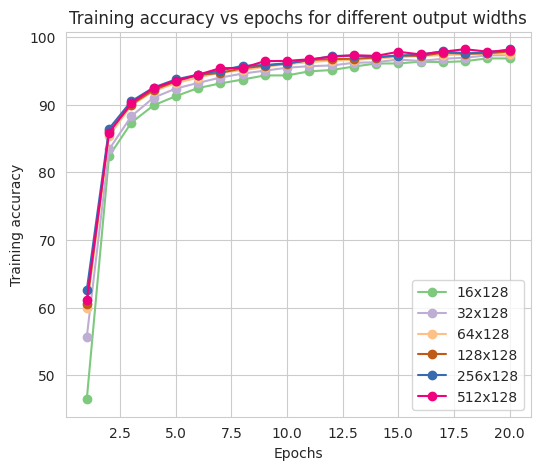

In [14]:
fig, ax = plt.subplots(figsize = (6, 5))
mpl.rcParams['axes.linewidth'] = 2
epochs = np.arange(1, 21, 1)
labels = ["16x128", "32x128", "64x128", "128x128", "256x128", "512x128"] 
colors = ["#7fc97f", "#beaed4", "#fdc086", "#bf5b17", "#386cb0", "#f0027f"]

for i, label in enumerate(labels):
    ax.plot(epochs, train_accs[i], "-o", label = label, color = colors[i], linewidth = 1.5)
    
ax.set_xlabel("Epochs")
ax.set_ylabel("Training accuracy")
ax.set_title("Training accuracy vs epochs for different output widths")
ax.legend()

plt.savefig("Training accuracy vs epochs for different output widths", dpi = 300)
plt.show()

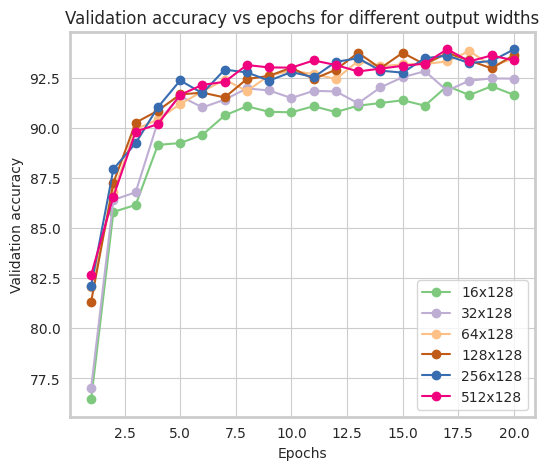

In [15]:
fig, ax = plt.subplots(figsize = (6, 5))
mpl.rcParams['axes.linewidth'] = 2
epochs = np.arange(1, 21, 1)
labels = ["16x128", "32x128", "64x128", "128x128", "256x128", "512x128"] 
colors = ["#7fc97f", "#beaed4", "#fdc086", "#bf5b17", "#386cb0", "#f0027f"]

for i, label in enumerate(labels):
    ax.plot(epochs, val_accs[i], "-o", label = label, color = colors[i], linewidth = 1.5)
    
ax.set_xlabel("Epochs")
ax.set_ylabel("Validation accuracy")
ax.set_title("Validation accuracy vs epochs for different output widths")
ax.legend()

plt.savefig("Validation accuracy vs epochs for different output widths", dpi = 300)
plt.show()

In [9]:
import torch.optim as optim

# Create a writer to write to Tensorboard
writer = SummaryWriter()

epochs = 20
train_accs = torch.zeros((6, 20))
train_losses = torch.zeros((6, 20))
val_accs = torch.zeros((6, 20))
val_losses = torch.zeros((6, 20))

for i in range(6):
    print("##########################################################")
    print("model with layers : (", 16*(2**i))
    model = TCN(20, 200, [(16*(2**i), (16*(2**i)))]*4 + [(64, 256)], [9] * 5, batch_norm=True, weight_norm=True, residual = False, bottleneck=True, groups=8).to(device)
    # Create loss function and optimizer and learning rate scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    for epoch in tqdm(range(epochs)):

        train_avg_loss = 0
        train_correct = 0
        train_total = 0
    
        validation_avg_loss = 0
        validation_correct = 0
        validation_total = 0

        for data, target in train_loader:
            data, target = encode((data.to(device), target.to(device)))
            data = data.squeeze()

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_avg_loss += loss.item()
            _, predicted = output.max(1)
            train_total += target.size(0)
            train_correct += predicted.eq(target).sum().item()
        
        with torch.no_grad():
            for data, target in validation_loader:
                data, target = encode((data.to(device), target.to(device)))
                data = data.squeeze()

                output = model(data)
                loss = criterion(output, target)

                validation_avg_loss += loss.item()
                _, predicted = output.max(1)
                validation_total += target.size(0)
                validation_correct += predicted.eq(target).sum().item()

        train_loss, train_acc = train_avg_loss/len(train_loader), 100 * train_correct / train_total
        validation_loss, validation_acc = validation_avg_loss/len(validation_loader), 100 * validation_correct / validation_total

        print(f"Epoch {epoch} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}")
        print(f"Epoch {epoch} - Validation Loss: {validation_loss:.4f} - Validation Acc: {validation_acc:.2f}")
        
        train_losses[i, epoch] = train_loss
        train_accs[i, epoch] = train_acc
        val_losses[i, epoch] = validation_loss
        val_accs[i, epoch] = validation_acc

        writer.add_scalars("Loss", {'Train': train_loss, 'Validation':validation_loss}, epoch)
        writer.add_scalars('Accuracy', {'Train': train_acc,'Validation':validation_acc} , epoch)

##########################################################
model with layers : ( 16


/opt/conda/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
  5%|▌         | 1/20 [01:22<26:12, 82.75s/it]

Epoch 0 - Train Loss: 2.4740 - Train Acc: 38.00
Epoch 0 - Validation Loss: 1.2999 - Validation Acc: 64.55


 10%|█         | 2/20 [02:42<24:16, 80.89s/it]

Epoch 1 - Train Loss: 0.9596 - Train Acc: 73.51
Epoch 1 - Validation Loss: 0.7728 - Validation Acc: 78.58


 15%|█▌        | 3/20 [03:57<22:14, 78.49s/it]

Epoch 2 - Train Loss: 0.6409 - Train Acc: 82.13
Epoch 2 - Validation Loss: 0.6410 - Validation Acc: 82.30


 20%|██        | 4/20 [05:13<20:36, 77.25s/it]

Epoch 3 - Train Loss: 0.5057 - Train Acc: 85.62
Epoch 3 - Validation Loss: 0.5515 - Validation Acc: 84.68


 25%|██▌       | 5/20 [06:28<19:10, 76.67s/it]

Epoch 4 - Train Loss: 0.4231 - Train Acc: 87.89
Epoch 4 - Validation Loss: 0.4767 - Validation Acc: 86.64


 30%|███       | 6/20 [07:42<17:39, 75.70s/it]

Epoch 5 - Train Loss: 0.3650 - Train Acc: 89.32
Epoch 5 - Validation Loss: 0.4913 - Validation Acc: 86.77


 35%|███▌      | 7/20 [08:56<16:16, 75.11s/it]

Epoch 6 - Train Loss: 0.3353 - Train Acc: 90.10
Epoch 6 - Validation Loss: 0.4678 - Validation Acc: 87.75


 40%|████      | 8/20 [10:15<15:14, 76.23s/it]

Epoch 7 - Train Loss: 0.2885 - Train Acc: 91.34
Epoch 7 - Validation Loss: 0.4734 - Validation Acc: 87.25


 45%|████▌     | 9/20 [11:32<14:00, 76.42s/it]

Epoch 8 - Train Loss: 0.2731 - Train Acc: 91.67
Epoch 8 - Validation Loss: 0.4586 - Validation Acc: 88.58


 50%|█████     | 10/20 [12:51<12:54, 77.46s/it]

Epoch 9 - Train Loss: 0.2496 - Train Acc: 92.34
Epoch 9 - Validation Loss: 0.4496 - Validation Acc: 88.42


 55%|█████▌    | 11/20 [14:11<11:43, 78.15s/it]

Epoch 10 - Train Loss: 0.2328 - Train Acc: 92.86
Epoch 10 - Validation Loss: 0.4661 - Validation Acc: 88.40


 60%|██████    | 12/20 [15:27<10:19, 77.49s/it]

Epoch 11 - Train Loss: 0.2102 - Train Acc: 93.50
Epoch 11 - Validation Loss: 0.4337 - Validation Acc: 89.19


 65%|██████▌   | 13/20 [16:44<09:01, 77.41s/it]

Epoch 12 - Train Loss: 0.2021 - Train Acc: 93.67
Epoch 12 - Validation Loss: 0.4760 - Validation Acc: 88.70


 70%|███████   | 14/20 [18:01<07:43, 77.23s/it]

Epoch 13 - Train Loss: 0.1927 - Train Acc: 93.87
Epoch 13 - Validation Loss: 0.4508 - Validation Acc: 89.63


 75%|███████▌  | 15/20 [19:18<06:25, 77.10s/it]

Epoch 14 - Train Loss: 0.1715 - Train Acc: 94.53
Epoch 14 - Validation Loss: 0.4436 - Validation Acc: 89.07


 80%|████████  | 16/20 [20:33<05:06, 76.60s/it]

Epoch 15 - Train Loss: 0.1638 - Train Acc: 94.68
Epoch 15 - Validation Loss: 0.4627 - Validation Acc: 89.10


 85%|████████▌ | 17/20 [21:49<03:48, 76.20s/it]

Epoch 16 - Train Loss: 0.1599 - Train Acc: 94.77
Epoch 16 - Validation Loss: 0.4746 - Validation Acc: 89.05


 90%|█████████ | 18/20 [23:04<02:32, 76.02s/it]

Epoch 17 - Train Loss: 0.1542 - Train Acc: 95.05
Epoch 17 - Validation Loss: 0.4610 - Validation Acc: 89.62


 95%|█████████▌| 19/20 [24:19<01:15, 75.56s/it]

Epoch 18 - Train Loss: 0.1457 - Train Acc: 95.29
Epoch 18 - Validation Loss: 0.4602 - Validation Acc: 89.85


100%|██████████| 20/20 [25:37<00:00, 76.88s/it]
/opt/conda/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Epoch 19 - Train Loss: 0.1279 - Train Acc: 95.88
Epoch 19 - Validation Loss: 0.4923 - Validation Acc: 88.93
##########################################################
model with layers : ( 32


  5%|▌         | 1/20 [01:20<25:22, 80.12s/it]

Epoch 0 - Train Loss: 1.9657 - Train Acc: 50.14
Epoch 0 - Validation Loss: 0.8985 - Validation Acc: 75.96


 10%|█         | 2/20 [02:38<23:48, 79.38s/it]

Epoch 1 - Train Loss: 0.7032 - Train Acc: 80.27
Epoch 1 - Validation Loss: 0.6440 - Validation Acc: 81.54


 15%|█▌        | 3/20 [03:56<22:15, 78.54s/it]

Epoch 2 - Train Loss: 0.4892 - Train Acc: 85.94
Epoch 2 - Validation Loss: 0.4732 - Validation Acc: 86.79


 20%|██        | 4/20 [05:16<21:02, 78.93s/it]

Epoch 3 - Train Loss: 0.3801 - Train Acc: 89.08
Epoch 3 - Validation Loss: 0.4354 - Validation Acc: 87.59


 25%|██▌       | 5/20 [06:35<19:48, 79.23s/it]

Epoch 4 - Train Loss: 0.3199 - Train Acc: 90.81
Epoch 4 - Validation Loss: 0.4116 - Validation Acc: 88.99


 30%|███       | 6/20 [07:56<18:36, 79.72s/it]

Epoch 5 - Train Loss: 0.2685 - Train Acc: 92.15
Epoch 5 - Validation Loss: 0.3592 - Validation Acc: 90.48


 35%|███▌      | 7/20 [09:16<17:17, 79.82s/it]

Epoch 6 - Train Loss: 0.2356 - Train Acc: 92.92
Epoch 6 - Validation Loss: 0.3473 - Validation Acc: 90.67


 40%|████      | 8/20 [10:36<15:56, 79.73s/it]

Epoch 7 - Train Loss: 0.2159 - Train Acc: 93.48
Epoch 7 - Validation Loss: 0.3325 - Validation Acc: 91.09


 45%|████▌     | 9/20 [11:55<14:36, 79.70s/it]

Epoch 8 - Train Loss: 0.1955 - Train Acc: 94.03
Epoch 8 - Validation Loss: 0.3256 - Validation Acc: 91.77


 50%|█████     | 10/20 [13:14<13:14, 79.49s/it]

Epoch 9 - Train Loss: 0.1742 - Train Acc: 94.66
Epoch 9 - Validation Loss: 0.3392 - Validation Acc: 91.07


 55%|█████▌    | 11/20 [14:34<11:55, 79.51s/it]

Epoch 10 - Train Loss: 0.1720 - Train Acc: 94.70
Epoch 10 - Validation Loss: 0.3273 - Validation Acc: 91.73


 60%|██████    | 12/20 [15:53<10:36, 79.52s/it]

Epoch 11 - Train Loss: 0.1500 - Train Acc: 95.24
Epoch 11 - Validation Loss: 0.3805 - Validation Acc: 90.93


 65%|██████▌   | 13/20 [17:13<09:16, 79.53s/it]

Epoch 12 - Train Loss: 0.1417 - Train Acc: 95.46
Epoch 12 - Validation Loss: 0.3552 - Validation Acc: 90.96


 70%|███████   | 14/20 [18:31<07:54, 79.16s/it]

Epoch 13 - Train Loss: 0.1357 - Train Acc: 95.67
Epoch 13 - Validation Loss: 0.3598 - Validation Acc: 91.33


 75%|███████▌  | 15/20 [19:50<06:36, 79.21s/it]

Epoch 14 - Train Loss: 0.1265 - Train Acc: 95.90
Epoch 14 - Validation Loss: 0.3333 - Validation Acc: 92.06


 80%|████████  | 16/20 [21:09<05:16, 79.11s/it]

Epoch 15 - Train Loss: 0.1131 - Train Acc: 96.30
Epoch 15 - Validation Loss: 0.3582 - Validation Acc: 91.71


 85%|████████▌ | 17/20 [22:31<03:59, 79.94s/it]

Epoch 16 - Train Loss: 0.1159 - Train Acc: 96.27
Epoch 16 - Validation Loss: 0.3575 - Validation Acc: 91.65


 90%|█████████ | 18/20 [23:54<02:41, 80.78s/it]

Epoch 17 - Train Loss: 0.0988 - Train Acc: 96.83
Epoch 17 - Validation Loss: 0.3242 - Validation Acc: 92.32


 95%|█████████▌| 19/20 [25:16<01:21, 81.27s/it]

Epoch 18 - Train Loss: 0.1000 - Train Acc: 96.65
Epoch 18 - Validation Loss: 0.3809 - Validation Acc: 91.49


100%|██████████| 20/20 [26:35<00:00, 79.78s/it]


Epoch 19 - Train Loss: 0.1021 - Train Acc: 96.67
Epoch 19 - Validation Loss: 0.3515 - Validation Acc: 91.97
##########################################################
model with layers : ( 64


  5%|▌         | 1/20 [01:23<26:23, 83.32s/it]

Epoch 0 - Train Loss: 1.7330 - Train Acc: 55.65
Epoch 0 - Validation Loss: 0.8114 - Validation Acc: 77.55


 10%|█         | 2/20 [02:47<25:04, 83.58s/it]

Epoch 1 - Train Loss: 0.5866 - Train Acc: 83.59
Epoch 1 - Validation Loss: 0.4949 - Validation Acc: 86.14


 15%|█▌        | 3/20 [04:11<23:47, 83.95s/it]

Epoch 2 - Train Loss: 0.4045 - Train Acc: 88.65
Epoch 2 - Validation Loss: 0.4175 - Validation Acc: 88.00


 20%|██        | 4/20 [05:35<22:22, 83.89s/it]

Epoch 3 - Train Loss: 0.3147 - Train Acc: 91.00
Epoch 3 - Validation Loss: 0.3563 - Validation Acc: 90.06


 25%|██▌       | 5/20 [06:58<20:53, 83.59s/it]

Epoch 4 - Train Loss: 0.2679 - Train Acc: 92.29
Epoch 4 - Validation Loss: 0.3415 - Validation Acc: 90.73


 30%|███       | 6/20 [08:21<19:26, 83.33s/it]

Epoch 5 - Train Loss: 0.2195 - Train Acc: 93.51
Epoch 5 - Validation Loss: 0.3305 - Validation Acc: 91.18


 35%|███▌      | 7/20 [09:43<17:59, 83.04s/it]

Epoch 6 - Train Loss: 0.1914 - Train Acc: 94.33
Epoch 6 - Validation Loss: 0.3232 - Validation Acc: 91.63


 40%|████      | 8/20 [11:05<16:33, 82.81s/it]

Epoch 7 - Train Loss: 0.1701 - Train Acc: 94.89
Epoch 7 - Validation Loss: 0.3056 - Validation Acc: 92.31


 45%|████▌     | 9/20 [12:28<15:09, 82.66s/it]

Epoch 8 - Train Loss: 0.1570 - Train Acc: 95.20
Epoch 8 - Validation Loss: 0.2967 - Validation Acc: 92.71


 50%|█████     | 10/20 [13:50<13:44, 82.48s/it]

Epoch 9 - Train Loss: 0.1465 - Train Acc: 95.38
Epoch 9 - Validation Loss: 0.2927 - Validation Acc: 92.44


 55%|█████▌    | 11/20 [15:12<12:20, 82.27s/it]

Epoch 10 - Train Loss: 0.1254 - Train Acc: 96.14
Epoch 10 - Validation Loss: 0.2948 - Validation Acc: 92.64


 60%|██████    | 12/20 [16:35<11:00, 82.61s/it]

Epoch 11 - Train Loss: 0.1236 - Train Acc: 96.05
Epoch 11 - Validation Loss: 0.3331 - Validation Acc: 92.27


 65%|██████▌   | 13/20 [17:58<09:39, 82.80s/it]

Epoch 12 - Train Loss: 0.1160 - Train Acc: 96.28
Epoch 12 - Validation Loss: 0.3148 - Validation Acc: 91.92


 70%|███████   | 14/20 [19:22<08:18, 83.11s/it]

Epoch 13 - Train Loss: 0.1083 - Train Acc: 96.55
Epoch 13 - Validation Loss: 0.3259 - Validation Acc: 92.13


 75%|███████▌  | 15/20 [20:46<06:56, 83.28s/it]

Epoch 14 - Train Loss: 0.0989 - Train Acc: 96.77
Epoch 14 - Validation Loss: 0.3287 - Validation Acc: 92.43


 80%|████████  | 16/20 [22:10<05:34, 83.51s/it]

Epoch 15 - Train Loss: 0.0978 - Train Acc: 96.80
Epoch 15 - Validation Loss: 0.3403 - Validation Acc: 92.38


 85%|████████▌ | 17/20 [23:34<04:11, 83.69s/it]

Epoch 16 - Train Loss: 0.0905 - Train Acc: 97.11
Epoch 16 - Validation Loss: 0.3119 - Validation Acc: 92.97


 90%|█████████ | 18/20 [24:57<02:47, 83.57s/it]

Epoch 17 - Train Loss: 0.0834 - Train Acc: 97.29
Epoch 17 - Validation Loss: 0.3070 - Validation Acc: 92.96


 95%|█████████▌| 19/20 [26:22<01:23, 83.84s/it]

Epoch 18 - Train Loss: 0.0897 - Train Acc: 97.02
Epoch 18 - Validation Loss: 0.3345 - Validation Acc: 92.81


100%|██████████| 20/20 [27:45<00:00, 83.28s/it]


Epoch 19 - Train Loss: 0.0833 - Train Acc: 97.28
Epoch 19 - Validation Loss: 0.3143 - Validation Acc: 93.07
##########################################################
model with layers : ( 128


  5%|▌         | 1/20 [01:19<25:12, 79.62s/it]

Epoch 0 - Train Loss: 1.5166 - Train Acc: 61.19
Epoch 0 - Validation Loss: 0.6703 - Validation Acc: 81.08


 10%|█         | 2/20 [02:39<23:58, 79.90s/it]

Epoch 1 - Train Loss: 0.5156 - Train Acc: 85.74
Epoch 1 - Validation Loss: 0.5106 - Validation Acc: 85.94


 15%|█▌        | 3/20 [03:59<22:38, 79.93s/it]

Epoch 2 - Train Loss: 0.3540 - Train Acc: 89.85
Epoch 2 - Validation Loss: 0.4264 - Validation Acc: 87.99


 20%|██        | 4/20 [05:18<21:14, 79.65s/it]

Epoch 3 - Train Loss: 0.2699 - Train Acc: 92.25
Epoch 3 - Validation Loss: 0.2923 - Validation Acc: 92.39


 25%|██▌       | 5/20 [06:38<19:53, 79.58s/it]

Epoch 4 - Train Loss: 0.2196 - Train Acc: 93.63
Epoch 4 - Validation Loss: 0.3163 - Validation Acc: 91.16


 30%|███       | 6/20 [07:56<18:28, 79.19s/it]

Epoch 5 - Train Loss: 0.1901 - Train Acc: 94.36
Epoch 5 - Validation Loss: 0.2938 - Validation Acc: 92.24


 35%|███▌      | 7/20 [09:18<17:19, 79.95s/it]

Epoch 6 - Train Loss: 0.1658 - Train Acc: 95.05
Epoch 6 - Validation Loss: 0.2964 - Validation Acc: 92.25


 40%|████      | 8/20 [10:38<16:00, 80.07s/it]

Epoch 7 - Train Loss: 0.1495 - Train Acc: 95.53
Epoch 7 - Validation Loss: 0.2672 - Validation Acc: 93.18


 45%|████▌     | 9/20 [11:55<14:29, 79.04s/it]

Epoch 8 - Train Loss: 0.1329 - Train Acc: 95.88
Epoch 8 - Validation Loss: 0.2820 - Validation Acc: 92.41


 50%|█████     | 10/20 [13:12<13:04, 78.45s/it]

Epoch 9 - Train Loss: 0.1216 - Train Acc: 96.21
Epoch 9 - Validation Loss: 0.2734 - Validation Acc: 93.04


 55%|█████▌    | 11/20 [14:28<11:38, 77.65s/it]

Epoch 10 - Train Loss: 0.1176 - Train Acc: 96.25
Epoch 10 - Validation Loss: 0.2870 - Validation Acc: 93.22


 60%|██████    | 12/20 [15:44<10:17, 77.24s/it]

Epoch 11 - Train Loss: 0.1080 - Train Acc: 96.60
Epoch 11 - Validation Loss: 0.3095 - Validation Acc: 92.78


 65%|██████▌   | 13/20 [17:01<09:00, 77.19s/it]

Epoch 12 - Train Loss: 0.1005 - Train Acc: 96.79
Epoch 12 - Validation Loss: 0.2807 - Validation Acc: 93.36


 70%|███████   | 14/20 [18:17<07:39, 76.63s/it]

Epoch 13 - Train Loss: 0.0937 - Train Acc: 97.12
Epoch 13 - Validation Loss: 0.2720 - Validation Acc: 93.46


 75%|███████▌  | 15/20 [19:32<06:20, 76.12s/it]

Epoch 14 - Train Loss: 0.0800 - Train Acc: 97.43
Epoch 14 - Validation Loss: 0.2812 - Validation Acc: 93.53


 80%|████████  | 16/20 [20:48<05:04, 76.17s/it]

Epoch 15 - Train Loss: 0.0837 - Train Acc: 97.28
Epoch 15 - Validation Loss: 0.2822 - Validation Acc: 93.35


 85%|████████▌ | 17/20 [22:03<03:47, 75.81s/it]

Epoch 16 - Train Loss: 0.0782 - Train Acc: 97.43
Epoch 16 - Validation Loss: 0.2903 - Validation Acc: 93.37


 90%|█████████ | 18/20 [23:21<02:33, 76.66s/it]

Epoch 17 - Train Loss: 0.0695 - Train Acc: 97.72
Epoch 17 - Validation Loss: 0.2860 - Validation Acc: 93.62


 95%|█████████▌| 19/20 [24:45<01:18, 78.69s/it]

Epoch 18 - Train Loss: 0.0622 - Train Acc: 98.02
Epoch 18 - Validation Loss: 0.2907 - Validation Acc: 93.51


100%|██████████| 20/20 [26:06<00:00, 78.33s/it]


Epoch 19 - Train Loss: 0.0723 - Train Acc: 97.68
Epoch 19 - Validation Loss: 0.2814 - Validation Acc: 93.83
##########################################################
model with layers : ( 256


  5%|▌         | 1/20 [01:19<25:12, 79.62s/it]

Epoch 0 - Train Loss: 1.6057 - Train Acc: 58.61
Epoch 0 - Validation Loss: 0.7200 - Validation Acc: 79.79


 10%|█         | 2/20 [02:41<24:18, 81.03s/it]

Epoch 1 - Train Loss: 0.5492 - Train Acc: 84.69
Epoch 1 - Validation Loss: 0.5007 - Validation Acc: 85.87


 15%|█▌        | 3/20 [04:05<23:20, 82.37s/it]

Epoch 2 - Train Loss: 0.3550 - Train Acc: 90.16
Epoch 2 - Validation Loss: 0.3856 - Validation Acc: 89.82


 20%|██        | 4/20 [05:27<21:56, 82.30s/it]

Epoch 3 - Train Loss: 0.2655 - Train Acc: 92.26
Epoch 3 - Validation Loss: 0.3310 - Validation Acc: 91.40


 25%|██▌       | 5/20 [06:49<20:33, 82.22s/it]

Epoch 4 - Train Loss: 0.2191 - Train Acc: 93.74
Epoch 4 - Validation Loss: 0.3343 - Validation Acc: 91.13


 30%|███       | 6/20 [08:13<19:16, 82.58s/it]

Epoch 5 - Train Loss: 0.1841 - Train Acc: 94.56
Epoch 5 - Validation Loss: 0.2790 - Validation Acc: 92.22


 35%|███▌      | 7/20 [09:35<17:54, 82.65s/it]

Epoch 6 - Train Loss: 0.1580 - Train Acc: 95.25
Epoch 6 - Validation Loss: 0.2886 - Validation Acc: 92.35


 40%|████      | 8/20 [10:58<16:31, 82.59s/it]

Epoch 7 - Train Loss: 0.1452 - Train Acc: 95.56
Epoch 7 - Validation Loss: 0.2914 - Validation Acc: 92.92


 45%|████▌     | 9/20 [12:21<15:10, 82.76s/it]

Epoch 8 - Train Loss: 0.1278 - Train Acc: 96.11
Epoch 8 - Validation Loss: 0.3036 - Validation Acc: 91.99


 50%|█████     | 10/20 [13:45<13:49, 83.00s/it]

Epoch 9 - Train Loss: 0.1147 - Train Acc: 96.43
Epoch 9 - Validation Loss: 0.2625 - Validation Acc: 93.05


 55%|█████▌    | 11/20 [15:05<12:20, 82.26s/it]

Epoch 10 - Train Loss: 0.1038 - Train Acc: 96.72
Epoch 10 - Validation Loss: 0.3036 - Validation Acc: 92.80


 60%|██████    | 12/20 [16:27<10:58, 82.26s/it]

Epoch 11 - Train Loss: 0.1037 - Train Acc: 96.77
Epoch 11 - Validation Loss: 0.2699 - Validation Acc: 93.40


 65%|██████▌   | 13/20 [17:48<09:31, 81.70s/it]

Epoch 12 - Train Loss: 0.0857 - Train Acc: 97.31
Epoch 12 - Validation Loss: 0.2818 - Validation Acc: 93.13


 70%|███████   | 14/20 [19:09<08:09, 81.52s/it]

Epoch 13 - Train Loss: 0.0958 - Train Acc: 96.97
Epoch 13 - Validation Loss: 0.2856 - Validation Acc: 92.99


 75%|███████▌  | 15/20 [20:31<06:48, 81.70s/it]

Epoch 14 - Train Loss: 0.0712 - Train Acc: 97.75
Epoch 14 - Validation Loss: 0.3022 - Validation Acc: 93.17


 80%|████████  | 16/20 [21:53<05:26, 81.64s/it]

Epoch 15 - Train Loss: 0.0745 - Train Acc: 97.63
Epoch 15 - Validation Loss: 0.3051 - Validation Acc: 93.70


 85%|████████▌ | 17/20 [23:15<04:05, 81.81s/it]

Epoch 16 - Train Loss: 0.0778 - Train Acc: 97.49
Epoch 16 - Validation Loss: 0.3019 - Validation Acc: 93.11


 90%|█████████ | 18/20 [24:36<02:43, 81.63s/it]

Epoch 17 - Train Loss: 0.0784 - Train Acc: 97.51
Epoch 17 - Validation Loss: 0.2769 - Validation Acc: 93.25


 95%|█████████▌| 19/20 [25:57<01:21, 81.33s/it]

Epoch 18 - Train Loss: 0.0578 - Train Acc: 98.15
Epoch 18 - Validation Loss: 0.2718 - Validation Acc: 94.04


100%|██████████| 20/20 [27:18<00:00, 81.91s/it]


Epoch 19 - Train Loss: 0.0502 - Train Acc: 98.44
Epoch 19 - Validation Loss: 0.2767 - Validation Acc: 93.67
##########################################################
model with layers : ( 512


  5%|▌         | 1/20 [01:27<27:41, 87.47s/it]

Epoch 0 - Train Loss: 1.9594 - Train Acc: 49.12
Epoch 0 - Validation Loss: 0.9007 - Validation Acc: 74.64


 10%|█         | 2/20 [02:54<26:09, 87.21s/it]

Epoch 1 - Train Loss: 0.6231 - Train Acc: 82.76
Epoch 1 - Validation Loss: 0.5234 - Validation Acc: 85.57


 15%|█▌        | 3/20 [04:21<24:40, 87.10s/it]

Epoch 2 - Train Loss: 0.3968 - Train Acc: 88.71
Epoch 2 - Validation Loss: 0.4350 - Validation Acc: 88.17


 20%|██        | 4/20 [05:49<23:16, 87.31s/it]

Epoch 3 - Train Loss: 0.2961 - Train Acc: 91.61
Epoch 3 - Validation Loss: 0.3631 - Validation Acc: 90.78


 25%|██▌       | 5/20 [07:16<21:50, 87.34s/it]

Epoch 4 - Train Loss: 0.2362 - Train Acc: 93.17
Epoch 4 - Validation Loss: 0.3388 - Validation Acc: 90.81


 30%|███       | 6/20 [08:44<20:24, 87.46s/it]

Epoch 5 - Train Loss: 0.2000 - Train Acc: 94.10
Epoch 5 - Validation Loss: 0.3258 - Validation Acc: 91.36


 35%|███▌      | 7/20 [10:11<18:58, 87.55s/it]

Epoch 6 - Train Loss: 0.1665 - Train Acc: 94.96
Epoch 6 - Validation Loss: 0.2972 - Validation Acc: 92.13


 40%|████      | 8/20 [11:39<17:30, 87.50s/it]

Epoch 7 - Train Loss: 0.1504 - Train Acc: 95.36
Epoch 7 - Validation Loss: 0.2723 - Validation Acc: 92.79


 45%|████▌     | 9/20 [13:05<15:59, 87.24s/it]

Epoch 8 - Train Loss: 0.1194 - Train Acc: 96.32
Epoch 8 - Validation Loss: 0.2922 - Validation Acc: 92.48


 50%|█████     | 10/20 [14:33<14:32, 87.22s/it]

Epoch 9 - Train Loss: 0.1197 - Train Acc: 96.28
Epoch 9 - Validation Loss: 0.2993 - Validation Acc: 93.36


 55%|█████▌    | 11/20 [16:01<13:07, 87.50s/it]

Epoch 10 - Train Loss: 0.1100 - Train Acc: 96.46
Epoch 10 - Validation Loss: 0.2800 - Validation Acc: 93.24


 60%|██████    | 12/20 [17:27<11:37, 87.20s/it]

Epoch 11 - Train Loss: 0.0927 - Train Acc: 97.07
Epoch 11 - Validation Loss: 0.2808 - Validation Acc: 93.18


 65%|██████▌   | 13/20 [18:55<10:10, 87.28s/it]

Epoch 12 - Train Loss: 0.0837 - Train Acc: 97.32
Epoch 12 - Validation Loss: 0.3185 - Validation Acc: 93.02


 70%|███████   | 14/20 [20:22<08:44, 87.41s/it]

Epoch 13 - Train Loss: 0.0923 - Train Acc: 97.03
Epoch 13 - Validation Loss: 0.2990 - Validation Acc: 92.94


 75%|███████▌  | 15/20 [21:50<07:16, 87.31s/it]

Epoch 14 - Train Loss: 0.0666 - Train Acc: 97.84
Epoch 14 - Validation Loss: 0.3102 - Validation Acc: 92.94


 80%|████████  | 16/20 [23:17<05:49, 87.41s/it]

Epoch 15 - Train Loss: 0.0742 - Train Acc: 97.62
Epoch 15 - Validation Loss: 0.3048 - Validation Acc: 93.19


 85%|████████▌ | 17/20 [24:45<04:22, 87.66s/it]

Epoch 16 - Train Loss: 0.0716 - Train Acc: 97.66
Epoch 16 - Validation Loss: 0.3093 - Validation Acc: 93.36


 90%|█████████ | 18/20 [26:12<02:54, 87.30s/it]

Epoch 17 - Train Loss: 0.0709 - Train Acc: 97.67
Epoch 17 - Validation Loss: 0.3246 - Validation Acc: 93.40


 95%|█████████▌| 19/20 [27:39<01:27, 87.23s/it]

Epoch 18 - Train Loss: 0.0630 - Train Acc: 98.01
Epoch 18 - Validation Loss: 0.2931 - Validation Acc: 93.26


100%|██████████| 20/20 [29:09<00:00, 87.49s/it]

Epoch 19 - Train Loss: 0.0599 - Train Acc: 98.01
Epoch 19 - Validation Loss: 0.3176 - Validation Acc: 93.59


In [12]:
train_accs_np = train_accs.numpy()
val_accs_np = val_accs.numpy()
train_losses_np = train_losses.numpy()
val_losses_np = val_losses.numpy()
#print(train_accs_np)
np.savetxt("width3_train_accs.csv", train_accs_np, delimiter = ', ')
np.savetxt("width3_val_accs.csv", val_accs_np, delimiter = ', ')
np.savetxt("width3_train_losses.csv", train_losses_np, delimiter = ', ')
np.savetxt("width3_val_losses.csv", val_losses_np, delimiter = ', ')

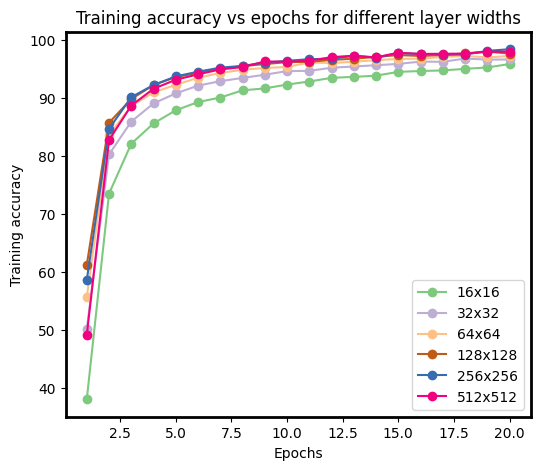

In [14]:
fig, ax = plt.subplots(figsize = (6, 5))
mpl.rcParams['axes.linewidth'] = 2
epochs = np.arange(1, 21, 1)
labels = ["16x16", "32x32", "64x64", "128x128", "256x256", "512x512"] 
colors = ["#7fc97f", "#beaed4", "#fdc086", "#bf5b17", "#386cb0", "#f0027f"]

for i, label in enumerate(labels):
    ax.plot(epochs, train_accs[i], "-o", label = label, color = colors[i], linewidth = 1.5)
    
ax.set_xlabel("Epochs")
ax.set_ylabel("Training accuracy")
ax.set_title("Training accuracy vs epochs for different layer widths")
ax.legend()

plt.savefig("Training accuracy vs epochs for different layer widths", dpi = 300)
plt.show()

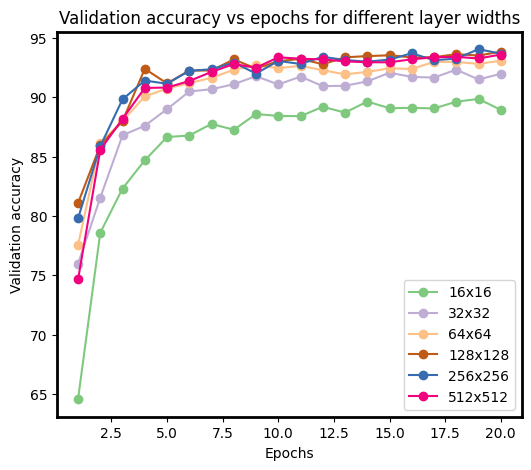

In [15]:
fig, ax = plt.subplots(figsize = (6, 5))
mpl.rcParams['axes.linewidth'] = 2
epochs = np.arange(1, 21, 1)
labels = ["16x16", "32x32", "64x64", "128x128", "256x256", "512x512"] 
colors = ["#7fc97f", "#beaed4", "#fdc086", "#bf5b17", "#386cb0", "#f0027f"]

for i, label in enumerate(labels):
    ax.plot(epochs, val_accs[i], "-o", label = label, color = colors[i], linewidth = 1.5)
    
ax.set_xlabel("Epochs")
ax.set_ylabel("Validation accuracy")
ax.set_title("Validation accuracy vs epochs for different layer widths")
ax.legend()

plt.savefig("Validation accuracy vs epochs for different layer widths", dpi = 300)
plt.show()

In [16]:
import torch.optim as optim

# Create a writer to write to Tensorboard
writer = SummaryWriter()

epochs = 20
train_accs = torch.zeros((6, 20))
train_losses = torch.zeros((6, 20))
val_accs = torch.zeros((6, 20))
val_losses = torch.zeros((6, 20))

for i in range(1):
    print("##########################################################")
    print("model with layers : (", 16*(2**i))
    model = TCN(20, 200, [(256, 256)]*5, [9] * 5, batch_norm=True, weight_norm=True, residual = False, bottleneck=True, groups=8).to(device)
    # Create loss function and optimizer and learning rate scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    for epoch in tqdm(range(epochs)):

        train_avg_loss = 0
        train_correct = 0
        train_total = 0
    
        validation_avg_loss = 0
        validation_correct = 0
        validation_total = 0

        for data, target in train_loader:
            data, target = encode((data.to(device), target.to(device)))
            data = data.squeeze()

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_avg_loss += loss.item()
            _, predicted = output.max(1)
            train_total += target.size(0)
            train_correct += predicted.eq(target).sum().item()
        
        with torch.no_grad():
            for data, target in validation_loader:
                data, target = encode((data.to(device), target.to(device)))
                data = data.squeeze()

                output = model(data)
                loss = criterion(output, target)

                validation_avg_loss += loss.item()
                _, predicted = output.max(1)
                validation_total += target.size(0)
                validation_correct += predicted.eq(target).sum().item()

        train_loss, train_acc = train_avg_loss/len(train_loader), 100 * train_correct / train_total
        validation_loss, validation_acc = validation_avg_loss/len(validation_loader), 100 * validation_correct / validation_total

        print(f"Epoch {epoch} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}")
        print(f"Epoch {epoch} - Validation Loss: {validation_loss:.4f} - Validation Acc: {validation_acc:.2f}")
        
        train_losses[i, epoch] = train_loss
        train_accs[i, epoch] = train_acc
        val_losses[i, epoch] = validation_loss
        val_accs[i, epoch] = validation_acc

        writer.add_scalars("Loss", {'Train': train_loss, 'Validation':validation_loss}, epoch)
        writer.add_scalars('Accuracy', {'Train': train_acc,'Validation':validation_acc} , epoch)

/opt/conda/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


##########################################################
model with layers : ( 16


  5%|▌         | 1/20 [01:21<25:56, 81.92s/it]

Epoch 0 - Train Loss: 1.3353 - Train Acc: 65.35
Epoch 0 - Validation Loss: 0.5612 - Validation Acc: 84.47


 10%|█         | 2/20 [02:42<24:24, 81.34s/it]

Epoch 1 - Train Loss: 0.4137 - Train Acc: 88.25
Epoch 1 - Validation Loss: 0.3804 - Validation Acc: 89.44


 15%|█▌        | 3/20 [04:02<22:50, 80.62s/it]

Epoch 2 - Train Loss: 0.2808 - Train Acc: 91.96
Epoch 2 - Validation Loss: 0.3131 - Validation Acc: 91.42


 20%|██        | 4/20 [05:22<21:28, 80.51s/it]

Epoch 3 - Train Loss: 0.2187 - Train Acc: 93.62
Epoch 3 - Validation Loss: 0.2786 - Validation Acc: 92.29


 25%|██▌       | 5/20 [06:42<20:01, 80.09s/it]

Epoch 4 - Train Loss: 0.1755 - Train Acc: 94.76
Epoch 4 - Validation Loss: 0.3202 - Validation Acc: 91.87


 30%|███       | 6/20 [08:02<18:44, 80.29s/it]

Epoch 5 - Train Loss: 0.1500 - Train Acc: 95.54
Epoch 5 - Validation Loss: 0.2957 - Validation Acc: 92.59


 35%|███▌      | 7/20 [09:23<17:24, 80.34s/it]

Epoch 6 - Train Loss: 0.1325 - Train Acc: 95.90
Epoch 6 - Validation Loss: 0.2555 - Validation Acc: 93.28


 40%|████      | 8/20 [10:43<16:04, 80.37s/it]

Epoch 7 - Train Loss: 0.1053 - Train Acc: 96.72
Epoch 7 - Validation Loss: 0.2858 - Validation Acc: 92.93


 45%|████▌     | 9/20 [12:03<14:42, 80.24s/it]

Epoch 8 - Train Loss: 0.0978 - Train Acc: 96.95
Epoch 8 - Validation Loss: 0.2969 - Validation Acc: 92.68


 50%|█████     | 10/20 [13:24<13:22, 80.25s/it]

Epoch 9 - Train Loss: 0.0938 - Train Acc: 96.98
Epoch 9 - Validation Loss: 0.3009 - Validation Acc: 92.62


 55%|█████▌    | 11/20 [14:43<12:00, 80.06s/it]

Epoch 10 - Train Loss: 0.0910 - Train Acc: 97.14
Epoch 10 - Validation Loss: 0.2596 - Validation Acc: 93.86


 60%|██████    | 12/20 [16:03<10:40, 80.11s/it]

Epoch 11 - Train Loss: 0.0812 - Train Acc: 97.36
Epoch 11 - Validation Loss: 0.2844 - Validation Acc: 93.30


 65%|██████▌   | 13/20 [17:23<09:19, 79.90s/it]

Epoch 12 - Train Loss: 0.0720 - Train Acc: 97.70
Epoch 12 - Validation Loss: 0.3132 - Validation Acc: 93.39


 70%|███████   | 14/20 [18:42<07:58, 79.79s/it]

Epoch 13 - Train Loss: 0.0620 - Train Acc: 97.95
Epoch 13 - Validation Loss: 0.2863 - Validation Acc: 93.62


 75%|███████▌  | 15/20 [20:02<06:38, 79.69s/it]

Epoch 14 - Train Loss: 0.0596 - Train Acc: 98.07
Epoch 14 - Validation Loss: 0.2644 - Validation Acc: 94.33


 80%|████████  | 16/20 [21:21<05:18, 79.63s/it]

Epoch 15 - Train Loss: 0.0600 - Train Acc: 98.15
Epoch 15 - Validation Loss: 0.3090 - Validation Acc: 93.17


 85%|████████▌ | 17/20 [22:41<03:58, 79.66s/it]

Epoch 16 - Train Loss: 0.0615 - Train Acc: 98.01
Epoch 16 - Validation Loss: 0.2890 - Validation Acc: 94.26


 90%|█████████ | 18/20 [24:00<02:38, 79.47s/it]

Epoch 17 - Train Loss: 0.0469 - Train Acc: 98.48
Epoch 17 - Validation Loss: 0.3111 - Validation Acc: 94.19


 95%|█████████▌| 19/20 [25:20<01:19, 79.71s/it]

Epoch 18 - Train Loss: 0.0464 - Train Acc: 98.50
Epoch 18 - Validation Loss: 0.2708 - Validation Acc: 94.03


100%|██████████| 20/20 [26:40<00:00, 80.02s/it]

Epoch 19 - Train Loss: 0.0659 - Train Acc: 97.95
Epoch 19 - Validation Loss: 0.2694 - Validation Acc: 94.26


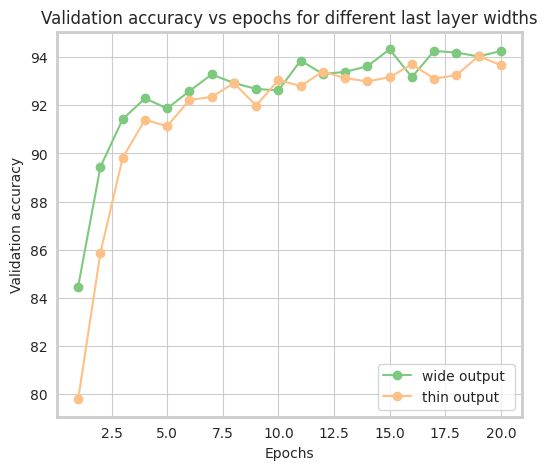

In [21]:
fig, ax = plt.subplots(figsize = (6, 5))
mpl.rcParams['axes.linewidth'] = 2
epochs = np.arange(1, 21, 1)
labels = ["16x16", "32x32", "64x64", "128x128", "256x256", "512x512"] 
colors = ["#7fc97f", "#beaed4", "#fdc086", "#bf5b17", "#386cb0", "#f0027f"]

val_acc_256_thinout = [7.979000091552734375e+01, 8.587000274658203125e+01, 8.981999969482421875e+01, 9.140000152587890625e+01, 9.112999725341796875e+01, 9.222000122070312500e+01, 9.234999847412109375e+01, 9.291999816894531250e+01, 9.198999786376953125e+01, 9.305000305175781250e+01, 9.280000305175781250e+01, 9.340000152587890625e+01, 9.312999725341796875e+01, 9.298999786376953125e+01, 9.316999816894531250e+01, 9.369999694824218750e+01, 9.311000061035156250e+01, 9.325000000000000000e+01, 9.404000091552734375e+01, 9.366999816894531250e+01]

ax.plot(epochs, val_accs[0], "-o", label = "wide output ", color = colors[0], linewidth = 1.5)
ax.plot(epochs, val_acc_256_thinout, "-o", label = "thin output", color = colors[2], linewidth = 1.5)
    
ax.set_xlabel("Epochs")
ax.set_ylabel("Validation accuracy")
ax.set_title("Validation accuracy vs epochs for different last layer widths")
ax.legend()

plt.savefig("Validation accuracy vs epochs for thin or wide output", dpi = 300)
plt.show()

In [22]:
train_accs_np = train_accs.numpy()
val_accs_np = val_accs.numpy()
train_losses_np = train_losses.numpy()
val_losses_np = val_losses.numpy()
#print(train_accs_np)
np.savetxt("width_test_train_accs.csv", train_accs_np, delimiter = ', ')
np.savetxt("width_test_val_accs.csv", val_accs_np, delimiter = ', ')
np.savetxt("width_test_train_losses.csv", train_losses_np, delimiter = ', ')
np.savetxt("width_test_val_losses.csv", val_losses_np, delimiter = ', ')

In [24]:
import torch.optim as optim

# Create a writer to write to Tensorboard
writer = SummaryWriter()

epochs = 20
train_accs = torch.zeros((6, 20))
train_losses = torch.zeros((6, 20))
val_accs = torch.zeros((6, 20))
val_losses = torch.zeros((6, 20))

for i in range(4):
    print("##########################################################")
    print("model with layers : (", 16*(2**i))
    model = TCN(20, 200, [(128*(2**i), 128*(2**i))]*5, [9] * 5, batch_norm=True, weight_norm=True, residual = False, bottleneck=True, groups=8).to(device)
    # Create loss function and optimizer and learning rate scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    for epoch in tqdm(range(epochs)):

        train_avg_loss = 0
        train_correct = 0
        train_total = 0
    
        validation_avg_loss = 0
        validation_correct = 0
        validation_total = 0

        for data, target in train_loader:
            data, target = encode((data.to(device), target.to(device)))
            data = data.squeeze()

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_avg_loss += loss.item()
            _, predicted = output.max(1)
            train_total += target.size(0)
            train_correct += predicted.eq(target).sum().item()
        
        with torch.no_grad():
            for data, target in validation_loader:
                data, target = encode((data.to(device), target.to(device)))
                data = data.squeeze()

                output = model(data)
                loss = criterion(output, target)

                validation_avg_loss += loss.item()
                _, predicted = output.max(1)
                validation_total += target.size(0)
                validation_correct += predicted.eq(target).sum().item()

        train_loss, train_acc = train_avg_loss/len(train_loader), 100 * train_correct / train_total
        validation_loss, validation_acc = validation_avg_loss/len(validation_loader), 100 * validation_correct / validation_total

        print(f"Epoch {epoch} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}")
        print(f"Epoch {epoch} - Validation Loss: {validation_loss:.4f} - Validation Acc: {validation_acc:.2f}")
        
        train_losses[i, epoch] = train_loss
        train_accs[i, epoch] = train_acc
        val_losses[i, epoch] = validation_loss
        val_accs[i, epoch] = validation_acc

        writer.add_scalars("Loss", {'Train': train_loss, 'Validation':validation_loss}, epoch)
        writer.add_scalars('Accuracy', {'Train': train_acc,'Validation':validation_acc} , epoch)

##########################################################
model with layers : ( 16


  5%|▌         | 1/20 [01:20<25:25, 80.29s/it]

Epoch 0 - Train Loss: 1.4338 - Train Acc: 63.75
Epoch 0 - Validation Loss: 0.6444 - Validation Acc: 81.82


 10%|█         | 2/20 [02:41<24:15, 80.88s/it]

Epoch 1 - Train Loss: 0.4651 - Train Acc: 87.06
Epoch 1 - Validation Loss: 0.4867 - Validation Acc: 86.93


 15%|█▌        | 3/20 [04:01<22:47, 80.45s/it]

Epoch 2 - Train Loss: 0.3198 - Train Acc: 90.90
Epoch 2 - Validation Loss: 0.3595 - Validation Acc: 90.11


 20%|██        | 4/20 [05:20<21:19, 79.98s/it]

Epoch 3 - Train Loss: 0.2512 - Train Acc: 92.94
Epoch 3 - Validation Loss: 0.3040 - Validation Acc: 91.72


 25%|██▌       | 5/20 [06:41<20:01, 80.11s/it]

Epoch 4 - Train Loss: 0.2133 - Train Acc: 93.85
Epoch 4 - Validation Loss: 0.3235 - Validation Acc: 90.93


 30%|███       | 6/20 [08:02<18:47, 80.55s/it]

Epoch 5 - Train Loss: 0.1769 - Train Acc: 94.84
Epoch 5 - Validation Loss: 0.2450 - Validation Acc: 93.48


 35%|███▌      | 7/20 [09:23<17:28, 80.69s/it]

Epoch 6 - Train Loss: 0.1564 - Train Acc: 95.33
Epoch 6 - Validation Loss: 0.2751 - Validation Acc: 92.61


 40%|████      | 8/20 [10:46<16:15, 81.29s/it]

Epoch 7 - Train Loss: 0.1428 - Train Acc: 95.61
Epoch 7 - Validation Loss: 0.3466 - Validation Acc: 92.45


 45%|████▌     | 9/20 [12:08<14:59, 81.77s/it]

Epoch 8 - Train Loss: 0.1269 - Train Acc: 96.10
Epoch 8 - Validation Loss: 0.2604 - Validation Acc: 93.48


 50%|█████     | 10/20 [13:31<13:40, 82.03s/it]

Epoch 9 - Train Loss: 0.1177 - Train Acc: 96.32
Epoch 9 - Validation Loss: 0.2788 - Validation Acc: 93.08


 55%|█████▌    | 11/20 [14:53<12:19, 82.16s/it]

Epoch 10 - Train Loss: 0.1095 - Train Acc: 96.65
Epoch 10 - Validation Loss: 0.2599 - Validation Acc: 93.24


 60%|██████    | 12/20 [16:17<11:00, 82.54s/it]

Epoch 11 - Train Loss: 0.0980 - Train Acc: 96.90
Epoch 11 - Validation Loss: 0.2689 - Validation Acc: 93.49


 65%|██████▌   | 13/20 [17:40<09:39, 82.77s/it]

Epoch 12 - Train Loss: 0.0831 - Train Acc: 97.39
Epoch 12 - Validation Loss: 0.2530 - Validation Acc: 93.91


 70%|███████   | 14/20 [19:02<08:15, 82.63s/it]

Epoch 13 - Train Loss: 0.0890 - Train Acc: 97.16
Epoch 13 - Validation Loss: 0.2842 - Validation Acc: 92.84


 75%|███████▌  | 15/20 [20:24<06:52, 82.43s/it]

Epoch 14 - Train Loss: 0.0858 - Train Acc: 97.23
Epoch 14 - Validation Loss: 0.2867 - Validation Acc: 93.24


 80%|████████  | 16/20 [21:46<05:29, 82.28s/it]

Epoch 15 - Train Loss: 0.0836 - Train Acc: 97.20
Epoch 15 - Validation Loss: 0.2785 - Validation Acc: 93.40


 85%|████████▌ | 17/20 [23:09<04:07, 82.45s/it]

Epoch 16 - Train Loss: 0.0716 - Train Acc: 97.68
Epoch 16 - Validation Loss: 0.2716 - Validation Acc: 93.93


 90%|█████████ | 18/20 [24:31<02:44, 82.23s/it]

Epoch 17 - Train Loss: 0.0707 - Train Acc: 97.76
Epoch 17 - Validation Loss: 0.3093 - Validation Acc: 93.77


 95%|█████████▌| 19/20 [25:54<01:22, 82.39s/it]

Epoch 18 - Train Loss: 0.0574 - Train Acc: 98.10
Epoch 18 - Validation Loss: 0.2858 - Validation Acc: 93.65


100%|██████████| 20/20 [27:16<00:00, 81.84s/it]


Epoch 19 - Train Loss: 0.0721 - Train Acc: 97.68
Epoch 19 - Validation Loss: 0.2702 - Validation Acc: 94.00
##########################################################
model with layers : ( 32


  5%|▌         | 1/20 [01:26<27:16, 86.12s/it]

Epoch 0 - Train Loss: 1.4032 - Train Acc: 63.93
Epoch 0 - Validation Loss: 0.5752 - Validation Acc: 84.06


 10%|█         | 2/20 [02:50<25:28, 84.91s/it]

Epoch 1 - Train Loss: 0.4258 - Train Acc: 88.03
Epoch 1 - Validation Loss: 0.3682 - Validation Acc: 89.37


 15%|█▌        | 3/20 [04:13<23:54, 84.39s/it]

Epoch 2 - Train Loss: 0.2878 - Train Acc: 91.80
Epoch 2 - Validation Loss: 0.3469 - Validation Acc: 90.42


 20%|██        | 4/20 [05:38<22:29, 84.32s/it]

Epoch 3 - Train Loss: 0.2149 - Train Acc: 93.65
Epoch 3 - Validation Loss: 0.2823 - Validation Acc: 92.42


 25%|██▌       | 5/20 [07:02<21:03, 84.25s/it]

Epoch 4 - Train Loss: 0.1760 - Train Acc: 94.69
Epoch 4 - Validation Loss: 0.2715 - Validation Acc: 92.54


 30%|███       | 6/20 [08:26<19:39, 84.27s/it]

Epoch 5 - Train Loss: 0.1534 - Train Acc: 95.34
Epoch 5 - Validation Loss: 0.2637 - Validation Acc: 93.17


 35%|███▌      | 7/20 [09:51<18:16, 84.32s/it]

Epoch 6 - Train Loss: 0.1336 - Train Acc: 95.86
Epoch 6 - Validation Loss: 0.2831 - Validation Acc: 92.58


 40%|████      | 8/20 [11:15<16:52, 84.40s/it]

Epoch 7 - Train Loss: 0.1053 - Train Acc: 96.69
Epoch 7 - Validation Loss: 0.2418 - Validation Acc: 94.08


 45%|████▌     | 9/20 [12:37<15:20, 83.71s/it]

Epoch 8 - Train Loss: 0.0974 - Train Acc: 96.94
Epoch 8 - Validation Loss: 0.2596 - Validation Acc: 93.69


 50%|█████     | 10/20 [14:02<13:59, 83.90s/it]

Epoch 9 - Train Loss: 0.0935 - Train Acc: 97.00
Epoch 9 - Validation Loss: 0.2656 - Validation Acc: 94.13


 55%|█████▌    | 11/20 [15:26<12:36, 84.05s/it]

Epoch 10 - Train Loss: 0.0819 - Train Acc: 97.41
Epoch 10 - Validation Loss: 0.2938 - Validation Acc: 93.36


 60%|██████    | 12/20 [16:49<11:10, 83.87s/it]

Epoch 11 - Train Loss: 0.0784 - Train Acc: 97.47
Epoch 11 - Validation Loss: 0.3036 - Validation Acc: 93.01


 65%|██████▌   | 13/20 [18:11<09:41, 83.04s/it]

Epoch 12 - Train Loss: 0.0736 - Train Acc: 97.65
Epoch 12 - Validation Loss: 0.2650 - Validation Acc: 93.77


 70%|███████   | 14/20 [19:33<08:17, 82.94s/it]

Epoch 13 - Train Loss: 0.0693 - Train Acc: 97.80
Epoch 13 - Validation Loss: 0.2905 - Validation Acc: 93.53


 75%|███████▌  | 15/20 [20:58<06:57, 83.58s/it]

Epoch 14 - Train Loss: 0.0716 - Train Acc: 97.67
Epoch 14 - Validation Loss: 0.3195 - Validation Acc: 93.45


 80%|████████  | 16/20 [22:23<05:34, 83.75s/it]

Epoch 15 - Train Loss: 0.0500 - Train Acc: 98.36
Epoch 15 - Validation Loss: 0.2793 - Validation Acc: 94.11


 85%|████████▌ | 17/20 [23:47<04:11, 83.87s/it]

Epoch 16 - Train Loss: 0.0576 - Train Acc: 98.18
Epoch 16 - Validation Loss: 0.2785 - Validation Acc: 93.87


 90%|█████████ | 18/20 [25:11<02:48, 84.04s/it]

Epoch 17 - Train Loss: 0.0519 - Train Acc: 98.31
Epoch 17 - Validation Loss: 0.2879 - Validation Acc: 93.79


 95%|█████████▌| 19/20 [26:36<01:24, 84.28s/it]

Epoch 18 - Train Loss: 0.0486 - Train Acc: 98.45
Epoch 18 - Validation Loss: 0.3122 - Validation Acc: 93.83


100%|██████████| 20/20 [28:00<00:00, 84.05s/it]


Epoch 19 - Train Loss: 0.0547 - Train Acc: 98.25
Epoch 19 - Validation Loss: 0.2797 - Validation Acc: 94.12
##########################################################
model with layers : ( 64


  5%|▌         | 1/20 [01:33<29:28, 93.06s/it]

Epoch 0 - Train Loss: 1.8423 - Train Acc: 52.96
Epoch 0 - Validation Loss: 0.7079 - Validation Acc: 80.36


 10%|█         | 2/20 [03:07<28:07, 93.73s/it]

Epoch 1 - Train Loss: 0.5065 - Train Acc: 85.81
Epoch 1 - Validation Loss: 0.4714 - Validation Acc: 87.52


 15%|█▌        | 3/20 [04:43<26:51, 94.80s/it]

Epoch 2 - Train Loss: 0.3185 - Train Acc: 90.86
Epoch 2 - Validation Loss: 0.3335 - Validation Acc: 91.22


 20%|██        | 4/20 [06:16<25:07, 94.21s/it]

Epoch 3 - Train Loss: 0.2299 - Train Acc: 93.36
Epoch 3 - Validation Loss: 0.3110 - Validation Acc: 91.34


 25%|██▌       | 5/20 [07:49<23:26, 93.78s/it]

Epoch 4 - Train Loss: 0.1812 - Train Acc: 94.66
Epoch 4 - Validation Loss: 0.2711 - Validation Acc: 92.79


 30%|███       | 6/20 [09:22<21:50, 93.61s/it]

Epoch 5 - Train Loss: 0.1452 - Train Acc: 95.57
Epoch 5 - Validation Loss: 0.3047 - Validation Acc: 92.70


 35%|███▌      | 7/20 [10:55<20:12, 93.29s/it]

Epoch 6 - Train Loss: 0.1276 - Train Acc: 96.07
Epoch 6 - Validation Loss: 0.2884 - Validation Acc: 92.85


 40%|████      | 8/20 [12:27<18:32, 92.73s/it]

Epoch 7 - Train Loss: 0.1103 - Train Acc: 96.44
Epoch 7 - Validation Loss: 0.2936 - Validation Acc: 92.62


 45%|████▌     | 9/20 [13:57<16:52, 92.02s/it]

Epoch 8 - Train Loss: 0.1046 - Train Acc: 96.67
Epoch 8 - Validation Loss: 0.2618 - Validation Acc: 93.70


 50%|█████     | 10/20 [15:28<15:17, 91.73s/it]

Epoch 9 - Train Loss: 0.0774 - Train Acc: 97.47
Epoch 9 - Validation Loss: 0.2904 - Validation Acc: 93.19


 55%|█████▌    | 11/20 [17:03<13:54, 92.73s/it]

Epoch 10 - Train Loss: 0.0793 - Train Acc: 97.45
Epoch 10 - Validation Loss: 0.2921 - Validation Acc: 93.42


 60%|██████    | 12/20 [18:37<12:24, 93.06s/it]

Epoch 11 - Train Loss: 0.0808 - Train Acc: 97.40
Epoch 11 - Validation Loss: 0.3178 - Validation Acc: 93.27


 65%|██████▌   | 13/20 [20:09<10:48, 92.69s/it]

Epoch 12 - Train Loss: 0.0647 - Train Acc: 97.93
Epoch 12 - Validation Loss: 0.2855 - Validation Acc: 93.91


 70%|███████   | 14/20 [21:41<09:14, 92.47s/it]

Epoch 13 - Train Loss: 0.0635 - Train Acc: 97.93
Epoch 13 - Validation Loss: 0.2488 - Validation Acc: 94.52


 75%|███████▌  | 15/20 [23:11<07:38, 91.69s/it]

Epoch 14 - Train Loss: 0.0563 - Train Acc: 98.17
Epoch 14 - Validation Loss: 0.2851 - Validation Acc: 93.83


 80%|████████  | 16/20 [24:41<06:04, 91.18s/it]

Epoch 15 - Train Loss: 0.0640 - Train Acc: 97.95
Epoch 15 - Validation Loss: 0.3056 - Validation Acc: 94.29


 85%|████████▌ | 17/20 [26:10<04:31, 90.51s/it]

Epoch 16 - Train Loss: 0.0565 - Train Acc: 98.24
Epoch 16 - Validation Loss: 0.3089 - Validation Acc: 93.38


 90%|█████████ | 18/20 [27:40<03:00, 90.37s/it]

Epoch 17 - Train Loss: 0.0479 - Train Acc: 98.50
Epoch 17 - Validation Loss: 0.3045 - Validation Acc: 93.82


 95%|█████████▌| 19/20 [29:11<01:30, 90.72s/it]

Epoch 18 - Train Loss: 0.0488 - Train Acc: 98.50
Epoch 18 - Validation Loss: 0.3111 - Validation Acc: 93.64


100%|██████████| 20/20 [30:45<00:00, 92.27s/it]

Epoch 19 - Train Loss: 0.0442 - Train Acc: 98.54
Epoch 19 - Validation Loss: 0.2892 - Validation Acc: 94.24
##########################################################
model with layers : ( 128



  5%|▌         | 1/20 [03:23<1:04:17, 203.03s/it]

Epoch 0 - Train Loss: 2.8207 - Train Acc: 30.81
Epoch 0 - Validation Loss: 1.1238 - Validation Acc: 67.59


 10%|█         | 2/20 [06:46<1:00:55, 203.07s/it]

Epoch 1 - Train Loss: 0.7896 - Train Acc: 77.79
Epoch 1 - Validation Loss: 0.6058 - Validation Acc: 83.00


 15%|█▌        | 3/20 [10:09<57:31, 203.03s/it]  

Epoch 2 - Train Loss: 0.4626 - Train Acc: 86.83
Epoch 2 - Validation Loss: 0.4581 - Validation Acc: 87.44


 20%|██        | 4/20 [13:31<54:05, 202.87s/it]

Epoch 3 - Train Loss: 0.3249 - Train Acc: 90.46
Epoch 3 - Validation Loss: 0.3930 - Validation Acc: 89.10


 25%|██▌       | 5/20 [16:54<50:43, 202.93s/it]

Epoch 4 - Train Loss: 0.2509 - Train Acc: 92.55
Epoch 4 - Validation Loss: 0.3346 - Validation Acc: 90.85


 30%|███       | 6/20 [20:18<47:26, 203.30s/it]

Epoch 5 - Train Loss: 0.1926 - Train Acc: 94.23
Epoch 5 - Validation Loss: 0.3277 - Validation Acc: 91.41


 35%|███▌      | 7/20 [23:42<44:03, 203.35s/it]

Epoch 6 - Train Loss: 0.1653 - Train Acc: 94.95
Epoch 6 - Validation Loss: 0.3016 - Validation Acc: 91.95


 40%|████      | 8/20 [27:05<40:41, 203.43s/it]

Epoch 7 - Train Loss: 0.1344 - Train Acc: 95.81
Epoch 7 - Validation Loss: 0.3099 - Validation Acc: 92.51


 45%|████▌     | 9/20 [30:29<37:17, 203.41s/it]

Epoch 8 - Train Loss: 0.1266 - Train Acc: 96.04
Epoch 8 - Validation Loss: 0.2931 - Validation Acc: 92.60


 50%|█████     | 10/20 [33:52<33:53, 203.37s/it]

Epoch 9 - Train Loss: 0.1063 - Train Acc: 96.59
Epoch 9 - Validation Loss: 0.3168 - Validation Acc: 92.49


 55%|█████▌    | 11/20 [37:16<30:32, 203.58s/it]

Epoch 10 - Train Loss: 0.0999 - Train Acc: 96.88
Epoch 10 - Validation Loss: 0.3205 - Validation Acc: 92.47


 60%|██████    | 12/20 [40:40<27:08, 203.59s/it]

Epoch 11 - Train Loss: 0.0905 - Train Acc: 97.12
Epoch 11 - Validation Loss: 0.3342 - Validation Acc: 92.37


 65%|██████▌   | 13/20 [44:03<23:44, 203.50s/it]

Epoch 12 - Train Loss: 0.0813 - Train Acc: 97.36
Epoch 12 - Validation Loss: 0.3505 - Validation Acc: 92.49


 70%|███████   | 14/20 [47:26<20:20, 203.39s/it]

Epoch 13 - Train Loss: 0.0715 - Train Acc: 97.75
Epoch 13 - Validation Loss: 0.2897 - Validation Acc: 93.54


 75%|███████▌  | 15/20 [50:49<16:55, 203.12s/it]

Epoch 14 - Train Loss: 0.0692 - Train Acc: 97.82
Epoch 14 - Validation Loss: 0.3352 - Validation Acc: 92.72


 80%|████████  | 16/20 [54:11<13:31, 202.99s/it]

Epoch 15 - Train Loss: 0.0632 - Train Acc: 98.02
Epoch 15 - Validation Loss: 0.3749 - Validation Acc: 92.53


 85%|████████▌ | 17/20 [57:34<10:08, 202.78s/it]

Epoch 16 - Train Loss: 0.0684 - Train Acc: 97.85
Epoch 16 - Validation Loss: 0.3324 - Validation Acc: 93.35


 90%|█████████ | 18/20 [1:00:56<06:45, 202.61s/it]

Epoch 17 - Train Loss: 0.0534 - Train Acc: 98.31
Epoch 17 - Validation Loss: 0.3259 - Validation Acc: 93.16


 95%|█████████▌| 19/20 [1:04:19<03:22, 202.66s/it]

Epoch 18 - Train Loss: 0.0532 - Train Acc: 98.23
Epoch 18 - Validation Loss: 0.3441 - Validation Acc: 93.81


100%|██████████| 20/20 [1:07:41<00:00, 203.05s/it]

Epoch 19 - Train Loss: 0.0587 - Train Acc: 98.13
Epoch 19 - Validation Loss: 0.3260 - Validation Acc: 93.34


In [25]:
train_accs_np = train_accs.numpy()
val_accs_np = val_accs.numpy()
train_losses_np = train_losses.numpy()
val_losses_np = val_losses.numpy()
#print(train_accs_np)
np.savetxt("width_5_train_accs.csv", train_accs_np, delimiter = ', ')
np.savetxt("width_5_val_accs.csv", val_accs_np, delimiter = ', ')
np.savetxt("width_5_train_losses.csv", train_losses_np, delimiter = ', ')
np.savetxt("width_5_val_losses.csv", val_losses_np, delimiter = ', ')

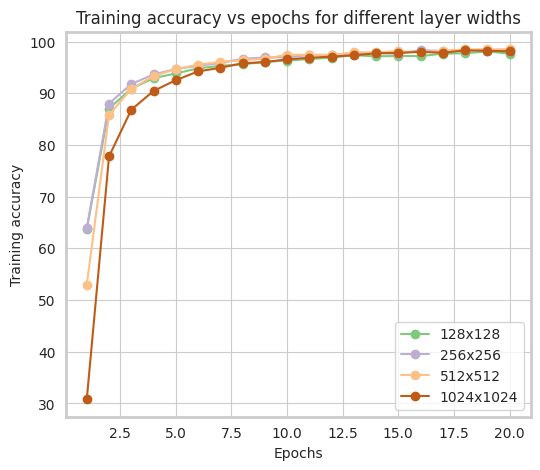

In [26]:
fig, ax = plt.subplots(figsize = (6, 5))
mpl.rcParams['axes.linewidth'] = 2
epochs = np.arange(1, 21, 1)
labels = ["128x128", "256x256", "512x512", "1024x1024"] 
colors = ["#7fc97f", "#beaed4", "#fdc086", "#bf5b17", "#386cb0", "#f0027f"]

for i, label in enumerate(labels):
    ax.plot(epochs, train_accs[i], "-o", label = label, color = colors[i], linewidth = 1.5)
    
ax.set_xlabel("Epochs")
ax.set_ylabel("Training accuracy")
ax.set_title("Training accuracy vs epochs for different layer widths")
ax.legend()

plt.savefig("Training accuracy vs epochs for different 5 layer widths", dpi = 300)
plt.show()

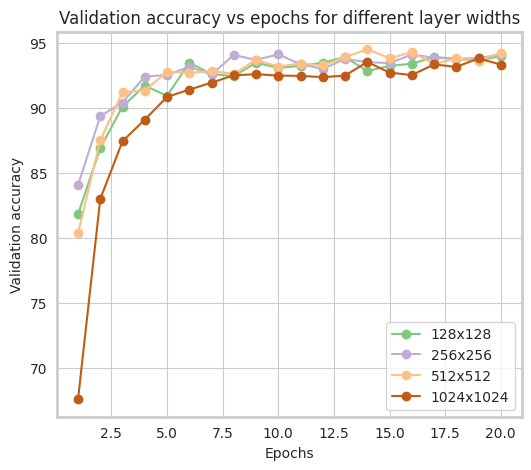

In [27]:
fig, ax = plt.subplots(figsize = (6, 5))
mpl.rcParams['axes.linewidth'] = 2
epochs = np.arange(1, 21, 1)
labels = ["128x128", "256x256", "512x512", "1024x1024"] 
colors = ["#7fc97f", "#beaed4", "#fdc086", "#bf5b17", "#386cb0", "#f0027f"]

for i, label in enumerate(labels):
    ax.plot(epochs, val_accs[i], "-o", label = label, color = colors[i], linewidth = 1.5)
    
ax.set_xlabel("Epochs")
ax.set_ylabel("Validation accuracy")
ax.set_title("Validation accuracy vs epochs for different layer widths")
ax.legend()

plt.savefig("Validation accuracy vs epochs for different 5 layer widths", dpi = 300)
plt.show()

In [28]:
import torch.optim as optim

# Create a writer to write to Tensorboard
writer = SummaryWriter()

epochs = 20
train_accs = torch.zeros((5, 20))
train_losses = torch.zeros((5, 20))
val_accs = torch.zeros((5, 20))
val_losses = torch.zeros((5, 20))

for i in range(5):
    print("##########################################################")
    print("model with groups : ", 2**(i+1))
    model = TCN(20, 200, [(32, 64)]*4 + [(64, 256)], [9] * 5, batch_norm=True, weight_norm=True, residual = False, bottleneck=True, groups=2**(i+1)).to(device)
    # Create loss function and optimizer and learning rate scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    for epoch in tqdm(range(epochs)):

        train_avg_loss = 0
        train_correct = 0
        train_total = 0
    
        validation_avg_loss = 0
        validation_correct = 0
        validation_total = 0

        for data, target in train_loader:
            data, target = encode((data.to(device), target.to(device)))
            data = data.squeeze()

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_avg_loss += loss.item()
            _, predicted = output.max(1)
            train_total += target.size(0)
            train_correct += predicted.eq(target).sum().item()
        
        with torch.no_grad():
            for data, target in validation_loader:
                data, target = encode((data.to(device), target.to(device)))
                data = data.squeeze()

                output = model(data)
                loss = criterion(output, target)

                validation_avg_loss += loss.item()
                _, predicted = output.max(1)
                validation_total += target.size(0)
                validation_correct += predicted.eq(target).sum().item()

        train_loss, train_acc = train_avg_loss/len(train_loader), 100 * train_correct / train_total
        validation_loss, validation_acc = validation_avg_loss/len(validation_loader), 100 * validation_correct / validation_total

        print(f"Epoch {epoch} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}")
        print(f"Epoch {epoch} - Validation Loss: {validation_loss:.4f} - Validation Acc: {validation_acc:.2f}")
        
        train_losses[i, epoch] = train_loss
        train_accs[i, epoch] = train_acc
        val_losses[i, epoch] = validation_loss
        val_accs[i, epoch] = validation_acc

        writer.add_scalars("Loss", {'Train': train_loss, 'Validation':validation_loss}, epoch)
        writer.add_scalars('Accuracy', {'Train': train_acc,'Validation':validation_acc} , epoch)

##########################################################
model with groups :  2


  5%|▌         | 1/20 [01:14<23:38, 74.67s/it]

Epoch 0 - Train Loss: 1.8590 - Train Acc: 52.94
Epoch 0 - Validation Loss: 0.9074 - Validation Acc: 74.76


 10%|█         | 2/20 [02:28<22:15, 74.21s/it]

Epoch 1 - Train Loss: 0.6634 - Train Acc: 81.51
Epoch 1 - Validation Loss: 0.5799 - Validation Acc: 83.73


 15%|█▌        | 3/20 [03:42<20:58, 74.01s/it]

Epoch 2 - Train Loss: 0.4530 - Train Acc: 87.28
Epoch 2 - Validation Loss: 0.4680 - Validation Acc: 87.44


 20%|██        | 4/20 [04:56<19:45, 74.11s/it]

Epoch 3 - Train Loss: 0.3583 - Train Acc: 89.61
Epoch 3 - Validation Loss: 0.4263 - Validation Acc: 88.37


 25%|██▌       | 5/20 [06:10<18:28, 73.92s/it]

Epoch 4 - Train Loss: 0.2967 - Train Acc: 91.40
Epoch 4 - Validation Loss: 0.4178 - Validation Acc: 88.91


 30%|███       | 6/20 [07:24<17:14, 73.89s/it]

Epoch 5 - Train Loss: 0.2620 - Train Acc: 92.26
Epoch 5 - Validation Loss: 0.3650 - Validation Acc: 89.91


 35%|███▌      | 7/20 [08:38<16:03, 74.09s/it]

Epoch 6 - Train Loss: 0.2241 - Train Acc: 93.30
Epoch 6 - Validation Loss: 0.3616 - Validation Acc: 90.29


 40%|████      | 8/20 [09:51<14:46, 73.87s/it]

Epoch 7 - Train Loss: 0.2047 - Train Acc: 93.88
Epoch 7 - Validation Loss: 0.3348 - Validation Acc: 90.95


 45%|████▌     | 9/20 [11:06<13:35, 74.14s/it]

Epoch 8 - Train Loss: 0.1872 - Train Acc: 94.28
Epoch 8 - Validation Loss: 0.3080 - Validation Acc: 91.45


 50%|█████     | 10/20 [12:21<12:24, 74.49s/it]

Epoch 9 - Train Loss: 0.1671 - Train Acc: 94.87
Epoch 9 - Validation Loss: 0.3279 - Validation Acc: 91.29


 55%|█████▌    | 11/20 [13:35<11:08, 74.26s/it]

Epoch 10 - Train Loss: 0.1517 - Train Acc: 95.26
Epoch 10 - Validation Loss: 0.3622 - Validation Acc: 91.20


 60%|██████    | 12/20 [14:49<09:53, 74.17s/it]

Epoch 11 - Train Loss: 0.1464 - Train Acc: 95.32
Epoch 11 - Validation Loss: 0.3618 - Validation Acc: 90.86


 65%|██████▌   | 13/20 [16:03<08:39, 74.15s/it]

Epoch 12 - Train Loss: 0.1332 - Train Acc: 95.76
Epoch 12 - Validation Loss: 0.3568 - Validation Acc: 91.37


 70%|███████   | 14/20 [17:18<07:26, 74.36s/it]

Epoch 13 - Train Loss: 0.1250 - Train Acc: 95.99
Epoch 13 - Validation Loss: 0.3503 - Validation Acc: 91.67


 75%|███████▌  | 15/20 [18:31<06:09, 73.94s/it]

Epoch 14 - Train Loss: 0.1205 - Train Acc: 96.11
Epoch 14 - Validation Loss: 0.3957 - Validation Acc: 91.62


 80%|████████  | 16/20 [19:44<04:53, 73.50s/it]

Epoch 15 - Train Loss: 0.1120 - Train Acc: 96.41
Epoch 15 - Validation Loss: 0.3559 - Validation Acc: 91.65


 85%|████████▌ | 17/20 [20:57<03:40, 73.44s/it]

Epoch 16 - Train Loss: 0.1124 - Train Acc: 96.41
Epoch 16 - Validation Loss: 0.3162 - Validation Acc: 92.23


 90%|█████████ | 18/20 [22:09<02:26, 73.06s/it]

Epoch 17 - Train Loss: 0.0993 - Train Acc: 96.79
Epoch 17 - Validation Loss: 0.3415 - Validation Acc: 92.16


 95%|█████████▌| 19/20 [23:21<01:12, 72.83s/it]

Epoch 18 - Train Loss: 0.0927 - Train Acc: 97.03
Epoch 18 - Validation Loss: 0.3895 - Validation Acc: 91.29


100%|██████████| 20/20 [24:34<00:00, 73.71s/it]


Epoch 19 - Train Loss: 0.0998 - Train Acc: 96.71
Epoch 19 - Validation Loss: 0.3562 - Validation Acc: 92.44
##########################################################
model with groups :  4


  5%|▌         | 1/20 [01:15<23:54, 75.50s/it]

Epoch 0 - Train Loss: 1.8468 - Train Acc: 53.33
Epoch 0 - Validation Loss: 0.7936 - Validation Acc: 77.92


 10%|█         | 2/20 [02:30<22:30, 75.01s/it]

Epoch 1 - Train Loss: 0.5924 - Train Acc: 83.46
Epoch 1 - Validation Loss: 0.5161 - Validation Acc: 85.76


 15%|█▌        | 3/20 [03:45<21:14, 74.96s/it]

Epoch 2 - Train Loss: 0.4135 - Train Acc: 88.19
Epoch 2 - Validation Loss: 0.4362 - Validation Acc: 88.06


 20%|██        | 4/20 [05:00<20:01, 75.06s/it]

Epoch 3 - Train Loss: 0.3139 - Train Acc: 90.99
Epoch 3 - Validation Loss: 0.3473 - Validation Acc: 90.25


 25%|██▌       | 5/20 [06:15<18:45, 75.03s/it]

Epoch 4 - Train Loss: 0.2627 - Train Acc: 92.30
Epoch 4 - Validation Loss: 0.3794 - Validation Acc: 90.03


 30%|███       | 6/20 [07:30<17:29, 74.95s/it]

Epoch 5 - Train Loss: 0.2349 - Train Acc: 93.04
Epoch 5 - Validation Loss: 0.3664 - Validation Acc: 89.74


 35%|███▌      | 7/20 [08:44<16:12, 74.82s/it]

Epoch 6 - Train Loss: 0.2073 - Train Acc: 93.77
Epoch 6 - Validation Loss: 0.3592 - Validation Acc: 90.00


 40%|████      | 8/20 [09:59<14:58, 74.85s/it]

Epoch 7 - Train Loss: 0.1871 - Train Acc: 94.33
Epoch 7 - Validation Loss: 0.3234 - Validation Acc: 91.48


 45%|████▌     | 9/20 [11:14<13:42, 74.77s/it]

Epoch 8 - Train Loss: 0.1696 - Train Acc: 94.82
Epoch 8 - Validation Loss: 0.3398 - Validation Acc: 91.01


 50%|█████     | 10/20 [12:28<12:26, 74.63s/it]

Epoch 9 - Train Loss: 0.1516 - Train Acc: 95.22
Epoch 9 - Validation Loss: 0.3236 - Validation Acc: 91.55


 55%|█████▌    | 11/20 [13:43<11:13, 74.78s/it]

Epoch 10 - Train Loss: 0.1508 - Train Acc: 95.28
Epoch 10 - Validation Loss: 0.3198 - Validation Acc: 91.67


 60%|██████    | 12/20 [14:58<09:57, 74.73s/it]

Epoch 11 - Train Loss: 0.1372 - Train Acc: 95.72
Epoch 11 - Validation Loss: 0.3175 - Validation Acc: 91.83


 65%|██████▌   | 13/20 [16:12<08:43, 74.76s/it]

Epoch 12 - Train Loss: 0.1274 - Train Acc: 95.91
Epoch 12 - Validation Loss: 0.3325 - Validation Acc: 91.91


 70%|███████   | 14/20 [17:28<07:29, 74.85s/it]

Epoch 13 - Train Loss: 0.1290 - Train Acc: 95.86
Epoch 13 - Validation Loss: 0.3382 - Validation Acc: 92.28


 75%|███████▌  | 15/20 [18:42<06:13, 74.61s/it]

Epoch 14 - Train Loss: 0.1035 - Train Acc: 96.66
Epoch 14 - Validation Loss: 0.3278 - Validation Acc: 92.58


 80%|████████  | 16/20 [19:56<04:58, 74.53s/it]

Epoch 15 - Train Loss: 0.1031 - Train Acc: 96.62
Epoch 15 - Validation Loss: 0.3271 - Validation Acc: 92.39


 85%|████████▌ | 17/20 [21:11<03:44, 74.71s/it]

Epoch 16 - Train Loss: 0.1069 - Train Acc: 96.52
Epoch 16 - Validation Loss: 0.3587 - Validation Acc: 91.86


 90%|█████████ | 18/20 [22:25<02:29, 74.51s/it]

Epoch 17 - Train Loss: 0.1045 - Train Acc: 96.62
Epoch 17 - Validation Loss: 0.3663 - Validation Acc: 91.90


 95%|█████████▌| 19/20 [23:39<01:14, 74.41s/it]

Epoch 18 - Train Loss: 0.0852 - Train Acc: 97.21
Epoch 18 - Validation Loss: 0.3411 - Validation Acc: 92.35


100%|██████████| 20/20 [24:54<00:00, 74.74s/it]


Epoch 19 - Train Loss: 0.0799 - Train Acc: 97.37
Epoch 19 - Validation Loss: 0.3506 - Validation Acc: 92.52
##########################################################
model with groups :  8


  5%|▌         | 1/20 [01:14<23:26, 74.04s/it]

Epoch 0 - Train Loss: 2.0349 - Train Acc: 49.18
Epoch 0 - Validation Loss: 0.9027 - Validation Acc: 73.76


 10%|█         | 2/20 [02:29<22:23, 74.62s/it]

Epoch 1 - Train Loss: 0.6301 - Train Acc: 82.38
Epoch 1 - Validation Loss: 0.5488 - Validation Acc: 85.31


 15%|█▌        | 3/20 [03:43<21:04, 74.36s/it]

Epoch 2 - Train Loss: 0.4344 - Train Acc: 87.67
Epoch 2 - Validation Loss: 0.4492 - Validation Acc: 87.90


 20%|██        | 4/20 [04:57<19:50, 74.43s/it]

Epoch 3 - Train Loss: 0.3359 - Train Acc: 90.24
Epoch 3 - Validation Loss: 0.3924 - Validation Acc: 89.31


 25%|██▌       | 5/20 [06:12<18:36, 74.40s/it]

Epoch 4 - Train Loss: 0.2793 - Train Acc: 91.91
Epoch 4 - Validation Loss: 0.3936 - Validation Acc: 90.10


 30%|███       | 6/20 [07:27<17:26, 74.76s/it]

Epoch 5 - Train Loss: 0.2399 - Train Acc: 93.01
Epoch 5 - Validation Loss: 0.3553 - Validation Acc: 90.50


 35%|███▌      | 7/20 [08:42<16:11, 74.71s/it]

Epoch 6 - Train Loss: 0.2075 - Train Acc: 93.88
Epoch 6 - Validation Loss: 0.3491 - Validation Acc: 90.85


 40%|████      | 8/20 [09:56<14:54, 74.51s/it]

Epoch 7 - Train Loss: 0.1955 - Train Acc: 94.04
Epoch 7 - Validation Loss: 0.3536 - Validation Acc: 91.10


 45%|████▌     | 9/20 [11:10<13:38, 74.41s/it]

Epoch 8 - Train Loss: 0.1748 - Train Acc: 94.74
Epoch 8 - Validation Loss: 0.3426 - Validation Acc: 91.41


 50%|█████     | 10/20 [12:25<12:25, 74.57s/it]

Epoch 9 - Train Loss: 0.1604 - Train Acc: 95.00
Epoch 9 - Validation Loss: 0.3134 - Validation Acc: 91.88


 55%|█████▌    | 11/20 [13:40<11:12, 74.68s/it]

Epoch 10 - Train Loss: 0.1408 - Train Acc: 95.58
Epoch 10 - Validation Loss: 0.3412 - Validation Acc: 91.25


 60%|██████    | 12/20 [14:53<09:55, 74.41s/it]

Epoch 11 - Train Loss: 0.1375 - Train Acc: 95.63
Epoch 11 - Validation Loss: 0.3254 - Validation Acc: 91.85


 65%|██████▌   | 13/20 [16:09<08:42, 74.62s/it]

Epoch 12 - Train Loss: 0.1299 - Train Acc: 95.95
Epoch 12 - Validation Loss: 0.3194 - Validation Acc: 92.34


 70%|███████   | 14/20 [17:23<07:27, 74.58s/it]

Epoch 13 - Train Loss: 0.1150 - Train Acc: 96.31
Epoch 13 - Validation Loss: 0.3276 - Validation Acc: 92.45


 75%|███████▌  | 15/20 [18:37<06:12, 74.44s/it]

Epoch 14 - Train Loss: 0.1212 - Train Acc: 96.06
Epoch 14 - Validation Loss: 0.3498 - Validation Acc: 92.43


 80%|████████  | 16/20 [19:52<04:57, 74.47s/it]

Epoch 15 - Train Loss: 0.1123 - Train Acc: 96.32
Epoch 15 - Validation Loss: 0.3539 - Validation Acc: 92.24


 85%|████████▌ | 17/20 [21:06<03:43, 74.38s/it]

Epoch 16 - Train Loss: 0.1005 - Train Acc: 96.78
Epoch 16 - Validation Loss: 0.3347 - Validation Acc: 92.20


 90%|█████████ | 18/20 [22:20<02:28, 74.33s/it]

Epoch 17 - Train Loss: 0.1003 - Train Acc: 96.74
Epoch 17 - Validation Loss: 0.3441 - Validation Acc: 92.24


 95%|█████████▌| 19/20 [23:35<01:14, 74.56s/it]

Epoch 18 - Train Loss: 0.0933 - Train Acc: 96.96
Epoch 18 - Validation Loss: 0.3692 - Validation Acc: 91.83


100%|██████████| 20/20 [24:50<00:00, 74.55s/it]


Epoch 19 - Train Loss: 0.0917 - Train Acc: 96.95
Epoch 19 - Validation Loss: 0.3451 - Validation Acc: 92.61
##########################################################
model with groups :  16


  5%|▌         | 1/20 [01:12<23:00, 72.66s/it]

Epoch 0 - Train Loss: 2.0713 - Train Acc: 47.85
Epoch 0 - Validation Loss: 0.9118 - Validation Acc: 74.55


 10%|█         | 2/20 [02:25<21:54, 73.05s/it]

Epoch 1 - Train Loss: 0.6852 - Train Acc: 80.71
Epoch 1 - Validation Loss: 0.6074 - Validation Acc: 82.63


 15%|█▌        | 3/20 [03:39<20:47, 73.38s/it]

Epoch 2 - Train Loss: 0.4659 - Train Acc: 86.82
Epoch 2 - Validation Loss: 0.5001 - Validation Acc: 85.92


 20%|██        | 4/20 [04:52<19:29, 73.09s/it]

Epoch 3 - Train Loss: 0.3632 - Train Acc: 89.61
Epoch 3 - Validation Loss: 0.4244 - Validation Acc: 88.33


 25%|██▌       | 5/20 [06:05<18:14, 72.99s/it]

Epoch 4 - Train Loss: 0.3000 - Train Acc: 91.34
Epoch 4 - Validation Loss: 0.3733 - Validation Acc: 89.86


 30%|███       | 6/20 [07:17<17:00, 72.90s/it]

Epoch 5 - Train Loss: 0.2579 - Train Acc: 92.41
Epoch 5 - Validation Loss: 0.3818 - Validation Acc: 89.98


 35%|███▌      | 7/20 [08:31<15:52, 73.24s/it]

Epoch 6 - Train Loss: 0.2295 - Train Acc: 93.02
Epoch 6 - Validation Loss: 0.3371 - Validation Acc: 91.02


 40%|████      | 8/20 [09:44<14:35, 72.93s/it]

Epoch 7 - Train Loss: 0.1945 - Train Acc: 94.08
Epoch 7 - Validation Loss: 0.3122 - Validation Acc: 91.55


 45%|████▌     | 9/20 [10:56<13:21, 72.84s/it]

Epoch 8 - Train Loss: 0.1762 - Train Acc: 94.49
Epoch 8 - Validation Loss: 0.3724 - Validation Acc: 90.53


 50%|█████     | 10/20 [12:10<12:09, 72.98s/it]

Epoch 9 - Train Loss: 0.1646 - Train Acc: 94.77
Epoch 9 - Validation Loss: 0.3225 - Validation Acc: 91.90


 55%|█████▌    | 11/20 [13:23<10:57, 73.03s/it]

Epoch 10 - Train Loss: 0.1501 - Train Acc: 95.26
Epoch 10 - Validation Loss: 0.3471 - Validation Acc: 91.05


 60%|██████    | 12/20 [14:36<09:43, 72.99s/it]

Epoch 11 - Train Loss: 0.1469 - Train Acc: 95.31
Epoch 11 - Validation Loss: 0.3681 - Validation Acc: 91.23


 65%|██████▌   | 13/20 [15:48<08:30, 72.95s/it]

Epoch 12 - Train Loss: 0.1300 - Train Acc: 95.95
Epoch 12 - Validation Loss: 0.3163 - Validation Acc: 92.11


 70%|███████   | 14/20 [17:01<07:17, 72.93s/it]

Epoch 13 - Train Loss: 0.1183 - Train Acc: 96.27
Epoch 13 - Validation Loss: 0.3409 - Validation Acc: 91.62


 75%|███████▌  | 15/20 [18:15<06:05, 73.10s/it]

Epoch 14 - Train Loss: 0.1209 - Train Acc: 96.12
Epoch 14 - Validation Loss: 0.3601 - Validation Acc: 92.08


 80%|████████  | 16/20 [19:28<04:52, 73.05s/it]

Epoch 15 - Train Loss: 0.1029 - Train Acc: 96.62
Epoch 15 - Validation Loss: 0.3566 - Validation Acc: 91.92


 85%|████████▌ | 17/20 [20:40<03:38, 72.87s/it]

Epoch 16 - Train Loss: 0.0915 - Train Acc: 96.97
Epoch 16 - Validation Loss: 0.3713 - Validation Acc: 91.57


 90%|█████████ | 18/20 [21:53<02:25, 72.96s/it]

Epoch 17 - Train Loss: 0.1011 - Train Acc: 96.71
Epoch 17 - Validation Loss: 0.3482 - Validation Acc: 91.86


 95%|█████████▌| 19/20 [23:05<01:12, 72.68s/it]

Epoch 18 - Train Loss: 0.0904 - Train Acc: 97.09
Epoch 18 - Validation Loss: 0.3702 - Validation Acc: 92.13


100%|██████████| 20/20 [24:18<00:00, 72.93s/it]


Epoch 19 - Train Loss: 0.0902 - Train Acc: 97.05
Epoch 19 - Validation Loss: 0.3238 - Validation Acc: 92.67
##########################################################
model with groups :  32


  5%|▌         | 1/20 [01:12<22:51, 72.19s/it]

Epoch 0 - Train Loss: 1.8771 - Train Acc: 52.71
Epoch 0 - Validation Loss: 0.8506 - Validation Acc: 76.24


 10%|█         | 2/20 [02:25<21:48, 72.69s/it]

Epoch 1 - Train Loss: 0.6205 - Train Acc: 82.68
Epoch 1 - Validation Loss: 0.5592 - Validation Acc: 84.78


 15%|█▌        | 3/20 [03:37<20:34, 72.62s/it]

Epoch 2 - Train Loss: 0.4254 - Train Acc: 87.82
Epoch 2 - Validation Loss: 0.4815 - Validation Acc: 86.91


 20%|██        | 4/20 [04:50<19:20, 72.53s/it]

Epoch 3 - Train Loss: 0.3387 - Train Acc: 90.18
Epoch 3 - Validation Loss: 0.3875 - Validation Acc: 89.24


 25%|██▌       | 5/20 [06:02<18:07, 72.52s/it]

Epoch 4 - Train Loss: 0.2703 - Train Acc: 92.12
Epoch 4 - Validation Loss: 0.3645 - Validation Acc: 89.79


 30%|███       | 6/20 [07:15<16:56, 72.63s/it]

Epoch 5 - Train Loss: 0.2376 - Train Acc: 92.95
Epoch 5 - Validation Loss: 0.3422 - Validation Acc: 90.55


 35%|███▌      | 7/20 [08:28<15:44, 72.64s/it]

Epoch 6 - Train Loss: 0.2070 - Train Acc: 93.85
Epoch 6 - Validation Loss: 0.3080 - Validation Acc: 91.56


 40%|████      | 8/20 [09:41<14:34, 72.86s/it]

Epoch 7 - Train Loss: 0.1787 - Train Acc: 94.59
Epoch 7 - Validation Loss: 0.3039 - Validation Acc: 91.97


 45%|████▌     | 9/20 [10:53<13:17, 72.54s/it]

Epoch 8 - Train Loss: 0.1663 - Train Acc: 94.89
Epoch 8 - Validation Loss: 0.3618 - Validation Acc: 91.55


 50%|█████     | 10/20 [12:05<12:04, 72.48s/it]

Epoch 9 - Train Loss: 0.1445 - Train Acc: 95.48
Epoch 9 - Validation Loss: 0.3242 - Validation Acc: 91.78


 55%|█████▌    | 11/20 [13:18<10:53, 72.60s/it]

Epoch 10 - Train Loss: 0.1436 - Train Acc: 95.59
Epoch 10 - Validation Loss: 0.3118 - Validation Acc: 92.15


 60%|██████    | 12/20 [14:30<09:39, 72.44s/it]

Epoch 11 - Train Loss: 0.1261 - Train Acc: 96.00
Epoch 11 - Validation Loss: 0.3254 - Validation Acc: 91.99


 65%|██████▌   | 13/20 [15:43<08:27, 72.55s/it]

Epoch 12 - Train Loss: 0.1224 - Train Acc: 96.06
Epoch 12 - Validation Loss: 0.3238 - Validation Acc: 92.11


 70%|███████   | 14/20 [16:56<07:15, 72.56s/it]

Epoch 13 - Train Loss: 0.1133 - Train Acc: 96.40
Epoch 13 - Validation Loss: 0.3366 - Validation Acc: 92.13


 75%|███████▌  | 15/20 [18:09<06:03, 72.71s/it]

Epoch 14 - Train Loss: 0.1147 - Train Acc: 96.30
Epoch 14 - Validation Loss: 0.3257 - Validation Acc: 92.15


 80%|████████  | 16/20 [19:21<04:50, 72.62s/it]

Epoch 15 - Train Loss: 0.1023 - Train Acc: 96.65
Epoch 15 - Validation Loss: 0.3336 - Validation Acc: 92.36


 85%|████████▌ | 17/20 [20:33<03:37, 72.55s/it]

Epoch 16 - Train Loss: 0.0997 - Train Acc: 96.78
Epoch 16 - Validation Loss: 0.3549 - Validation Acc: 92.17


 90%|█████████ | 18/20 [21:46<02:24, 72.46s/it]

Epoch 17 - Train Loss: 0.0902 - Train Acc: 97.07
Epoch 17 - Validation Loss: 0.3057 - Validation Acc: 93.06


 95%|█████████▌| 19/20 [22:58<01:12, 72.58s/it]

Epoch 18 - Train Loss: 0.0882 - Train Acc: 97.08
Epoch 18 - Validation Loss: 0.3281 - Validation Acc: 92.87


100%|██████████| 20/20 [24:10<00:00, 72.54s/it]

Epoch 19 - Train Loss: 0.0857 - Train Acc: 97.25
Epoch 19 - Validation Loss: 0.3405 - Validation Acc: 92.63


In [29]:
train_accs_np = train_accs.numpy()
val_accs_np = val_accs.numpy()
train_losses_np = train_losses.numpy()
val_losses_np = val_losses.numpy()
#print(train_accs_np)
np.savetxt("groups_train_accs.csv", train_accs_np, delimiter = ', ')
np.savetxt("groups_val_accs.csv", val_accs_np, delimiter = ', ')
np.savetxt("groups_train_losses.csv", train_losses_np, delimiter = ', ')
np.savetxt("groups_val_losses.csv", val_losses_np, delimiter = ', ')

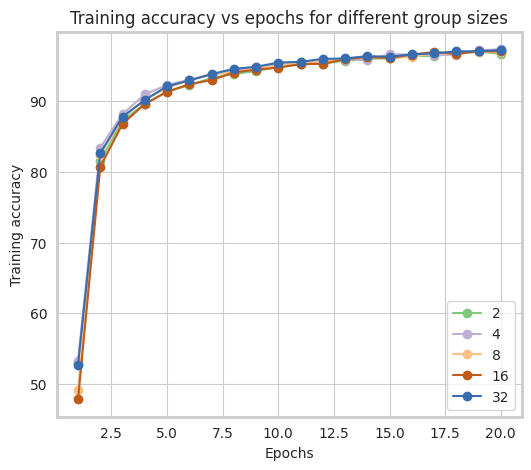

In [30]:
fig, ax = plt.subplots(figsize = (6, 5))
mpl.rcParams['axes.linewidth'] = 2
epochs = np.arange(1, 21, 1)
labels = ["2", "4", "8", "16", "32"] 
colors = ["#7fc97f", "#beaed4", "#fdc086", "#bf5b17", "#386cb0", "#f0027f"]

for i, label in enumerate(labels):
    ax.plot(epochs, train_accs[i], "-o", label = label, color = colors[i], linewidth = 1.5)
    
ax.set_xlabel("Epochs")
ax.set_ylabel("Training accuracy")
ax.set_title("Training accuracy vs epochs for different group sizes")
ax.legend()

plt.savefig("Training accuracy vs epochs for different group sizes", dpi = 300)
plt.show()

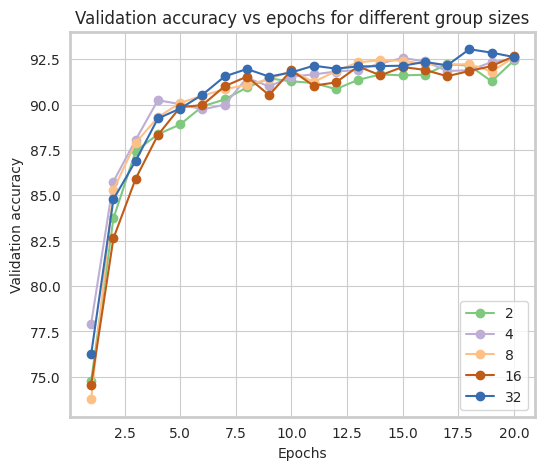

In [31]:
fig, ax = plt.subplots(figsize = (6, 5))
mpl.rcParams['axes.linewidth'] = 2
epochs = np.arange(1, 21, 1)
labels = ["2", "4", "8", "16", "32"] 
colors = ["#7fc97f", "#beaed4", "#fdc086", "#bf5b17", "#386cb0", "#f0027f"]

for i, label in enumerate(labels):
    ax.plot(epochs, val_accs[i], "-o", label = label, color = colors[i], linewidth = 1.5)
    
ax.set_xlabel("Epochs")
ax.set_ylabel("Validation accuracy")
ax.set_title("Validation accuracy vs epochs for different group sizes")
ax.legend()

plt.savefig("Validation accuracy vs epochs for different group sizes", dpi = 300)
plt.show()

In [33]:
import torch.optim as optim

# Create a writer to write to Tensorboard
writer = SummaryWriter()

epochs = 20
train_accs = torch.zeros((5, 20))
train_losses = torch.zeros((5, 20))
val_accs = torch.zeros((5, 20))
val_losses = torch.zeros((5, 20))

for i in range(5):
    print("##########################################################")
    print("model with kernel size : ", 2**(i+1))
    model = TCN(20, 200, [(32, 64)]*4 + [(64, 256)], [2**(i+1)] * 5, batch_norm=True, weight_norm=True, residual = False, bottleneck=True, groups=8).to(device)
    # Create loss function and optimizer and learning rate scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    for epoch in tqdm(range(epochs)):

        train_avg_loss = 0
        train_correct = 0
        train_total = 0
    
        validation_avg_loss = 0
        validation_correct = 0
        validation_total = 0

        for data, target in train_loader:
            data, target = encode((data.to(device), target.to(device)))
            data = data.squeeze()

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_avg_loss += loss.item()
            _, predicted = output.max(1)
            train_total += target.size(0)
            train_correct += predicted.eq(target).sum().item()
        
        with torch.no_grad():
            for data, target in validation_loader:
                data, target = encode((data.to(device), target.to(device)))
                data = data.squeeze()

                output = model(data)
                loss = criterion(output, target)

                validation_avg_loss += loss.item()
                _, predicted = output.max(1)
                validation_total += target.size(0)
                validation_correct += predicted.eq(target).sum().item()

        train_loss, train_acc = train_avg_loss/len(train_loader), 100 * train_correct / train_total
        validation_loss, validation_acc = validation_avg_loss/len(validation_loader), 100 * validation_correct / validation_total

        print(f"Epoch {epoch} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}")
        print(f"Epoch {epoch} - Validation Loss: {validation_loss:.4f} - Validation Acc: {validation_acc:.2f}")
        
        train_losses[i, epoch] = train_loss
        train_accs[i, epoch] = train_acc
        val_losses[i, epoch] = validation_loss
        val_accs[i, epoch] = validation_acc

        writer.add_scalars("Loss", {'Train': train_loss, 'Validation':validation_loss}, epoch)
        writer.add_scalars('Accuracy', {'Train': train_acc,'Validation':validation_acc} , epoch)

##########################################################
model with kernel size :  2


  5%|▌         | 1/20 [01:13<23:20, 73.69s/it]

Epoch 0 - Train Loss: 4.4641 - Train Acc: 2.89
Epoch 0 - Validation Loss: 4.3768 - Validation Acc: 3.64


 10%|█         | 2/20 [02:26<21:53, 72.99s/it]

Epoch 1 - Train Loss: 4.3365 - Train Acc: 4.03
Epoch 1 - Validation Loss: 4.3176 - Validation Acc: 4.52


 15%|█▌        | 3/20 [03:39<20:40, 73.00s/it]

Epoch 2 - Train Loss: 4.2969 - Train Acc: 4.52
Epoch 2 - Validation Loss: 4.2961 - Validation Acc: 4.38


 20%|██        | 4/20 [04:52<19:28, 73.04s/it]

Epoch 3 - Train Loss: 4.2701 - Train Acc: 4.83
Epoch 3 - Validation Loss: 4.2813 - Validation Acc: 4.81


 25%|██▌       | 5/20 [06:05<18:18, 73.22s/it]

Epoch 4 - Train Loss: 4.2550 - Train Acc: 4.94
Epoch 4 - Validation Loss: 4.2712 - Validation Acc: 4.95


 30%|███       | 6/20 [07:18<17:04, 73.15s/it]

Epoch 5 - Train Loss: 4.2412 - Train Acc: 5.06
Epoch 5 - Validation Loss: 4.2383 - Validation Acc: 5.27


 35%|███▌      | 7/20 [08:31<15:48, 72.96s/it]

Epoch 6 - Train Loss: 4.2302 - Train Acc: 5.14
Epoch 6 - Validation Loss: 4.2487 - Validation Acc: 5.35


 40%|████      | 8/20 [09:44<14:34, 72.88s/it]

Epoch 7 - Train Loss: 4.2207 - Train Acc: 5.37
Epoch 7 - Validation Loss: 4.2493 - Validation Acc: 4.89


 45%|████▌     | 9/20 [10:57<13:23, 73.02s/it]

Epoch 8 - Train Loss: 4.2097 - Train Acc: 5.53
Epoch 8 - Validation Loss: 4.2457 - Validation Acc: 5.17


 50%|█████     | 10/20 [12:10<12:11, 73.12s/it]

Epoch 9 - Train Loss: 4.2038 - Train Acc: 5.51
Epoch 9 - Validation Loss: 4.2352 - Validation Acc: 5.19


 55%|█████▌    | 11/20 [13:23<10:57, 73.09s/it]

Epoch 10 - Train Loss: 4.2001 - Train Acc: 5.57
Epoch 10 - Validation Loss: 4.2405 - Validation Acc: 5.33


 60%|██████    | 12/20 [14:36<09:44, 73.02s/it]

Epoch 11 - Train Loss: 4.1919 - Train Acc: 5.71
Epoch 11 - Validation Loss: 4.2515 - Validation Acc: 5.25


 65%|██████▌   | 13/20 [15:50<08:31, 73.12s/it]

Epoch 12 - Train Loss: 4.1885 - Train Acc: 5.82
Epoch 12 - Validation Loss: 4.2319 - Validation Acc: 5.38


 70%|███████   | 14/20 [17:02<07:18, 73.03s/it]

Epoch 13 - Train Loss: 4.1773 - Train Acc: 5.96
Epoch 13 - Validation Loss: 4.2263 - Validation Acc: 5.42


 75%|███████▌  | 15/20 [18:15<06:05, 73.05s/it]

Epoch 14 - Train Loss: 4.1724 - Train Acc: 6.03
Epoch 14 - Validation Loss: 4.2412 - Validation Acc: 5.23


 80%|████████  | 16/20 [19:29<04:52, 73.25s/it]

Epoch 15 - Train Loss: 4.1662 - Train Acc: 5.89
Epoch 15 - Validation Loss: 4.2426 - Validation Acc: 5.72


 85%|████████▌ | 17/20 [20:43<03:40, 73.40s/it]

Epoch 16 - Train Loss: 4.1624 - Train Acc: 6.03
Epoch 16 - Validation Loss: 4.2454 - Validation Acc: 5.51


 90%|█████████ | 18/20 [21:56<02:26, 73.39s/it]

Epoch 17 - Train Loss: 4.1611 - Train Acc: 6.01
Epoch 17 - Validation Loss: 4.2344 - Validation Acc: 5.56


 95%|█████████▌| 19/20 [23:09<01:13, 73.26s/it]

Epoch 18 - Train Loss: 4.1509 - Train Acc: 6.23
Epoch 18 - Validation Loss: 4.2473 - Validation Acc: 5.57


100%|██████████| 20/20 [24:23<00:00, 73.16s/it]


Epoch 19 - Train Loss: 4.1438 - Train Acc: 6.28
Epoch 19 - Validation Loss: 4.2421 - Validation Acc: 5.65
##########################################################
model with kernel size :  4


  0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/tcn_lib/TCN.py:81: UserWarning: Input length (201) is larger than the receptive field size (187). Use get_kernel_size_and_layers(201) to find the kernel size and number of layers that have a receptive field size closest to the input length.
  warnings.warn(f"Input length ({inputs.shape[-1]}) is larger than the receptive field size ({self._receptive_field_size}). Use get_kernel_size_and_layers({inputs.shape[-1]}) to find the kernel size and number of layers that have a receptive field size closest to the input length.")
  5%|▌         | 1/20 [01:13<23:23, 73.86s/it]

Epoch 0 - Train Loss: 2.9982 - Train Acc: 24.11
Epoch 0 - Validation Loss: 2.2611 - Validation Acc: 37.96


 10%|█         | 2/20 [02:26<21:57, 73.19s/it]

Epoch 1 - Train Loss: 1.9687 - Train Acc: 45.15
Epoch 1 - Validation Loss: 1.9143 - Validation Acc: 47.91


 15%|█▌        | 3/20 [03:40<20:48, 73.45s/it]

Epoch 2 - Train Loss: 1.6592 - Train Acc: 53.05
Epoch 2 - Validation Loss: 1.6331 - Validation Acc: 54.75


 20%|██        | 4/20 [04:53<19:32, 73.27s/it]

Epoch 3 - Train Loss: 1.4637 - Train Acc: 57.92
Epoch 3 - Validation Loss: 1.5098 - Validation Acc: 57.79


 25%|██▌       | 5/20 [06:06<18:16, 73.07s/it]

Epoch 4 - Train Loss: 1.3474 - Train Acc: 60.96
Epoch 4 - Validation Loss: 1.4356 - Validation Acc: 59.61


 30%|███       | 6/20 [07:19<17:05, 73.23s/it]

Epoch 5 - Train Loss: 1.2478 - Train Acc: 63.40
Epoch 5 - Validation Loss: 1.3967 - Validation Acc: 60.68


 35%|███▌      | 7/20 [08:33<15:53, 73.34s/it]

Epoch 6 - Train Loss: 1.1783 - Train Acc: 65.28
Epoch 6 - Validation Loss: 1.3343 - Validation Acc: 62.51


 40%|████      | 8/20 [09:45<14:37, 73.16s/it]

Epoch 7 - Train Loss: 1.1097 - Train Acc: 67.18
Epoch 7 - Validation Loss: 1.3382 - Validation Acc: 62.71


 45%|████▌     | 9/20 [10:59<13:25, 73.21s/it]

Epoch 8 - Train Loss: 1.0581 - Train Acc: 68.15
Epoch 8 - Validation Loss: 1.2934 - Validation Acc: 64.03


 50%|█████     | 10/20 [12:12<12:11, 73.17s/it]

Epoch 9 - Train Loss: 1.0137 - Train Acc: 69.56
Epoch 9 - Validation Loss: 1.2743 - Validation Acc: 63.75


 55%|█████▌    | 11/20 [13:26<11:00, 73.41s/it]

Epoch 10 - Train Loss: 0.9708 - Train Acc: 70.39
Epoch 10 - Validation Loss: 1.2718 - Validation Acc: 64.40


 60%|██████    | 12/20 [14:39<09:46, 73.33s/it]

Epoch 11 - Train Loss: 0.9369 - Train Acc: 71.31
Epoch 11 - Validation Loss: 1.2746 - Validation Acc: 64.62


 65%|██████▌   | 13/20 [15:52<08:33, 73.33s/it]

Epoch 12 - Train Loss: 0.9076 - Train Acc: 72.05
Epoch 12 - Validation Loss: 1.2565 - Validation Acc: 64.85


 70%|███████   | 14/20 [17:06<07:20, 73.48s/it]

Epoch 13 - Train Loss: 0.8774 - Train Acc: 72.80
Epoch 13 - Validation Loss: 1.2616 - Validation Acc: 65.34


 75%|███████▌  | 15/20 [18:19<06:07, 73.46s/it]

Epoch 14 - Train Loss: 0.8485 - Train Acc: 73.67
Epoch 14 - Validation Loss: 1.2592 - Validation Acc: 65.45


 80%|████████  | 16/20 [19:33<04:53, 73.37s/it]

Epoch 15 - Train Loss: 0.8296 - Train Acc: 74.09
Epoch 15 - Validation Loss: 1.2464 - Validation Acc: 66.18


 85%|████████▌ | 17/20 [20:46<03:39, 73.33s/it]

Epoch 16 - Train Loss: 0.8024 - Train Acc: 74.71
Epoch 16 - Validation Loss: 1.2751 - Validation Acc: 65.94


 90%|█████████ | 18/20 [22:00<02:27, 73.57s/it]

Epoch 17 - Train Loss: 0.7822 - Train Acc: 75.42
Epoch 17 - Validation Loss: 1.2600 - Validation Acc: 66.12


 95%|█████████▌| 19/20 [23:13<01:13, 73.33s/it]

Epoch 18 - Train Loss: 0.7555 - Train Acc: 76.07
Epoch 18 - Validation Loss: 1.3085 - Validation Acc: 65.51


100%|██████████| 20/20 [24:26<00:00, 73.32s/it]


Epoch 19 - Train Loss: 0.7366 - Train Acc: 76.57
Epoch 19 - Validation Loss: 1.3179 - Validation Acc: 66.30
##########################################################
model with kernel size :  8


  5%|▌         | 1/20 [01:15<23:47, 75.12s/it]

Epoch 0 - Train Loss: 1.8680 - Train Acc: 52.49
Epoch 0 - Validation Loss: 0.8593 - Validation Acc: 76.75


 10%|█         | 2/20 [02:31<22:40, 75.60s/it]

Epoch 1 - Train Loss: 0.6206 - Train Acc: 82.53
Epoch 1 - Validation Loss: 0.5575 - Validation Acc: 84.78


 15%|█▌        | 3/20 [03:46<21:23, 75.50s/it]

Epoch 2 - Train Loss: 0.4189 - Train Acc: 88.14
Epoch 2 - Validation Loss: 0.4425 - Validation Acc: 88.31


 20%|██        | 4/20 [05:02<20:08, 75.54s/it]

Epoch 3 - Train Loss: 0.3234 - Train Acc: 90.85
Epoch 3 - Validation Loss: 0.3616 - Validation Acc: 90.09


 25%|██▌       | 5/20 [06:17<18:51, 75.46s/it]

Epoch 4 - Train Loss: 0.2794 - Train Acc: 91.89
Epoch 4 - Validation Loss: 0.3558 - Validation Acc: 90.30


 30%|███       | 6/20 [07:33<17:38, 75.60s/it]

Epoch 5 - Train Loss: 0.2379 - Train Acc: 93.02
Epoch 5 - Validation Loss: 0.3452 - Validation Acc: 90.68


 35%|███▌      | 7/20 [08:49<16:26, 75.86s/it]

Epoch 6 - Train Loss: 0.2083 - Train Acc: 93.74
Epoch 6 - Validation Loss: 0.3511 - Validation Acc: 90.77


 40%|████      | 8/20 [10:04<15:04, 75.39s/it]

Epoch 7 - Train Loss: 0.1889 - Train Acc: 94.21
Epoch 7 - Validation Loss: 0.3142 - Validation Acc: 91.19


 45%|████▌     | 9/20 [11:19<13:50, 75.51s/it]

Epoch 8 - Train Loss: 0.1763 - Train Acc: 94.51
Epoch 8 - Validation Loss: 0.3253 - Validation Acc: 91.36


 50%|█████     | 10/20 [12:35<12:35, 75.60s/it]

Epoch 9 - Train Loss: 0.1644 - Train Acc: 94.88
Epoch 9 - Validation Loss: 0.3053 - Validation Acc: 92.09


 55%|█████▌    | 11/20 [13:50<11:18, 75.42s/it]

Epoch 10 - Train Loss: 0.1458 - Train Acc: 95.47
Epoch 10 - Validation Loss: 0.3437 - Validation Acc: 91.35


 60%|██████    | 12/20 [15:05<10:01, 75.16s/it]

Epoch 11 - Train Loss: 0.1340 - Train Acc: 95.76
Epoch 11 - Validation Loss: 0.3488 - Validation Acc: 91.16


 65%|██████▌   | 13/20 [16:20<08:45, 75.09s/it]

Epoch 12 - Train Loss: 0.1312 - Train Acc: 95.81
Epoch 12 - Validation Loss: 0.3003 - Validation Acc: 92.40


 70%|███████   | 14/20 [17:34<07:29, 74.97s/it]

Epoch 13 - Train Loss: 0.1203 - Train Acc: 96.14
Epoch 13 - Validation Loss: 0.3286 - Validation Acc: 92.02


 75%|███████▌  | 15/20 [18:49<06:15, 75.02s/it]

Epoch 14 - Train Loss: 0.1101 - Train Acc: 96.43
Epoch 14 - Validation Loss: 0.3297 - Validation Acc: 92.35


 80%|████████  | 16/20 [20:05<05:00, 75.11s/it]

Epoch 15 - Train Loss: 0.1047 - Train Acc: 96.55
Epoch 15 - Validation Loss: 0.3432 - Validation Acc: 92.04


 85%|████████▌ | 17/20 [21:19<03:45, 75.00s/it]

Epoch 16 - Train Loss: 0.1081 - Train Acc: 96.51
Epoch 16 - Validation Loss: 0.3136 - Validation Acc: 92.63


 90%|█████████ | 18/20 [22:36<02:30, 75.34s/it]

Epoch 17 - Train Loss: 0.0966 - Train Acc: 96.83
Epoch 17 - Validation Loss: 0.3570 - Validation Acc: 92.09


 95%|█████████▌| 19/20 [23:51<01:15, 75.45s/it]

Epoch 18 - Train Loss: 0.0914 - Train Acc: 97.02
Epoch 18 - Validation Loss: 0.3727 - Validation Acc: 91.65


100%|██████████| 20/20 [25:07<00:00, 75.36s/it]


Epoch 19 - Train Loss: 0.0868 - Train Acc: 97.14
Epoch 19 - Validation Loss: 0.3270 - Validation Acc: 92.27
##########################################################
model with kernel size :  16


  5%|▌         | 1/20 [01:15<23:58, 75.72s/it]

Epoch 0 - Train Loss: 2.1996 - Train Acc: 44.33
Epoch 0 - Validation Loss: 0.9568 - Validation Acc: 72.54


 10%|█         | 2/20 [02:31<22:47, 75.95s/it]

Epoch 1 - Train Loss: 0.6984 - Train Acc: 80.62
Epoch 1 - Validation Loss: 0.5702 - Validation Acc: 84.29


 15%|█▌        | 3/20 [03:47<21:28, 75.80s/it]

Epoch 2 - Train Loss: 0.4705 - Train Acc: 86.78
Epoch 2 - Validation Loss: 0.4795 - Validation Acc: 87.19


 20%|██        | 4/20 [05:02<20:10, 75.63s/it]

Epoch 3 - Train Loss: 0.3653 - Train Acc: 89.46
Epoch 3 - Validation Loss: 0.4076 - Validation Acc: 88.90


 25%|██▌       | 5/20 [06:18<18:56, 75.77s/it]

Epoch 4 - Train Loss: 0.3117 - Train Acc: 90.99
Epoch 4 - Validation Loss: 0.3685 - Validation Acc: 89.83


 30%|███       | 6/20 [07:34<17:42, 75.88s/it]

Epoch 5 - Train Loss: 0.2679 - Train Acc: 92.08
Epoch 5 - Validation Loss: 0.3600 - Validation Acc: 90.38


 35%|███▌      | 7/20 [08:50<16:24, 75.73s/it]

Epoch 6 - Train Loss: 0.2435 - Train Acc: 92.87
Epoch 6 - Validation Loss: 0.3636 - Validation Acc: 90.23


 40%|████      | 8/20 [10:06<15:09, 75.81s/it]

Epoch 7 - Train Loss: 0.2197 - Train Acc: 93.47
Epoch 7 - Validation Loss: 0.3254 - Validation Acc: 91.19


 45%|████▌     | 9/20 [11:22<13:53, 75.79s/it]

Epoch 8 - Train Loss: 0.2040 - Train Acc: 93.86
Epoch 8 - Validation Loss: 0.3145 - Validation Acc: 91.42


 50%|█████     | 10/20 [12:38<12:39, 75.92s/it]

Epoch 9 - Train Loss: 0.1842 - Train Acc: 94.36
Epoch 9 - Validation Loss: 0.3395 - Validation Acc: 91.24


 55%|█████▌    | 11/20 [13:54<11:23, 75.96s/it]

Epoch 10 - Train Loss: 0.1770 - Train Acc: 94.50
Epoch 10 - Validation Loss: 0.3153 - Validation Acc: 91.90


 60%|██████    | 12/20 [15:10<10:08, 76.05s/it]

Epoch 11 - Train Loss: 0.1623 - Train Acc: 94.98
Epoch 11 - Validation Loss: 0.3264 - Validation Acc: 91.76


 65%|██████▌   | 13/20 [16:26<08:51, 75.90s/it]

Epoch 12 - Train Loss: 0.1509 - Train Acc: 95.29
Epoch 12 - Validation Loss: 0.3357 - Validation Acc: 91.73


 70%|███████   | 14/20 [17:41<07:35, 75.85s/it]

Epoch 13 - Train Loss: 0.1393 - Train Acc: 95.62
Epoch 13 - Validation Loss: 0.3355 - Validation Acc: 91.94


 75%|███████▌  | 15/20 [18:57<06:18, 75.75s/it]

Epoch 14 - Train Loss: 0.1357 - Train Acc: 95.79
Epoch 14 - Validation Loss: 0.3688 - Validation Acc: 91.62


 80%|████████  | 16/20 [20:13<05:03, 75.89s/it]

Epoch 15 - Train Loss: 0.1296 - Train Acc: 95.83
Epoch 15 - Validation Loss: 0.3515 - Validation Acc: 92.14


 85%|████████▌ | 17/20 [21:29<03:47, 75.78s/it]

Epoch 16 - Train Loss: 0.1254 - Train Acc: 96.01
Epoch 16 - Validation Loss: 0.3679 - Validation Acc: 92.15


 90%|█████████ | 18/20 [22:44<02:31, 75.66s/it]

Epoch 17 - Train Loss: 0.1132 - Train Acc: 96.35
Epoch 17 - Validation Loss: 0.3339 - Validation Acc: 92.09


 95%|█████████▌| 19/20 [24:00<01:15, 75.79s/it]

Epoch 18 - Train Loss: 0.1143 - Train Acc: 96.30
Epoch 18 - Validation Loss: 0.3270 - Validation Acc: 92.36


100%|██████████| 20/20 [25:16<00:00, 75.80s/it]


Epoch 19 - Train Loss: 0.1075 - Train Acc: 96.58
Epoch 19 - Validation Loss: 0.3308 - Validation Acc: 92.06
##########################################################
model with kernel size :  32


  5%|▌         | 1/20 [01:14<23:41, 74.80s/it]

Epoch 0 - Train Loss: 2.5442 - Train Acc: 35.28
Epoch 0 - Validation Loss: 1.2314 - Validation Acc: 65.31


 10%|█         | 2/20 [02:30<22:33, 75.18s/it]

Epoch 1 - Train Loss: 0.9010 - Train Acc: 74.37
Epoch 1 - Validation Loss: 0.7414 - Validation Acc: 79.41


 15%|█▌        | 3/20 [03:44<21:13, 74.94s/it]

Epoch 2 - Train Loss: 0.6232 - Train Acc: 82.32
Epoch 2 - Validation Loss: 0.6022 - Validation Acc: 83.36


 20%|██        | 4/20 [04:59<19:57, 74.82s/it]

Epoch 3 - Train Loss: 0.4855 - Train Acc: 86.32
Epoch 3 - Validation Loss: 0.4818 - Validation Acc: 86.42


 25%|██▌       | 5/20 [06:14<18:41, 74.79s/it]

Epoch 4 - Train Loss: 0.4091 - Train Acc: 88.23
Epoch 4 - Validation Loss: 0.4899 - Validation Acc: 86.15


 30%|███       | 6/20 [07:28<17:25, 74.71s/it]

Epoch 5 - Train Loss: 0.3549 - Train Acc: 89.77
Epoch 5 - Validation Loss: 0.4454 - Validation Acc: 87.57


 35%|███▌      | 7/20 [08:43<16:10, 74.66s/it]

Epoch 6 - Train Loss: 0.3109 - Train Acc: 90.89
Epoch 6 - Validation Loss: 0.4133 - Validation Acc: 89.15


 40%|████      | 8/20 [09:58<14:55, 74.65s/it]

Epoch 7 - Train Loss: 0.2863 - Train Acc: 91.50
Epoch 7 - Validation Loss: 0.3663 - Validation Acc: 90.30


 45%|████▌     | 9/20 [11:12<13:39, 74.53s/it]

Epoch 8 - Train Loss: 0.2550 - Train Acc: 92.32
Epoch 8 - Validation Loss: 0.3733 - Validation Acc: 89.66


 50%|█████     | 10/20 [12:27<12:25, 74.59s/it]

Epoch 9 - Train Loss: 0.2320 - Train Acc: 93.03
Epoch 9 - Validation Loss: 0.3617 - Validation Acc: 90.09


 55%|█████▌    | 11/20 [13:41<11:10, 74.55s/it]

Epoch 10 - Train Loss: 0.2214 - Train Acc: 93.41
Epoch 10 - Validation Loss: 0.3468 - Validation Acc: 90.69


 60%|██████    | 12/20 [14:56<09:57, 74.69s/it]

Epoch 11 - Train Loss: 0.1911 - Train Acc: 94.14
Epoch 11 - Validation Loss: 0.3560 - Validation Acc: 90.64


 65%|██████▌   | 13/20 [16:10<08:41, 74.55s/it]

Epoch 12 - Train Loss: 0.1872 - Train Acc: 94.20
Epoch 12 - Validation Loss: 0.3444 - Validation Acc: 91.13


 70%|███████   | 14/20 [17:25<07:27, 74.56s/it]

Epoch 13 - Train Loss: 0.1753 - Train Acc: 94.59
Epoch 13 - Validation Loss: 0.3297 - Validation Acc: 91.69


 75%|███████▌  | 15/20 [18:40<06:13, 74.66s/it]

Epoch 14 - Train Loss: 0.1665 - Train Acc: 94.86
Epoch 14 - Validation Loss: 0.3337 - Validation Acc: 91.44


 80%|████████  | 16/20 [19:54<04:58, 74.69s/it]

Epoch 15 - Train Loss: 0.1524 - Train Acc: 95.30
Epoch 15 - Validation Loss: 0.3250 - Validation Acc: 91.65


 85%|████████▌ | 17/20 [21:09<03:43, 74.59s/it]

Epoch 16 - Train Loss: 0.1454 - Train Acc: 95.48
Epoch 16 - Validation Loss: 0.3523 - Validation Acc: 91.60


 90%|█████████ | 18/20 [22:24<02:29, 74.77s/it]

Epoch 17 - Train Loss: 0.1354 - Train Acc: 95.63
Epoch 17 - Validation Loss: 0.3710 - Validation Acc: 91.16


 95%|█████████▌| 19/20 [23:39<01:14, 74.75s/it]

Epoch 18 - Train Loss: 0.1331 - Train Acc: 95.79
Epoch 18 - Validation Loss: 0.3229 - Validation Acc: 92.46


100%|██████████| 20/20 [24:53<00:00, 74.68s/it]

Epoch 19 - Train Loss: 0.1303 - Train Acc: 95.86
Epoch 19 - Validation Loss: 0.3530 - Validation Acc: 91.73


In [34]:
train_accs_np = train_accs.numpy()
val_accs_np = val_accs.numpy()
train_losses_np = train_losses.numpy()
val_losses_np = val_losses.numpy()
#print(train_accs_np)
np.savetxt("kernel_train_accs.csv", train_accs_np, delimiter = ', ')
np.savetxt("kernel_val_accs.csv", val_accs_np, delimiter = ', ')
np.savetxt("kernel_train_losses.csv", train_losses_np, delimiter = ', ')
np.savetxt("kernel_val_losses.csv", val_losses_np, delimiter = ', ')

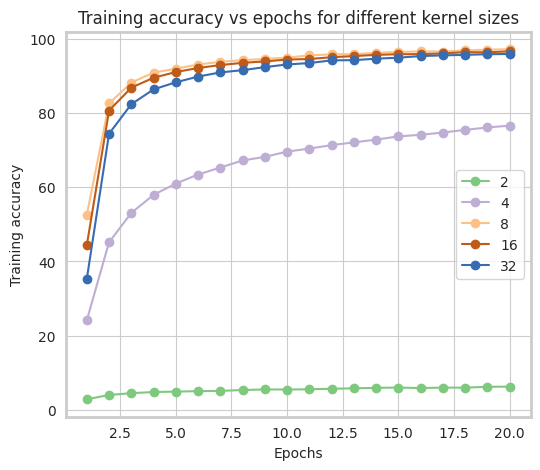

In [35]:
fig, ax = plt.subplots(figsize = (6, 5))
mpl.rcParams['axes.linewidth'] = 2
epochs = np.arange(1, 21, 1)
labels = ["2", "4", "8", "16", "32"] 
colors = ["#7fc97f", "#beaed4", "#fdc086", "#bf5b17", "#386cb0", "#f0027f"]

for i, label in enumerate(labels):
    ax.plot(epochs, train_accs[i], "-o", label = label, color = colors[i], linewidth = 1.5)
    
ax.set_xlabel("Epochs")
ax.set_ylabel("Training accuracy")
ax.set_title("Training accuracy vs epochs for different kernel sizes")
ax.legend()

plt.savefig("Training accuracy vs epochs for different kernel sizes", dpi = 300)
plt.show()

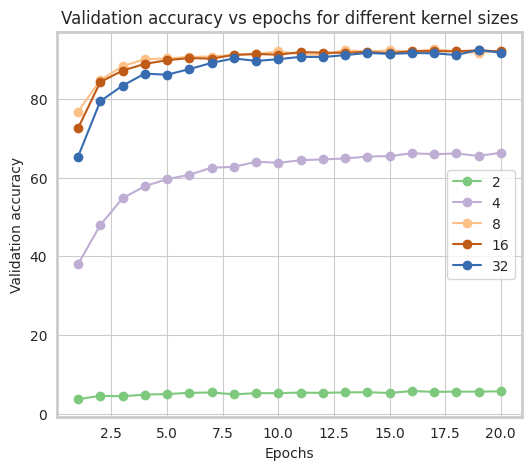

In [36]:
fig, ax = plt.subplots(figsize = (6, 5))
mpl.rcParams['axes.linewidth'] = 2
epochs = np.arange(1, 21, 1)
labels = ["2", "4", "8", "16", "32"] 
colors = ["#7fc97f", "#beaed4", "#fdc086", "#bf5b17", "#386cb0", "#f0027f"]

for i, label in enumerate(labels):
    ax.plot(epochs, val_accs[i], "-o", label = label, color = colors[i], linewidth = 1.5)
    
ax.set_xlabel("Epochs")
ax.set_ylabel("Validation accuracy")
ax.set_title("Validation accuracy vs epochs for different kernel sizes")
ax.legend()

plt.savefig("Validation accuracy vs epochs for different kernel sizes", dpi = 300)
plt.show()

In [18]:
model = TCN(20, 200, [(32, 64)]*4 + [(64, 256)], [9] * 5, batch_norm=True, weight_norm=True, residual = False, bottleneck=True, groups=32).to(device)
from torchsummary import summary
summary(model, (20, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 200]             640
       BatchNorm1d-2              [-1, 32, 200]              64
              ReLU-3              [-1, 32, 200]               0
           Dropout-4              [-1, 32, 200]               0
       _WeightNorm-5                 [-1, 1, 9]               0
ParametrizedConv1d-6              [-1, 32, 208]             288
       _WeightNorm-7                 [-1, 1, 9]               0
       _WeightNorm-8                 [-1, 1, 9]               0
       _WeightNorm-9                 [-1, 1, 9]               0
      _WeightNorm-10                 [-1, 1, 9]               0
      BatchNorm1d-11              [-1, 32, 208]              64
          Chomp1d-12              [-1, 32, 200]               0
             ReLU-13              [-1, 32, 200]               0
          Dropout-14              [-1, 

In [9]:
import torch.optim as optim

# Create a writer to write to Tensorboard
writer = SummaryWriter()

epochs = 20
train_accs = torch.zeros((3, 4, 20))
train_losses = torch.zeros((3, 4, 20))
val_accs = torch.zeros((3, 4, 20))
val_losses = torch.zeros((3, 4, 20))

residual_state = [True, False]


for i in range(3):
    for j in range(2):
        print("##########################################################")
        print("model with ", i, "layers : ")
        model = TCN(20, 200, [(32, 64)]*(i+4) + [(64, 256)], [9] * (i+5), batch_norm=True, weight_norm=True, residual = residual_state[j], bottleneck=True, groups=8).to(device)
        # Create loss function and optimizer and learning rate scheduler
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-2)
        for epoch in tqdm(range(epochs)):
    
            train_avg_loss = 0
            train_correct = 0
            train_total = 0
        
            validation_avg_loss = 0
            validation_correct = 0
            validation_total = 0
    
            for data, target in train_loader:
                data, target = encode((data.to(device), target.to(device)))
                data = data.squeeze()
    
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
    
                train_avg_loss += loss.item()
                _, predicted = output.max(1)
                train_total += target.size(0)
                train_correct += predicted.eq(target).sum().item()
            
            with torch.no_grad():
                for data, target in validation_loader:
                    data, target = encode((data.to(device), target.to(device)))
                    data = data.squeeze()
    
                    output = model(data)
                    loss = criterion(output, target)
    
                    validation_avg_loss += loss.item()
                    _, predicted = output.max(1)
                    validation_total += target.size(0)
                    validation_correct += predicted.eq(target).sum().item()

            train_loss, train_acc = train_avg_loss/len(train_loader), 100 * train_correct / train_total
            validation_loss, validation_acc = validation_avg_loss/len(validation_loader), 100 * validation_correct / validation_total

            print(f"Epoch {epoch} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}")
            print(f"Epoch {epoch} - Validation Loss: {validation_loss:.4f} - Validation Acc: {validation_acc:.2f}")
        
            train_losses[i, j, epoch] = train_loss
            train_accs[i, j, epoch] = train_acc
            val_losses[i, j, epoch] = validation_loss
            val_accs[i, j, epoch] = validation_acc

            writer.add_scalars("Loss", {'Train': train_loss, 'Validation':validation_loss}, epoch)
            writer.add_scalars('Accuracy', {'Train': train_acc,'Validation':validation_acc} , epoch)
    
    

##########################################################
model with  0 layers : 


/opt/conda/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
  5%|▌         | 1/20 [01:19<25:03, 79.15s/it]

Epoch 0 - Train Loss: 1.4024 - Train Acc: 63.80
Epoch 0 - Validation Loss: 0.6628 - Validation Acc: 81.67


 10%|█         | 2/20 [02:34<23:09, 77.19s/it]

Epoch 1 - Train Loss: 0.5218 - Train Acc: 85.39
Epoch 1 - Validation Loss: 0.4615 - Validation Acc: 86.89


 15%|█▌        | 3/20 [03:51<21:44, 76.72s/it]

Epoch 2 - Train Loss: 0.3641 - Train Acc: 89.62
Epoch 2 - Validation Loss: 0.4085 - Validation Acc: 88.25


 20%|██        | 4/20 [05:09<20:35, 77.20s/it]

Epoch 3 - Train Loss: 0.2854 - Train Acc: 91.69
Epoch 3 - Validation Loss: 0.3418 - Validation Acc: 90.64


 25%|██▌       | 5/20 [06:28<19:27, 77.83s/it]

Epoch 4 - Train Loss: 0.2359 - Train Acc: 92.97
Epoch 4 - Validation Loss: 0.3544 - Validation Acc: 90.36


 30%|███       | 6/20 [07:47<18:15, 78.28s/it]

Epoch 5 - Train Loss: 0.1995 - Train Acc: 94.00
Epoch 5 - Validation Loss: 0.3436 - Validation Acc: 91.11


 35%|███▌      | 7/20 [09:05<16:56, 78.22s/it]

Epoch 6 - Train Loss: 0.1755 - Train Acc: 94.65
Epoch 6 - Validation Loss: 0.3602 - Validation Acc: 91.22


 40%|████      | 8/20 [10:23<15:37, 78.12s/it]

Epoch 7 - Train Loss: 0.1588 - Train Acc: 95.01
Epoch 7 - Validation Loss: 0.3447 - Validation Acc: 91.47


 45%|████▌     | 9/20 [11:41<14:21, 78.32s/it]

Epoch 8 - Train Loss: 0.1304 - Train Acc: 95.78
Epoch 8 - Validation Loss: 0.3425 - Validation Acc: 91.59


 50%|█████     | 10/20 [12:59<13:00, 78.06s/it]

Epoch 9 - Train Loss: 0.1239 - Train Acc: 96.06
Epoch 9 - Validation Loss: 0.3317 - Validation Acc: 92.00


 55%|█████▌    | 11/20 [14:18<11:44, 78.29s/it]

Epoch 10 - Train Loss: 0.1213 - Train Acc: 96.05
Epoch 10 - Validation Loss: 0.3615 - Validation Acc: 91.74


 60%|██████    | 12/20 [15:35<10:24, 78.09s/it]

Epoch 11 - Train Loss: 0.1081 - Train Acc: 96.50
Epoch 11 - Validation Loss: 0.3466 - Validation Acc: 91.79


 65%|██████▌   | 13/20 [16:54<09:07, 78.18s/it]

Epoch 12 - Train Loss: 0.1050 - Train Acc: 96.56
Epoch 12 - Validation Loss: 0.3497 - Validation Acc: 92.04


 70%|███████   | 14/20 [18:12<07:48, 78.10s/it]

Epoch 13 - Train Loss: 0.0934 - Train Acc: 96.97
Epoch 13 - Validation Loss: 0.3766 - Validation Acc: 92.13


 75%|███████▌  | 15/20 [19:30<06:30, 78.09s/it]

Epoch 14 - Train Loss: 0.0935 - Train Acc: 96.97
Epoch 14 - Validation Loss: 0.3895 - Validation Acc: 91.77


 80%|████████  | 16/20 [20:49<05:13, 78.37s/it]

Epoch 15 - Train Loss: 0.0872 - Train Acc: 97.07
Epoch 15 - Validation Loss: 0.3790 - Validation Acc: 92.13


 85%|████████▌ | 17/20 [22:07<03:55, 78.40s/it]

Epoch 16 - Train Loss: 0.0778 - Train Acc: 97.49
Epoch 16 - Validation Loss: 0.3547 - Validation Acc: 92.31


 90%|█████████ | 18/20 [23:26<02:36, 78.46s/it]

Epoch 17 - Train Loss: 0.0829 - Train Acc: 97.26
Epoch 17 - Validation Loss: 0.3842 - Validation Acc: 92.26


 95%|█████████▌| 19/20 [24:44<01:18, 78.37s/it]

Epoch 18 - Train Loss: 0.0696 - Train Acc: 97.69
Epoch 18 - Validation Loss: 0.3791 - Validation Acc: 92.89


100%|██████████| 20/20 [26:02<00:00, 78.15s/it]
/opt/conda/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Epoch 19 - Train Loss: 0.0719 - Train Acc: 97.62
Epoch 19 - Validation Loss: 0.3916 - Validation Acc: 92.08
##########################################################
model with  0 layers : 


  5%|▌         | 1/20 [01:17<24:26, 77.18s/it]

Epoch 0 - Train Loss: 1.9611 - Train Acc: 51.29
Epoch 0 - Validation Loss: 0.8189 - Validation Acc: 77.53


 10%|█         | 2/20 [02:35<23:21, 77.86s/it]

Epoch 1 - Train Loss: 0.6080 - Train Acc: 83.19
Epoch 1 - Validation Loss: 0.5549 - Validation Acc: 85.03


 15%|█▌        | 3/20 [03:53<22:04, 77.94s/it]

Epoch 2 - Train Loss: 0.4092 - Train Acc: 88.57
Epoch 2 - Validation Loss: 0.4723 - Validation Acc: 87.34


 20%|██        | 4/20 [05:10<20:42, 77.69s/it]

Epoch 3 - Train Loss: 0.3287 - Train Acc: 90.48
Epoch 3 - Validation Loss: 0.3726 - Validation Acc: 90.12


 25%|██▌       | 5/20 [06:29<19:30, 78.01s/it]

Epoch 4 - Train Loss: 0.2719 - Train Acc: 92.07
Epoch 4 - Validation Loss: 0.3506 - Validation Acc: 90.54


 30%|███       | 6/20 [07:46<18:06, 77.61s/it]

Epoch 5 - Train Loss: 0.2343 - Train Acc: 93.18
Epoch 5 - Validation Loss: 0.3509 - Validation Acc: 90.84


 35%|███▌      | 7/20 [09:03<16:46, 77.44s/it]

Epoch 6 - Train Loss: 0.2084 - Train Acc: 93.67
Epoch 6 - Validation Loss: 0.3457 - Validation Acc: 91.19


 40%|████      | 8/20 [10:20<15:26, 77.23s/it]

Epoch 7 - Train Loss: 0.1885 - Train Acc: 94.28
Epoch 7 - Validation Loss: 0.3305 - Validation Acc: 91.30


 45%|████▌     | 9/20 [11:36<14:06, 76.93s/it]

Epoch 8 - Train Loss: 0.1847 - Train Acc: 94.35
Epoch 8 - Validation Loss: 0.3280 - Validation Acc: 91.68


 50%|█████     | 10/20 [12:52<12:47, 76.77s/it]

Epoch 9 - Train Loss: 0.1661 - Train Acc: 94.83
Epoch 9 - Validation Loss: 0.3177 - Validation Acc: 91.69


 55%|█████▌    | 11/20 [14:10<11:33, 77.01s/it]

Epoch 10 - Train Loss: 0.1465 - Train Acc: 95.41
Epoch 10 - Validation Loss: 0.3535 - Validation Acc: 91.63


 60%|██████    | 12/20 [15:31<10:27, 78.40s/it]

Epoch 11 - Train Loss: 0.1346 - Train Acc: 95.75
Epoch 11 - Validation Loss: 0.3307 - Validation Acc: 91.70


 65%|██████▌   | 13/20 [16:47<09:02, 77.45s/it]

Epoch 12 - Train Loss: 0.1219 - Train Acc: 96.19
Epoch 12 - Validation Loss: 0.3232 - Validation Acc: 92.38


 70%|███████   | 14/20 [18:01<07:39, 76.51s/it]

Epoch 13 - Train Loss: 0.1242 - Train Acc: 95.97
Epoch 13 - Validation Loss: 0.3545 - Validation Acc: 91.94


 75%|███████▌  | 15/20 [19:16<06:20, 76.08s/it]

Epoch 14 - Train Loss: 0.1179 - Train Acc: 96.15
Epoch 14 - Validation Loss: 0.3360 - Validation Acc: 92.00


 80%|████████  | 16/20 [20:35<05:07, 76.93s/it]

Epoch 15 - Train Loss: 0.1031 - Train Acc: 96.70
Epoch 15 - Validation Loss: 0.3639 - Validation Acc: 91.91


 85%|████████▌ | 17/20 [21:51<03:49, 76.62s/it]

Epoch 16 - Train Loss: 0.1025 - Train Acc: 96.69
Epoch 16 - Validation Loss: 0.3360 - Validation Acc: 92.66


 90%|█████████ | 18/20 [23:06<02:32, 76.13s/it]

Epoch 17 - Train Loss: 0.0881 - Train Acc: 97.10
Epoch 17 - Validation Loss: 0.3604 - Validation Acc: 92.23


 95%|█████████▌| 19/20 [24:20<01:15, 75.61s/it]

Epoch 18 - Train Loss: 0.0937 - Train Acc: 97.05
Epoch 18 - Validation Loss: 0.3428 - Validation Acc: 92.59


100%|██████████| 20/20 [25:37<00:00, 76.86s/it]


Epoch 19 - Train Loss: 0.0915 - Train Acc: 97.00
Epoch 19 - Validation Loss: 0.3262 - Validation Acc: 92.49
##########################################################
model with  1 layers : 


  5%|▌         | 1/20 [01:17<24:38, 77.82s/it]

Epoch 0 - Train Loss: 1.4672 - Train Acc: 61.88
Epoch 0 - Validation Loss: 0.7765 - Validation Acc: 78.11


 10%|█         | 2/20 [02:35<23:17, 77.63s/it]

Epoch 1 - Train Loss: 0.5696 - Train Acc: 84.08
Epoch 1 - Validation Loss: 0.5279 - Validation Acc: 84.99


 15%|█▌        | 3/20 [03:53<22:06, 78.04s/it]

Epoch 2 - Train Loss: 0.4065 - Train Acc: 88.33
Epoch 2 - Validation Loss: 0.4417 - Validation Acc: 87.79


 20%|██        | 4/20 [05:10<20:41, 77.61s/it]

Epoch 3 - Train Loss: 0.3234 - Train Acc: 90.54
Epoch 3 - Validation Loss: 0.4185 - Validation Acc: 88.89


 25%|██▌       | 5/20 [06:27<19:20, 77.37s/it]

Epoch 4 - Train Loss: 0.2644 - Train Acc: 92.07
Epoch 4 - Validation Loss: 0.3813 - Validation Acc: 89.35


 30%|███       | 6/20 [07:45<18:04, 77.43s/it]

Epoch 5 - Train Loss: 0.2296 - Train Acc: 93.00
Epoch 5 - Validation Loss: 0.3710 - Validation Acc: 90.18


 35%|███▌      | 7/20 [09:03<16:49, 77.62s/it]

Epoch 6 - Train Loss: 0.1992 - Train Acc: 93.86
Epoch 6 - Validation Loss: 0.3784 - Validation Acc: 90.21


 40%|████      | 8/20 [10:20<15:31, 77.64s/it]

Epoch 7 - Train Loss: 0.1781 - Train Acc: 94.56
Epoch 7 - Validation Loss: 0.3837 - Validation Acc: 90.73


 45%|████▌     | 9/20 [11:37<14:11, 77.44s/it]

Epoch 8 - Train Loss: 0.1549 - Train Acc: 95.10
Epoch 8 - Validation Loss: 0.3435 - Validation Acc: 91.50


 50%|█████     | 10/20 [12:55<12:53, 77.39s/it]

Epoch 9 - Train Loss: 0.1348 - Train Acc: 95.79
Epoch 9 - Validation Loss: 0.3525 - Validation Acc: 91.45


 55%|█████▌    | 11/20 [14:12<11:34, 77.19s/it]

Epoch 10 - Train Loss: 0.1350 - Train Acc: 95.61
Epoch 10 - Validation Loss: 0.3597 - Validation Acc: 91.17


 60%|██████    | 12/20 [15:27<10:13, 76.66s/it]

Epoch 11 - Train Loss: 0.1180 - Train Acc: 96.23
Epoch 11 - Validation Loss: 0.3593 - Validation Acc: 91.57


 65%|██████▌   | 13/20 [16:46<09:01, 77.39s/it]

Epoch 12 - Train Loss: 0.1067 - Train Acc: 96.53
Epoch 12 - Validation Loss: 0.3577 - Validation Acc: 91.75


 70%|███████   | 14/20 [18:03<07:43, 77.18s/it]

Epoch 13 - Train Loss: 0.1037 - Train Acc: 96.57
Epoch 13 - Validation Loss: 0.4074 - Validation Acc: 91.25


 75%|███████▌  | 15/20 [19:19<06:24, 76.94s/it]

Epoch 14 - Train Loss: 0.0941 - Train Acc: 96.94
Epoch 14 - Validation Loss: 0.3791 - Validation Acc: 91.79


 80%|████████  | 16/20 [20:36<05:08, 77.00s/it]

Epoch 15 - Train Loss: 0.0990 - Train Acc: 96.84
Epoch 15 - Validation Loss: 0.3801 - Validation Acc: 91.53


 85%|████████▌ | 17/20 [21:53<03:51, 77.01s/it]

Epoch 16 - Train Loss: 0.0934 - Train Acc: 96.93
Epoch 16 - Validation Loss: 0.4243 - Validation Acc: 90.59


 90%|█████████ | 18/20 [23:10<02:33, 76.82s/it]

Epoch 17 - Train Loss: 0.0912 - Train Acc: 97.09
Epoch 17 - Validation Loss: 0.4058 - Validation Acc: 91.09


 95%|█████████▌| 19/20 [24:25<01:16, 76.52s/it]

Epoch 18 - Train Loss: 0.0981 - Train Acc: 96.83
Epoch 18 - Validation Loss: 0.3635 - Validation Acc: 92.18


100%|██████████| 20/20 [25:41<00:00, 77.10s/it]


Epoch 19 - Train Loss: 0.0815 - Train Acc: 97.27
Epoch 19 - Validation Loss: 0.3622 - Validation Acc: 92.11
##########################################################
model with  1 layers : 


  5%|▌         | 1/20 [01:17<24:23, 77.03s/it]

Epoch 0 - Train Loss: 2.3406 - Train Acc: 41.17
Epoch 0 - Validation Loss: 1.1031 - Validation Acc: 69.28


 10%|█         | 2/20 [02:33<22:57, 76.50s/it]

Epoch 1 - Train Loss: 0.8631 - Train Acc: 75.74
Epoch 1 - Validation Loss: 0.6886 - Validation Acc: 81.13


 15%|█▌        | 3/20 [03:52<22:04, 77.91s/it]

Epoch 2 - Train Loss: 0.6013 - Train Acc: 83.09
Epoch 2 - Validation Loss: 0.6078 - Validation Acc: 83.80


 20%|██        | 4/20 [05:08<20:30, 76.89s/it]

Epoch 3 - Train Loss: 0.4635 - Train Acc: 86.85
Epoch 3 - Validation Loss: 0.4798 - Validation Acc: 86.57


 25%|██▌       | 5/20 [06:23<19:03, 76.23s/it]

Epoch 4 - Train Loss: 0.3938 - Train Acc: 88.74
Epoch 4 - Validation Loss: 0.4330 - Validation Acc: 88.18


 30%|███       | 6/20 [07:38<17:43, 75.95s/it]

Epoch 5 - Train Loss: 0.3419 - Train Acc: 90.13
Epoch 5 - Validation Loss: 0.4303 - Validation Acc: 88.52


 35%|███▌      | 7/20 [08:53<16:23, 75.62s/it]

Epoch 6 - Train Loss: 0.3016 - Train Acc: 91.19
Epoch 6 - Validation Loss: 0.3850 - Validation Acc: 89.64


 40%|████      | 8/20 [10:08<15:05, 75.49s/it]

Epoch 7 - Train Loss: 0.2669 - Train Acc: 92.20
Epoch 7 - Validation Loss: 0.4017 - Validation Acc: 89.83


 45%|████▌     | 9/20 [11:24<13:52, 75.69s/it]

Epoch 8 - Train Loss: 0.2445 - Train Acc: 92.72
Epoch 8 - Validation Loss: 0.3877 - Validation Acc: 89.89


 50%|█████     | 10/20 [12:39<12:34, 75.49s/it]

Epoch 9 - Train Loss: 0.2251 - Train Acc: 93.31
Epoch 9 - Validation Loss: 0.3804 - Validation Acc: 89.95


 55%|█████▌    | 11/20 [13:58<11:29, 76.59s/it]

Epoch 10 - Train Loss: 0.2095 - Train Acc: 93.59
Epoch 10 - Validation Loss: 0.3693 - Validation Acc: 90.60


 60%|██████    | 12/20 [15:14<10:10, 76.30s/it]

Epoch 11 - Train Loss: 0.1883 - Train Acc: 94.11
Epoch 11 - Validation Loss: 0.3585 - Validation Acc: 90.83


 65%|██████▌   | 13/20 [16:30<08:52, 76.13s/it]

Epoch 12 - Train Loss: 0.1915 - Train Acc: 94.08
Epoch 12 - Validation Loss: 0.3615 - Validation Acc: 90.55


 70%|███████   | 14/20 [17:44<07:33, 75.56s/it]

Epoch 13 - Train Loss: 0.1771 - Train Acc: 94.51
Epoch 13 - Validation Loss: 0.3319 - Validation Acc: 91.30


 75%|███████▌  | 15/20 [19:00<06:18, 75.71s/it]

Epoch 14 - Train Loss: 0.1711 - Train Acc: 94.64
Epoch 14 - Validation Loss: 0.3373 - Validation Acc: 91.23


 80%|████████  | 16/20 [20:19<05:06, 76.70s/it]

Epoch 15 - Train Loss: 0.1517 - Train Acc: 95.16
Epoch 15 - Validation Loss: 0.3900 - Validation Acc: 91.09


 85%|████████▌ | 17/20 [21:38<03:52, 77.40s/it]

Epoch 16 - Train Loss: 0.1434 - Train Acc: 95.45
Epoch 16 - Validation Loss: 0.3701 - Validation Acc: 90.72


 90%|█████████ | 18/20 [22:54<02:33, 76.84s/it]

Epoch 17 - Train Loss: 0.1355 - Train Acc: 95.66
Epoch 17 - Validation Loss: 0.3559 - Validation Acc: 91.35


 95%|█████████▌| 19/20 [24:12<01:17, 77.36s/it]

Epoch 18 - Train Loss: 0.1338 - Train Acc: 95.68
Epoch 18 - Validation Loss: 0.3514 - Validation Acc: 91.74


100%|██████████| 20/20 [25:30<00:00, 76.54s/it]


Epoch 19 - Train Loss: 0.1280 - Train Acc: 95.84
Epoch 19 - Validation Loss: 0.3546 - Validation Acc: 91.42
##########################################################
model with  2 layers : 


  5%|▌         | 1/20 [01:17<24:41, 77.98s/it]

Epoch 0 - Train Loss: 1.5914 - Train Acc: 59.23
Epoch 0 - Validation Loss: 0.7618 - Validation Acc: 78.87


 10%|█         | 2/20 [02:37<23:36, 78.72s/it]

Epoch 1 - Train Loss: 0.5981 - Train Acc: 83.29
Epoch 1 - Validation Loss: 0.5268 - Validation Acc: 85.33


 15%|█▌        | 3/20 [03:54<22:04, 77.91s/it]

Epoch 2 - Train Loss: 0.4226 - Train Acc: 88.12
Epoch 2 - Validation Loss: 0.4528 - Validation Acc: 87.01


 20%|██        | 4/20 [05:09<20:33, 77.08s/it]

Epoch 3 - Train Loss: 0.3348 - Train Acc: 90.30
Epoch 3 - Validation Loss: 0.3984 - Validation Acc: 89.00


 25%|██▌       | 5/20 [06:24<19:02, 76.19s/it]

Epoch 4 - Train Loss: 0.2775 - Train Acc: 91.94
Epoch 4 - Validation Loss: 0.3960 - Validation Acc: 89.50


 30%|███       | 6/20 [07:39<17:41, 75.80s/it]

Epoch 5 - Train Loss: 0.2352 - Train Acc: 92.99
Epoch 5 - Validation Loss: 0.3776 - Validation Acc: 89.94


 35%|███▌      | 7/20 [08:55<16:26, 75.86s/it]

Epoch 6 - Train Loss: 0.2145 - Train Acc: 93.57
Epoch 6 - Validation Loss: 0.3605 - Validation Acc: 90.40


 40%|████      | 8/20 [10:11<15:11, 75.96s/it]

Epoch 7 - Train Loss: 0.1912 - Train Acc: 94.16
Epoch 7 - Validation Loss: 0.3759 - Validation Acc: 90.40


 45%|████▌     | 9/20 [11:26<13:51, 75.60s/it]

Epoch 8 - Train Loss: 0.1590 - Train Acc: 95.13
Epoch 8 - Validation Loss: 0.3829 - Validation Acc: 90.68


 50%|█████     | 10/20 [12:44<12:42, 76.25s/it]

Epoch 9 - Train Loss: 0.1526 - Train Acc: 95.27
Epoch 9 - Validation Loss: 0.3593 - Validation Acc: 91.03


 55%|█████▌    | 11/20 [14:03<11:34, 77.14s/it]

Epoch 10 - Train Loss: 0.1370 - Train Acc: 95.68
Epoch 10 - Validation Loss: 0.3748 - Validation Acc: 90.75


 60%|██████    | 12/20 [15:19<10:13, 76.67s/it]

Epoch 11 - Train Loss: 0.1239 - Train Acc: 96.05
Epoch 11 - Validation Loss: 0.3458 - Validation Acc: 91.65


 65%|██████▌   | 13/20 [16:34<08:54, 76.37s/it]

Epoch 12 - Train Loss: 0.1190 - Train Acc: 96.14
Epoch 12 - Validation Loss: 0.4028 - Validation Acc: 90.94


 70%|███████   | 14/20 [17:50<07:37, 76.26s/it]

Epoch 13 - Train Loss: 0.1148 - Train Acc: 96.16
Epoch 13 - Validation Loss: 0.3542 - Validation Acc: 91.40


 75%|███████▌  | 15/20 [19:06<06:20, 76.11s/it]

Epoch 14 - Train Loss: 0.1147 - Train Acc: 96.25
Epoch 14 - Validation Loss: 0.3523 - Validation Acc: 91.97


 80%|████████  | 16/20 [20:21<05:03, 75.89s/it]

Epoch 15 - Train Loss: 0.0999 - Train Acc: 96.74
Epoch 15 - Validation Loss: 0.3519 - Validation Acc: 92.31


 85%|████████▌ | 17/20 [21:38<03:48, 76.05s/it]

Epoch 16 - Train Loss: 0.0970 - Train Acc: 96.81
Epoch 16 - Validation Loss: 0.3878 - Validation Acc: 91.21


 90%|█████████ | 18/20 [22:56<02:33, 76.81s/it]

Epoch 17 - Train Loss: 0.0894 - Train Acc: 97.00
Epoch 17 - Validation Loss: 0.3731 - Validation Acc: 92.26


 95%|█████████▌| 19/20 [24:15<01:17, 77.30s/it]

Epoch 18 - Train Loss: 0.0865 - Train Acc: 97.22
Epoch 18 - Validation Loss: 0.3883 - Validation Acc: 91.89


100%|██████████| 20/20 [25:31<00:00, 76.58s/it]


Epoch 19 - Train Loss: 0.0818 - Train Acc: 97.25
Epoch 19 - Validation Loss: 0.3921 - Validation Acc: 91.87
##########################################################
model with  2 layers : 


  5%|▌         | 1/20 [01:16<24:09, 76.31s/it]

Epoch 0 - Train Loss: 2.7743 - Train Acc: 30.48
Epoch 0 - Validation Loss: 1.4722 - Validation Acc: 58.63


 10%|█         | 2/20 [02:32<22:48, 76.02s/it]

Epoch 1 - Train Loss: 1.1301 - Train Acc: 68.21
Epoch 1 - Validation Loss: 0.9849 - Validation Acc: 73.53


 15%|█▌        | 3/20 [03:49<21:41, 76.54s/it]

Epoch 2 - Train Loss: 0.7870 - Train Acc: 77.83
Epoch 2 - Validation Loss: 0.7504 - Validation Acc: 78.89


 20%|██        | 4/20 [05:04<20:14, 75.94s/it]

Epoch 3 - Train Loss: 0.6266 - Train Acc: 82.18
Epoch 3 - Validation Loss: 0.6819 - Validation Acc: 80.78


 25%|██▌       | 5/20 [06:20<18:59, 76.00s/it]

Epoch 4 - Train Loss: 0.5361 - Train Acc: 84.80
Epoch 4 - Validation Loss: 0.6591 - Validation Acc: 82.51


 30%|███       | 6/20 [07:36<17:46, 76.15s/it]

Epoch 5 - Train Loss: 0.4680 - Train Acc: 86.65
Epoch 5 - Validation Loss: 0.5655 - Validation Acc: 84.35


 35%|███▌      | 7/20 [08:52<16:28, 76.08s/it]

Epoch 6 - Train Loss: 0.4220 - Train Acc: 87.77
Epoch 6 - Validation Loss: 0.5179 - Validation Acc: 86.07


 40%|████      | 8/20 [10:08<15:09, 75.81s/it]

Epoch 7 - Train Loss: 0.3750 - Train Acc: 89.08
Epoch 7 - Validation Loss: 0.5364 - Validation Acc: 86.12


 45%|████▌     | 9/20 [11:25<13:58, 76.20s/it]

Epoch 8 - Train Loss: 0.3434 - Train Acc: 89.94
Epoch 8 - Validation Loss: 0.4497 - Validation Acc: 88.04


 50%|█████     | 10/20 [12:41<12:44, 76.41s/it]

Epoch 9 - Train Loss: 0.3128 - Train Acc: 90.69
Epoch 9 - Validation Loss: 0.4402 - Validation Acc: 88.09


 55%|█████▌    | 11/20 [13:58<11:28, 76.50s/it]

Epoch 10 - Train Loss: 0.2958 - Train Acc: 91.13
Epoch 10 - Validation Loss: 0.4476 - Validation Acc: 88.31


 60%|██████    | 12/20 [15:14<10:10, 76.34s/it]

Epoch 11 - Train Loss: 0.2788 - Train Acc: 91.54
Epoch 11 - Validation Loss: 0.4348 - Validation Acc: 88.39


 65%|██████▌   | 13/20 [16:30<08:53, 76.25s/it]

Epoch 12 - Train Loss: 0.2660 - Train Acc: 91.88
Epoch 12 - Validation Loss: 0.4204 - Validation Acc: 88.36


 70%|███████   | 14/20 [17:47<07:39, 76.57s/it]

Epoch 13 - Train Loss: 0.2427 - Train Acc: 92.50
Epoch 13 - Validation Loss: 0.3969 - Validation Acc: 89.32


 75%|███████▌  | 15/20 [19:03<06:21, 76.32s/it]

Epoch 14 - Train Loss: 0.2538 - Train Acc: 92.21
Epoch 14 - Validation Loss: 0.3875 - Validation Acc: 89.80


 80%|████████  | 16/20 [20:19<05:04, 76.08s/it]

Epoch 15 - Train Loss: 0.2153 - Train Acc: 93.32
Epoch 15 - Validation Loss: 0.3902 - Validation Acc: 89.61


 85%|████████▌ | 17/20 [21:36<03:48, 76.32s/it]

Epoch 16 - Train Loss: 0.2088 - Train Acc: 93.51
Epoch 16 - Validation Loss: 0.4017 - Validation Acc: 90.35


 90%|█████████ | 18/20 [22:52<02:32, 76.27s/it]

Epoch 17 - Train Loss: 0.1925 - Train Acc: 94.02
Epoch 17 - Validation Loss: 0.3803 - Validation Acc: 90.00


 95%|█████████▌| 19/20 [24:08<01:16, 76.37s/it]

Epoch 18 - Train Loss: 0.1899 - Train Acc: 94.04
Epoch 18 - Validation Loss: 0.4156 - Validation Acc: 89.81


100%|██████████| 20/20 [25:24<00:00, 76.24s/it]

Epoch 19 - Train Loss: 0.1938 - Train Acc: 93.95
Epoch 19 - Validation Loss: 0.4563 - Validation Acc: 90.06


In [17]:
train_accs_avg = (train_accs[0, :2] + train_accs[1, :2] + train_accs[2, :2])/3
train_losses_avg = (train_losses[0, :2] + train_losses[1, :2] + train_losses[2, :2])/3
val_accs_avg = (val_accs[0, :2] + val_accs[1, :2] + val_accs[2, :2])/3
val_losses_avg = (val_losses[0, :2] + val_losses[1, :2] + val_losses[2, :2])/3

tensor([[61.6353, 84.2560, 88.6920, 90.8427, 92.3267, 93.3307, 94.0287, 94.5760,
         95.3353, 95.7067, 95.7813, 96.2587, 96.4113, 96.5653, 96.7160, 96.8827,
         97.0747, 97.1147, 97.2473, 97.3813],
        [40.9813, 75.7153, 83.1613, 86.5040, 88.5360, 89.9873, 90.8787, 91.8527,
         92.3367, 92.9427, 93.3780, 93.8013, 94.0500, 94.3280, 94.3340, 95.0580,
         95.2140, 95.5947, 95.5873, 95.5967]])

In [18]:
train_accs_np = train_accs_avg.numpy()
val_accs_np = val_accs_avg.numpy()
train_losses_np = train_losses_avg.numpy()
val_losses_np = val_losses_avg.numpy()
#print(train_accs_np)
np.savetxt("residual_train_accs.csv", train_accs_np, delimiter = ', ')
np.savetxt("residual_val_accs.csv", val_accs_np, delimiter = ', ')
np.savetxt("residual_train_losses.csv", train_losses_np, delimiter = ', ')
np.savetxt("residual_val_losses.csv", val_losses_np, delimiter = ', ')

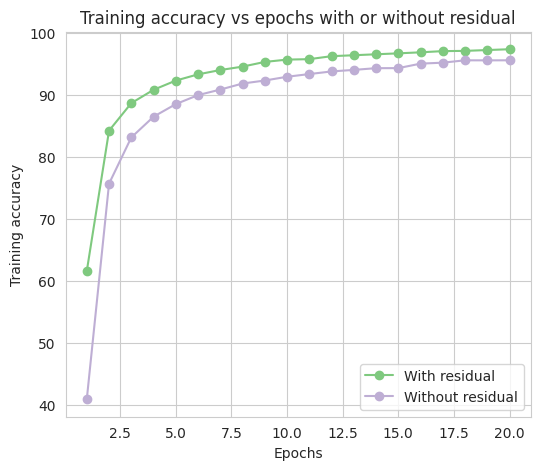

In [19]:
fig, ax = plt.subplots(figsize = (6, 5))
mpl.rcParams['axes.linewidth'] = 2
epochs = np.arange(1, 21, 1)
labels = ["With residual", "Without residual"] 
colors = ["#7fc97f", "#beaed4", "#fdc086", "#bf5b17", "#386cb0", "#f0027f"]

for i, label in enumerate(labels):
    ax.plot(epochs, train_accs_avg[i], "-o", label = label, color = colors[i], linewidth = 1.5)
    
ax.set_xlabel("Epochs")
ax.set_ylabel("Training accuracy")
ax.set_title("Training accuracy vs epochs with or without residual")
ax.legend()

plt.savefig("Training accuracy vs epochs with or without residual", dpi = 300)
plt.show()

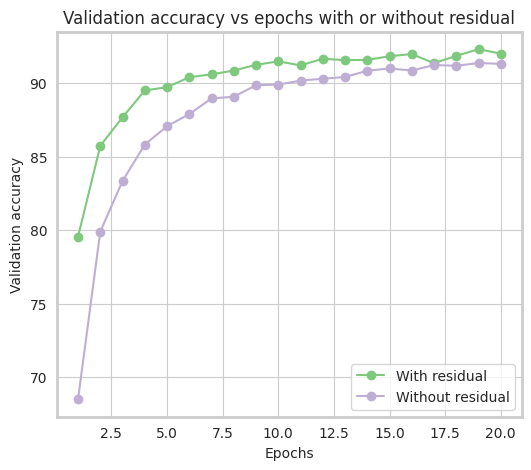

In [20]:
fig, ax = plt.subplots(figsize = (6, 5))
mpl.rcParams['axes.linewidth'] = 2
epochs = np.arange(1, 21, 1)
labels = ["With residual", "Without residual"] 
colors = ["#7fc97f", "#beaed4", "#fdc086", "#bf5b17", "#386cb0", "#f0027f"]

for i, label in enumerate(labels):
    ax.plot(epochs, val_accs_avg[i], "-o", label = label, color = colors[i], linewidth = 1.5)
    
ax.set_xlabel("Epochs")
ax.set_ylabel("Validation accuracy")
ax.set_title("Validation accuracy vs epochs with or without residual")
ax.legend()

plt.savefig("Validation accuracy vs epochs with or without residual", dpi = 300)
plt.show()

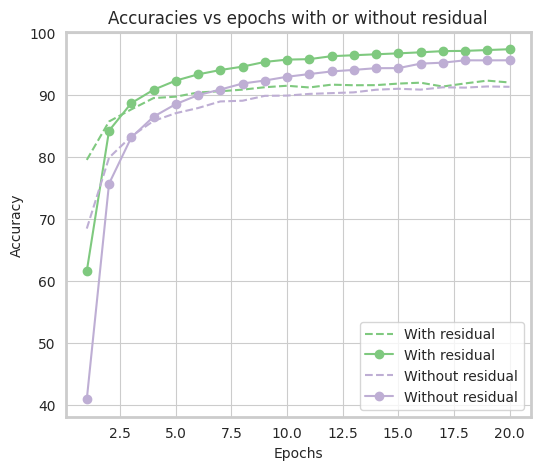

In [21]:
fig, ax = plt.subplots(figsize = (6, 5))
mpl.rcParams['axes.linewidth'] = 2
epochs = np.arange(1, 21, 1)
labels = ["With residual", "Without residual"] 
colors = ["#7fc97f", "#beaed4", "#fdc086", "#bf5b17", "#386cb0", "#f0027f"]

for i, label in enumerate(labels):
    ax.plot(epochs, val_accs_avg[i], "--", label = label, color = colors[i], linewidth = 1.5)
    ax.plot(epochs, train_accs_avg[i], "-o", label = label, color = colors[i], linewidth = 1.5)
    
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracies vs epochs with or without residual")
ax.legend()

plt.savefig("Accuracies vs epochs with or without residual", dpi = 300)
plt.show()